# 0. Load dependencies

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import h5py
import time
import random
import joblib
import datetime
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from shutil import copy
from pathlib import Path

import keras
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add, Subtract, Multiply
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, SeparableConv2D, MaxPooling2D
from keras.engine.base_layer import InputSpec
from keras.utils import conv_utils
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
import keras.backend as K

import Utility.ReadH5 as ReadH5
from Utility.log import logger
from Utility.loss import spectral_loss, combined_loss, hallucination_loss
from DataLoader.data_loader_blind import DataLoader
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


# 1. Generate training data

## Load the hyperspectral data

Load and plot: hyperspectral microscopy image of CsPbBr3 nanoplatelet film.

Expect output: SI Figure 6a.

Time cost: 1-3 min

The image has a size of 1392 x 1040 x 66 pixels.


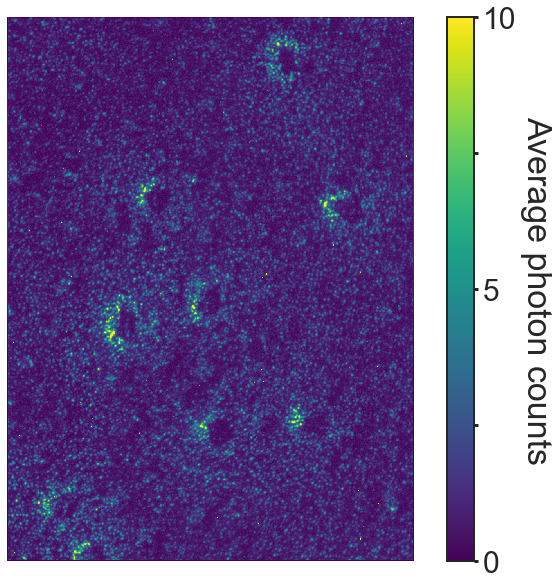

In [3]:
# Load data
file = r'CsPbBr3'
script_dir = os.path.dirname(os.path.realpath('__file__'))
path = Path(script_dir)
file_name = file + '.h5'
file_dir = os.path.join(str(path), 'Data', file_name)
with h5py.File(file_dir, 'r') as f:
    image = f['Cube']['Images'].value
img = image.astype(np.float32)
img = np.swapaxes(np.swapaxes(img, -1, 0),0,1)
print('The image has a size of {} x {} x {} pixels.'.format(img.shape[0],img.shape[1],img.shape[2]))

# Plot PL intensity map
plt.style.use('seaborn-white')
matplotlib.rcParams['axes.linewidth'] = 2
font = {'size': 34}
matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.major.pad']='8'
matplotlib.rcParams['ytick.major.pad']='8'
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

fig, ax = plt.subplots(figsize = (12,10))
mat = ax.matshow(np.mean(img,axis=2)/2**16*30000, cmap='viridis', vmin=0, vmax=10)  # Calculating effective photons from CCD readings (Supplementary Note 7)
cbar = fig.colorbar(mat)
cbar.ax.set_ylabel('Average photon counts',labelpad=35, rotation=-90)
cbar.ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=3, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='y', direction='out',length=4,width=3,pad=5,labelsize=30)
cbar.ax.tick_params(axis='y',which='minor',direction='out',length=4,width=3,pad=5,labelsize=30)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

## Prepare training data

Preparing training data for learning by adding noise to the already noisy datacube.

We will plot a small section of the PL map corresponding to a region demonstrated in the main text (Figure 2a, 480 nm) to show how the amout of noise in image affect visual preception.

Expected output: a serie of images for training with different noise levels (sigma = 0, 5, 10, 20 or 50). 

Time cost: 5 min

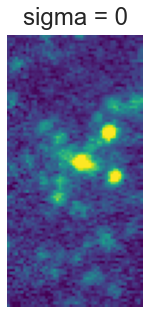

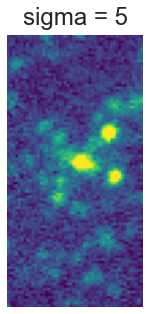

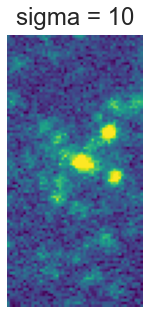

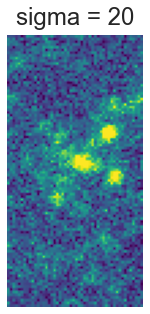

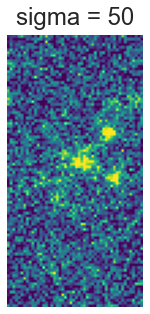

In [4]:
# normalize the image to a data range from -1 to 1 for training, and cut the high intensity noise from cosmic ray in datacube
img_norm,_,_ = ReadH5.normalization(img, dynamic=0.9999) 

# adding noise to the data
noise_list = [0, 5, 10, 20, 50]

for noise_rgb in noise_list:
    
    noisy_img = np.zeros(img.shape)
    pkl_data = {}
    noise_std = noise_rgb/255*2
    noisy_img = img_norm + np.random.normal(0, noise_std, img.shape)
    noisy_img = np.clip(noisy_img, -1, 1)
    
    if noise_rgb == 0:
        pkl_data = {'train':{'HR': img_norm[:, :, :],},'valid':{'LR': None, 'HR': None,},'test':{'LR': None, 'HR': None,}}
    else:
        pkl_data = {
            'train':{'LR': noisy_img[:, :, :],},'valid':{'LR': None,'HR': None,},'test':{'LR': None,'HR': None,}}
    
    with open(os.path.join(str(path), 'Data', 'Train', '{}_{}.joblib'.format(file, noise_rgb)), 'wb') as handle:
        joblib.dump(pkl_data, handle)
        
    # plot images
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(ReadH5.normalization(noisy_img[1000:1100,468:518,30], dynamic = 0.99)[0],cmap='viridis',)
    ax.set_frame_on(False)
    ax.set(xticklabels=[])
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlabel('sigma = {}'.format(noise_rgb), labelpad=10, fontsize=24)
    ax.xaxis.set_label_position('top')

# clean up memory
del img
del img_norm
del noisy_img
del pkl_data

# 2. Train the model

## Load the machine learning algorithm and the prepared dataset

Expect output: "Loading completed!" message.

Time cost: 3-5 min

In [5]:
class PANet():
    def __init__(self, experiment_name, file_name, dataset_name='standard_1'):
        # Input shape
        self.imgsize = 64
        self.channels = 32
        self.lr_height = self.imgsize  # Low resolution height
        self.lr_width = self.imgsize  # Low resolution width
        self.lr_shape = (None, None, self.channels)
        self.hr_height = self.imgsize  # High resolution height
        self.hr_width = self.imgsize  # High resolution width
        self.hr_shape = (None, None, self.channels)
        self.sigma_shape = (None, None, 1)
        self.noise_list = [5, 10, 20, 50]
        
        os.makedirs('Model/saved_model/%s' % experiment_name, exist_ok=True)
        
        self.file_name = file_name
        self.experiment_name = experiment_name  # The experiment name

        # Number of residual blocks in the generator
        self.n_residual_blocks = 16
        
        self.default_lr = 0.0002
        optimizer = Adam(self.default_lr, 0.5)

        # Configure data loader
        self.dataset_name = dataset_name
        self.data_loader = DataLoader(self.file_name, self.dataset_name,
                                      img_res=(self.hr_height, self.hr_width), channel=self.channels)
        
        # Calculate output shape of D (PatchGAN)
        patch = int(self.hr_height / 2 ** 4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64

        # Build the generator
        self.detector = self.build_detector()
        self.detector.compile(loss='mse',
                           optimizer=optimizer,
                           metrics=[])
        
        self.generator = self.build_generator()
        img_lr = Input(shape=self.lr_shape)
        sigma = self.detector(img_lr)
        gen_hr = self.generator([img_lr, sigma])

        def hallucination_loss(y_true, y_pred):
            if not K.is_tensor(y_pred):
                y_pred = K.constant(y_pred)
            y_true = K.cast(y_true, y_pred.dtype)
            den = K.square(y_true + 1) + 0.001
            weights = tf.div(0.001, den)-0.95
            weights = K.relu(weights)+1
            normal_mse = K.square(y_pred - y_true)
            weighted_loss = normal_mse * weights
            mean_weighted_loss = K.mean(weighted_loss, axis=-1)

            return mean_weighted_loss

        def spectral_loss(y_true, y_pred):
            if not K.is_tensor(y_pred):
                y_pred = K.constant(y_pred)
            y_true = K.cast(y_true, y_pred.dtype)

            # Calculate grad
            grad_HR = y_true[:, :, :, :-1] - y_true[:, :, :, 1:]
            grad_SR = y_pred[:, :, :, :-1] - y_pred[:, :, :, 1:]

            grad_diff = grad_HR - grad_SR
            grad_diff_1 = grad_diff[:, :, :, :-1]
            grad_diff_2 = grad_diff[:, :, :, 1:]

            spec_loss = K.mean(0.5 * K.square(grad_diff_1) +
                               0.5 * K.square(grad_diff_2), axis=-1)

            return spec_loss

        def combined_loss(y_true, y_pred, A=0.1, B=0, add_weight_to_mse = False):
            if not K.is_tensor(y_pred):
                y_pred = K.constant(y_pred)
            y_true = K.cast(y_true, y_pred.dtype)
            
            spec_loss = spectral_loss(y_true, y_pred)
            normal_mse = K.square(y_pred - y_true)
            if add_weight_to_mse is True:
                normal_mse = normal_mse/K.square(K.max(y_true, axis=[1,2], keepdims=True)-K.mean(y_true, axis=[1,2], keepdims=True)+0.001)
            normal_mse = K.mean(normal_mse, axis=-1)
            hallu_loss = hallucination_loss(y_true, y_pred)

            # change params here
            merged_loss = normal_mse + A*spec_loss + B*hallu_loss

            return merged_loss

        # Compile combined model
        self.combined = Model([img_lr], [gen_hr, sigma])
        self.combined.compile(loss=[combined_loss, 'mse'],
                              metrics=['mse',],
                              loss_weights=[1,1],
                              optimizer=optimizer)
        
    def calculate_learning_rate(self, epoch_x_batchsize, c=0.02):
        if epoch_x_batchsize < 1000:
            return self.default_lr
        elif epoch_x_batchsize > 50000:
            return self.default_lr * np.exp(0.01 * (100 - 5000) * c)
        else:
            return self.default_lr * np.exp(0.01 * (100 - epoch_x_batchsize/10) * c)
        
    def build_generator(self):

        def residual_block(layer_input, filters):
            """Residual block described in paper"""
            d = Conv2D(filters, kernel_size=3, strides=1,
                       padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        def deconv2d(layer_input):
            """Layers used during upsampling"""
            u = Conv2D(self.gf*4, kernel_size=3, strides=1,
                       padding='same')(layer_input)
            u = Activation('relu')(u)
            return u
        
        def pad():
            def func(x):
                x = K.ones_like(x)
                x = x[:, :, :, -1:]
                return x*0.01
            return Lambda(func, output_shape=(None, None, 1))
        
        # noisy image input
        img_lr = Input(shape=(None, None, self.channels))
        sigma = Input(shape=(None,))
        sigma_reshape = Reshape((1,1,1))(sigma)

        padding = pad()(img_lr)
        padding = Multiply()([padding, sigma_reshape])
        padded_lr = Concatenate(axis=-1)([img_lr, padding])
        
        # Pre-residual block
        c1 = Conv2D(self.gf*4, kernel_size=3,
                    strides=1, padding='same')(padded_lr)
        c2 = LeakyReLU(alpha=0.2)(c1)
        c2 = Conv2D(self.gf*2, kernel_size=3, strides=1, padding='same')(c2)
        c3 = LeakyReLU(alpha=0.2)(c2)
        c3 = BatchNormalization(momentum=0.8)(c3)
        c3 = Conv2D(self.gf, kernel_size=3, strides=1, padding='same')(c3)
        c4 = LeakyReLU(alpha=0.2)(c3)
        c4 = BatchNormalization(momentum=0.8)(c4)
        
        # Propogate through residual blocks
        r = residual_block(c4, self.gf)
        for _ in range(self.n_residual_blocks - 3):
            r = residual_block(r, self.gf)

        # Post-residual block
        c5 = Conv2D(self.gf, kernel_size=3, strides=1, padding='same')(r)
        c5 = LeakyReLU(alpha=0.2)(c5)
        c5 = BatchNormalization(momentum=0.8)(c5)
        c5 = Add()([c5, c3])
        c6 = Conv2D(self.gf*2, kernel_size=3, strides=1, padding='same')(c5)
        c6 = LeakyReLU(alpha=0.2)(c6)
        c6 = BatchNormalization(momentum=0.8)(c6)
        c6 = Add()([c6, c2])
        c7 = Conv2D(self.gf*4, kernel_size=3, strides=1, padding='same')(c6)
        c7 = BatchNormalization(momentum=0.8)(c7)
        c7 = Add()([c7, c1])

        # Upsampling
        u1 = deconv2d(c7)
        u2 = deconv2d(u1)

        # Generate high resolution output
        gen_hr = Conv2D(self.channels, kernel_size=3, strides=1,
                        padding='same', activation='tanh')(u2)

        return Model([img_lr, sigma], gen_hr)
    
    def build_detector(self):
        
        def residual_block(layer_input, filters):
            """Residual block described in paper"""
            d = Conv2D(filters, kernel_size=3, strides=1,
                       padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d
        
        def crop(size):
            def func(x):
                return x[:, :size, :size, :]
            return Lambda(func, output_shape=(size,size,self.gf))

        # noisy image input, input size >= 64
        img_lr = Input(shape=(None, None, self.channels))

        # Pre block
        c1 = Conv2D(self.gf, kernel_size=3,
                    strides=1, padding='same')(img_lr)
        c2 = LeakyReLU(alpha=0.2)(c1)
        
        r = residual_block(c2, self.gf)
        for _ in range(5):
            r = residual_block(r, self.gf)
            
        c3 = Conv2D(self.gf, kernel_size=3, strides=1, padding='same')(r)
        c3 = Add()([c3, c1])
        # Generate Estimation for Sigma for 64*64 image size 
        n1 = crop(64)(c3)
        n2 = Conv2D(self.gf, kernel_size=3, strides=2)(n1)
        n3 = Conv2D(self.gf*2, kernel_size=3, strides=2)(n2)
        n4 = Conv2D(self.gf*4, kernel_size=3, strides=2)(n3)
        n5 = Conv2D(self.gf*4, kernel_size=3, strides=2)(n4)
        n6 = Dense(self.gf*8)(n5)
        n7 = LeakyReLU(alpha=0.2)(n6)
        n8 = Flatten()(n7)
        sigma = Dense(1)(n8)
        
        return Model(img_lr, sigma)
    
    def train(self, epochs, batch_size=1, save_interval=100):

        start_time = datetime.datetime.now()
        
        # start tensorboard
        sess = tf.Session()
        logdir = os.path.join('tensorboard/' + self.experiment_name +
                              '_' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        print(logdir)
        writer = tf.summary.FileWriter(logdir, sess.graph)
        G_LOSS = tf.placeholder(tf.float32, [])
        MSE_LOSS = tf.placeholder(tf.float32, [])
        SPECTRUM_LOSS = tf.placeholder(tf.float32, [])
        
        tf.summary.scalar('G_LOSS', G_LOSS)
        tf.summary.scalar('MSE_LOSS', MSE_LOSS)
        tf.summary.scalar('SPECTRUM_LOSS', SPECTRUM_LOSS)

        merged = tf.summary.merge_all()
        # end tensorboard
            
        gen_model_path = r'Model/DCMall_pretrained.h5'
        self.combined = load_model(gen_model_path, custom_objects={
                        'combined_loss': combined_loss,
                        'spectral_loss': spectral_loss,
                        'hallucination_loss': hallucination_loss,})
            
        for epoch in range(epochs):
            current_epoch = epoch + 1
            
            sigma_index = np.array([0] * batch_size)
            sigma = [0] * batch_size

            for i in range(batch_size):
                sigma_index[i] = random.randint(0,len(self.noise_list)-1)
                sigma[i] = self.noise_list[sigma_index[i]]

            imgs_hr, imgs_lr = self.data_loader.load_data(batch_size,sigma=sigma)
            
            # Train the generators only
            current_learning_rate = self.calculate_learning_rate(current_epoch*batch_size)
            K.set_value(self.combined.optimizer.lr, current_learning_rate)
            
            g_loss = self.combined.train_on_batch(
                imgs_lr, [imgs_hr, np.array(sigma)])

            # NOTE: g_loss[0] is combined model loss
            # look up:
            # self.combined.metrics_names
            summary = sess.run(merged, feed_dict={G_LOSS: g_loss[0], MSE_LOSS: g_loss[1], SPECTRUM_LOSS: g_loss[2],})
            writer.add_summary(summary, current_epoch)

            elapsed_time = datetime.datetime.now() - start_time

            # Plot the progress
            loss_str = ''
            loss_str += 'combined-> '
            for i in range(len(g_loss)):
                loss_str += '{}:{} ||'.format(
                    self.combined.metrics_names[i], g_loss[i])
            
            logger.info("%d time: %s  %s" %
                        (current_epoch, elapsed_time, loss_str))
            
            # Save model at save_interval
            if current_epoch % save_interval == 0:
                self.combined.save(
                    'Model/saved_model/{}/'.format(self.experiment_name) + 'gen_model%d.h5' % current_epoch)
                
        logger.info('Training completed.')
        
net = PANet(experiment_name='CsPbBr3', file_name='CsPbBr3', dataset_name='standard_1')
print("Loading completed!")

dict_keys([0, 5, 10, 20, 50]) loaded
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Loading completed!


## (Optional) Train the algorithm

We also provide an already-trained model for quick data analysis. To do so, skip this section or stop the following code at any time and run later sections.

Expect output: training step reaches 10000 and stops. Combined loss is expected to decrease over time until reaching its local minimum.

Time cost: 40 min (Nvidia A100 GPU), 2 hours (GeForce GTX 1080) or 55 hours (CPU)

In [3]:
net.train(epochs=10000, batch_size=32, save_interval=1000)

tensorboard/CsPbBr3_20221126-044825



2022-11-26 04:49:10,960 - Utility.log - INFO - 1 time: 0:00:45.146857  combined-> loss:71.94242858886719 ||model_2_loss:0.013526281341910362 ||model_1_loss:71.92890167236328 ||model_2_mse:0.012764346785843372 ||
2022-11-26 04:49:11,222 - Utility.log - INFO - 2 time: 0:00:45.408346  combined-> loss:221.6089324951172 ||model_2_loss:0.09775406122207642 ||model_1_loss:221.5111846923828 ||model_2_mse:0.09549964964389801 ||
2022-11-26 04:49:11,472 - Utility.log - INFO - 3 time: 0:00:45.658719  combined-> loss:1718.2783203125 ||model_2_loss:0.10407184809446335 ||model_1_loss:1718.1741943359375 ||model_2_mse:0.10331211984157562 ||
2022-11-26 04:49:11,722 - Utility.log - INFO - 4 time: 0:00:45.908902  combined-> loss:588.2138671875 ||model_2_loss:0.10694631189107895 ||model_1_loss:588.10693359375 ||model_2_mse:0.10613533854484558 ||
2022-11-26 04:49:11,969 - Utility.log - INFO - 5 time: 0:00:46.155612  combined-> loss:292.385986328125 ||model_2_loss:0.19348128139972687 ||model_1_loss:292.192504

2022-11-26 04:49:20,671 - Utility.log - INFO - 40 time: 0:00:54.857807  combined-> loss:28.546220779418945 ||model_2_loss:0.011285902932286263 ||model_1_loss:28.534934997558594 ||model_2_mse:0.01034095324575901 ||
2022-11-26 04:49:20,919 - Utility.log - INFO - 41 time: 0:00:55.105477  combined-> loss:6.341850280761719 ||model_2_loss:0.011232278309762478 ||model_1_loss:6.330617904663086 ||model_2_mse:0.010294992476701736 ||
2022-11-26 04:49:21,167 - Utility.log - INFO - 42 time: 0:00:55.354092  combined-> loss:15.072921752929688 ||model_2_loss:0.01476684957742691 ||model_1_loss:15.058155059814453 ||model_2_mse:0.013773984275758266 ||
2022-11-26 04:49:21,415 - Utility.log - INFO - 43 time: 0:00:55.601554  combined-> loss:7.715363025665283 ||model_2_loss:0.011691384948790073 ||model_1_loss:7.703671455383301 ||model_2_mse:0.010793580673635006 ||
2022-11-26 04:49:21,664 - Utility.log - INFO - 44 time: 0:00:55.850873  combined-> loss:18.002445220947266 ||model_2_loss:0.010834025219082832 ||m

2022-11-26 04:49:30,379 - Utility.log - INFO - 79 time: 0:01:04.566159  combined-> loss:11.707587242126465 ||model_2_loss:0.008518814109265804 ||model_1_loss:11.699068069458008 ||model_2_mse:0.007670859806239605 ||
2022-11-26 04:49:30,630 - Utility.log - INFO - 80 time: 0:01:04.816461  combined-> loss:4.801000595092773 ||model_2_loss:0.008332991972565651 ||model_1_loss:4.792667388916016 ||model_2_mse:0.007541949860751629 ||
2022-11-26 04:49:30,879 - Utility.log - INFO - 81 time: 0:01:05.065365  combined-> loss:24.71315574645996 ||model_2_loss:0.008276649750769138 ||model_1_loss:24.704879760742188 ||model_2_mse:0.007483803201466799 ||
2022-11-26 04:49:31,129 - Utility.log - INFO - 82 time: 0:01:05.315339  combined-> loss:14.29532527923584 ||model_2_loss:0.008086686953902245 ||model_1_loss:14.287238121032715 ||model_2_mse:0.007232206873595715 ||
2022-11-26 04:49:31,374 - Utility.log - INFO - 83 time: 0:01:05.560276  combined-> loss:24.29513168334961 ||model_2_loss:0.008182326331734657 ||

2022-11-26 04:49:40,080 - Utility.log - INFO - 118 time: 0:01:14.266568  combined-> loss:4.751980781555176 ||model_2_loss:0.007138348184525967 ||model_1_loss:4.744842529296875 ||model_2_mse:0.006326818373054266 ||
2022-11-26 04:49:40,328 - Utility.log - INFO - 119 time: 0:01:14.514597  combined-> loss:5.145946502685547 ||model_2_loss:0.007180037908256054 ||model_1_loss:5.138766288757324 ||model_2_mse:0.0063917376101017 ||
2022-11-26 04:49:40,576 - Utility.log - INFO - 120 time: 0:01:14.763188  combined-> loss:4.650424003601074 ||model_2_loss:0.007589301094412804 ||model_1_loss:4.642834663391113 ||model_2_mse:0.006741093471646309 ||
2022-11-26 04:49:40,823 - Utility.log - INFO - 121 time: 0:01:15.009996  combined-> loss:14.076147079467773 ||model_2_loss:0.007127999793738127 ||model_1_loss:14.069019317626953 ||model_2_mse:0.006334483623504639 ||
2022-11-26 04:49:41,073 - Utility.log - INFO - 122 time: 0:01:15.259449  combined-> loss:14.47078800201416 ||model_2_loss:0.007136345840990543 |

2022-11-26 04:49:49,767 - Utility.log - INFO - 157 time: 0:01:23.954073  combined-> loss:3.9306178092956543 ||model_2_loss:0.006582903675734997 ||model_1_loss:3.924034833908081 ||model_2_mse:0.005809808615595102 ||
2022-11-26 04:49:50,021 - Utility.log - INFO - 158 time: 0:01:24.207812  combined-> loss:31.76677131652832 ||model_2_loss:0.006450430490076542 ||model_1_loss:31.76032066345215 ||model_2_mse:0.005699049681425095 ||
2022-11-26 04:49:50,270 - Utility.log - INFO - 159 time: 0:01:24.457092  combined-> loss:34.38983154296875 ||model_2_loss:0.00687751267105341 ||model_1_loss:34.38295364379883 ||model_2_mse:0.006081318482756615 ||
2022-11-26 04:49:50,519 - Utility.log - INFO - 160 time: 0:01:24.705729  combined-> loss:88.0240707397461 ||model_2_loss:0.007220293395221233 ||model_1_loss:88.01685333251953 ||model_2_mse:0.0064167906530201435 ||
2022-11-26 04:49:50,767 - Utility.log - INFO - 161 time: 0:01:24.954189  combined-> loss:13.29504680633545 ||model_2_loss:0.006857565604150295 |

2022-11-26 04:49:59,485 - Utility.log - INFO - 196 time: 0:01:33.671292  combined-> loss:13.010543823242188 ||model_2_loss:0.0063112713396549225 ||model_1_loss:13.004232406616211 ||model_2_mse:0.005585802718997002 ||
2022-11-26 04:49:59,732 - Utility.log - INFO - 197 time: 0:01:33.918551  combined-> loss:10.100044250488281 ||model_2_loss:0.0070455074310302734 ||model_1_loss:10.092998504638672 ||model_2_mse:0.006240772549062967 ||
2022-11-26 04:49:59,982 - Utility.log - INFO - 198 time: 0:01:34.168698  combined-> loss:2.7348473072052 ||model_2_loss:0.006533422507345676 ||model_1_loss:2.72831392288208 ||model_2_mse:0.005797717720270157 ||
2022-11-26 04:50:00,229 - Utility.log - INFO - 199 time: 0:01:34.415601  combined-> loss:4.141975402832031 ||model_2_loss:0.0064087482169270515 ||model_1_loss:4.135566711425781 ||model_2_mse:0.005661936476826668 ||
2022-11-26 04:50:00,478 - Utility.log - INFO - 200 time: 0:01:34.664449  combined-> loss:7.646030426025391 ||model_2_loss:0.0065731145441532

2022-11-26 04:50:09,180 - Utility.log - INFO - 235 time: 0:01:43.367063  combined-> loss:20.181058883666992 ||model_2_loss:0.00652193883433938 ||model_1_loss:20.174537658691406 ||model_2_mse:0.0057353125885128975 ||
2022-11-26 04:50:09,432 - Utility.log - INFO - 236 time: 0:01:43.618306  combined-> loss:5.225802898406982 ||model_2_loss:0.006797248497605324 ||model_1_loss:5.219005584716797 ||model_2_mse:0.005997019819915295 ||
2022-11-26 04:50:09,678 - Utility.log - INFO - 237 time: 0:01:43.864561  combined-> loss:4.890418529510498 ||model_2_loss:0.006490171886980534 ||model_1_loss:4.883928298950195 ||model_2_mse:0.005720182321965694 ||
2022-11-26 04:50:09,927 - Utility.log - INFO - 238 time: 0:01:44.114166  combined-> loss:5.969018936157227 ||model_2_loss:0.006600590422749519 ||model_1_loss:5.962418556213379 ||model_2_mse:0.005826412234455347 ||
2022-11-26 04:50:10,175 - Utility.log - INFO - 239 time: 0:01:44.361802  combined-> loss:4.648343563079834 ||model_2_loss:0.006360077299177647

2022-11-26 04:50:18,907 - Utility.log - INFO - 274 time: 0:01:53.093493  combined-> loss:4.464879989624023 ||model_2_loss:0.006283348426222801 ||model_1_loss:4.458596706390381 ||model_2_mse:0.005522910505533218 ||
2022-11-26 04:50:19,153 - Utility.log - INFO - 275 time: 0:01:53.339591  combined-> loss:6.82399320602417 ||model_2_loss:0.005961902439594269 ||model_1_loss:6.818031311035156 ||model_2_mse:0.005210366565734148 ||
2022-11-26 04:50:19,404 - Utility.log - INFO - 276 time: 0:01:53.590688  combined-> loss:5.8220672607421875 ||model_2_loss:0.006160861812531948 ||model_1_loss:5.815906524658203 ||model_2_mse:0.005398305132985115 ||
2022-11-26 04:50:19,651 - Utility.log - INFO - 277 time: 0:01:53.837286  combined-> loss:2.648872137069702 ||model_2_loss:0.005947900004684925 ||model_1_loss:2.6429243087768555 ||model_2_mse:0.005230654031038284 ||
2022-11-26 04:50:19,901 - Utility.log - INFO - 278 time: 0:01:54.087548  combined-> loss:1.8063278198242188 ||model_2_loss:0.006522287614643574

2022-11-26 04:50:28,628 - Utility.log - INFO - 313 time: 0:02:02.814840  combined-> loss:3.683378219604492 ||model_2_loss:0.0066156573593616486 ||model_1_loss:3.676762580871582 ||model_2_mse:0.005809999071061611 ||
2022-11-26 04:50:28,879 - Utility.log - INFO - 314 time: 0:02:03.065303  combined-> loss:6.262425899505615 ||model_2_loss:0.006236549932509661 ||model_1_loss:6.256189346313477 ||model_2_mse:0.005459577776491642 ||
2022-11-26 04:50:29,125 - Utility.log - INFO - 315 time: 0:02:03.311735  combined-> loss:3.166750192642212 ||model_2_loss:0.006625531241297722 ||model_1_loss:3.1601247787475586 ||model_2_mse:0.005811010487377644 ||
2022-11-26 04:50:29,376 - Utility.log - INFO - 316 time: 0:02:03.562884  combined-> loss:12.95059585571289 ||model_2_loss:0.006355148274451494 ||model_1_loss:12.94424057006836 ||model_2_mse:0.005593255162239075 ||
2022-11-26 04:50:29,624 - Utility.log - INFO - 317 time: 0:02:03.810495  combined-> loss:3.9750418663024902 ||model_2_loss:0.00633463682606816

2022-11-26 04:50:38,317 - Utility.log - INFO - 352 time: 0:02:12.504194  combined-> loss:5.716305255889893 ||model_2_loss:0.006205250509083271 ||model_1_loss:5.710100173950195 ||model_2_mse:0.005444307811558247 ||
2022-11-26 04:50:38,564 - Utility.log - INFO - 353 time: 0:02:12.750689  combined-> loss:2.3250210285186768 ||model_2_loss:0.006264041643589735 ||model_1_loss:2.3187570571899414 ||model_2_mse:0.0055017112754285336 ||
2022-11-26 04:50:38,814 - Utility.log - INFO - 354 time: 0:02:13.000590  combined-> loss:2.5076913833618164 ||model_2_loss:0.0064255837351083755 ||model_1_loss:2.50126576423645 ||model_2_mse:0.005655186250805855 ||
2022-11-26 04:50:39,061 - Utility.log - INFO - 355 time: 0:02:13.247471  combined-> loss:6.053652763366699 ||model_2_loss:0.006112207658588886 ||model_1_loss:6.047540664672852 ||model_2_mse:0.005379698239266872 ||
2022-11-26 04:50:39,313 - Utility.log - INFO - 356 time: 0:02:13.499944  combined-> loss:2.4371421337127686 ||model_2_loss:0.005971450824290

2022-11-26 04:50:48,036 - Utility.log - INFO - 391 time: 0:02:22.222865  combined-> loss:2.2101144790649414 ||model_2_loss:0.006582072004675865 ||model_1_loss:2.2035324573516846 ||model_2_mse:0.005810139700770378 ||
2022-11-26 04:50:48,286 - Utility.log - INFO - 392 time: 0:02:22.473207  combined-> loss:2.1765310764312744 ||model_2_loss:0.005762331187725067 ||model_1_loss:2.1707687377929688 ||model_2_mse:0.0050437720492482185 ||
2022-11-26 04:50:48,533 - Utility.log - INFO - 393 time: 0:02:22.719528  combined-> loss:2.579349994659424 ||model_2_loss:0.005707168951630592 ||model_1_loss:2.5736427307128906 ||model_2_mse:0.004988727159798145 ||
2022-11-26 04:50:48,783 - Utility.log - INFO - 394 time: 0:02:22.969832  combined-> loss:3.3375399112701416 ||model_2_loss:0.00619120430201292 ||model_1_loss:3.3313486576080322 ||model_2_mse:0.005434301681816578 ||
2022-11-26 04:50:49,030 - Utility.log - INFO - 395 time: 0:02:23.217073  combined-> loss:7.722978115081787 ||model_2_loss:0.0060265646316

2022-11-26 04:50:57,742 - Utility.log - INFO - 430 time: 0:02:31.929037  combined-> loss:4.832108974456787 ||model_2_loss:0.0056357476860284805 ||model_1_loss:4.826473236083984 ||model_2_mse:0.004928958602249622 ||
2022-11-26 04:50:57,990 - Utility.log - INFO - 431 time: 0:02:32.176887  combined-> loss:9.418227195739746 ||model_2_loss:0.006145836319774389 ||model_1_loss:9.412081718444824 ||model_2_mse:0.005375763401389122 ||
2022-11-26 04:50:58,240 - Utility.log - INFO - 432 time: 0:02:32.426404  combined-> loss:2.4728643894195557 ||model_2_loss:0.005639246664941311 ||model_1_loss:2.4672250747680664 ||model_2_mse:0.00491958437487483 ||
2022-11-26 04:50:58,486 - Utility.log - INFO - 433 time: 0:02:32.672739  combined-> loss:2.3940625190734863 ||model_2_loss:0.006351912394165993 ||model_1_loss:2.3877105712890625 ||model_2_mse:0.005576525814831257 ||
2022-11-26 04:50:58,735 - Utility.log - INFO - 434 time: 0:02:32.921819  combined-> loss:2.4500410556793213 ||model_2_loss:0.005997506901621

2022-11-26 04:51:07,448 - Utility.log - INFO - 469 time: 0:02:41.634257  combined-> loss:3.9214701652526855 ||model_2_loss:0.007720509544014931 ||model_1_loss:3.9137496948242188 ||model_2_mse:0.006859346758574247 ||
2022-11-26 04:51:07,698 - Utility.log - INFO - 470 time: 0:02:41.884573  combined-> loss:4.185199737548828 ||model_2_loss:0.006281126290559769 ||model_1_loss:4.178918838500977 ||model_2_mse:0.005588266998529434 ||
2022-11-26 04:51:07,944 - Utility.log - INFO - 471 time: 0:02:42.130946  combined-> loss:2.795574903488159 ||model_2_loss:0.0061809285543859005 ||model_1_loss:2.789393901824951 ||model_2_mse:0.005432466976344585 ||
2022-11-26 04:51:08,194 - Utility.log - INFO - 472 time: 0:02:42.380376  combined-> loss:1.949872374534607 ||model_2_loss:0.0056394366547465324 ||model_1_loss:1.9442329406738281 ||model_2_mse:0.004909806419163942 ||
2022-11-26 04:51:08,441 - Utility.log - INFO - 473 time: 0:02:42.627944  combined-> loss:6.266334056854248 ||model_2_loss:0.006275103427469

2022-11-26 04:51:17,178 - Utility.log - INFO - 508 time: 0:02:51.364270  combined-> loss:1.743920922279358 ||model_2_loss:0.005962296389043331 ||model_1_loss:1.7379586696624756 ||model_2_mse:0.005210962146520615 ||
2022-11-26 04:51:17,424 - Utility.log - INFO - 509 time: 0:02:51.611124  combined-> loss:4.7808637619018555 ||model_2_loss:0.006556896027177572 ||model_1_loss:4.774306774139404 ||model_2_mse:0.005748809315264225 ||
2022-11-26 04:51:17,677 - Utility.log - INFO - 510 time: 0:02:51.863877  combined-> loss:8.521627426147461 ||model_2_loss:0.005932203494012356 ||model_1_loss:8.515695571899414 ||model_2_mse:0.005188406445086002 ||
2022-11-26 04:51:17,928 - Utility.log - INFO - 511 time: 0:02:52.114977  combined-> loss:1.280830979347229 ||model_2_loss:0.006568363402038813 ||model_1_loss:1.2742626667022705 ||model_2_mse:0.005791652016341686 ||
2022-11-26 04:51:18,180 - Utility.log - INFO - 512 time: 0:02:52.366327  combined-> loss:9.739087104797363 ||model_2_loss:0.00636086612939834

2022-11-26 04:51:26,889 - Utility.log - INFO - 547 time: 0:03:01.076070  combined-> loss:2.7840123176574707 ||model_2_loss:0.005649981088936329 ||model_1_loss:2.778362274169922 ||model_2_mse:0.0049353959038853645 ||
2022-11-26 04:51:27,139 - Utility.log - INFO - 548 time: 0:03:01.325639  combined-> loss:1.7181354761123657 ||model_2_loss:0.005746508948504925 ||model_1_loss:1.7123889923095703 ||model_2_mse:0.00501505471765995 ||
2022-11-26 04:51:27,387 - Utility.log - INFO - 549 time: 0:03:01.573574  combined-> loss:5.514133930206299 ||model_2_loss:0.006032045464962721 ||model_1_loss:5.508101940155029 ||model_2_mse:0.005285550840198994 ||
2022-11-26 04:51:27,637 - Utility.log - INFO - 550 time: 0:03:01.824205  combined-> loss:1.5741857290267944 ||model_2_loss:0.00580182671546936 ||model_1_loss:1.5683839321136475 ||model_2_mse:0.005069189239293337 ||
2022-11-26 04:51:27,884 - Utility.log - INFO - 551 time: 0:03:02.071230  combined-> loss:1.8430134057998657 ||model_2_loss:0.006100310944020

2022-11-26 04:51:36,611 - Utility.log - INFO - 586 time: 0:03:10.797939  combined-> loss:9.409716606140137 ||model_2_loss:0.005889618303626776 ||model_1_loss:9.403826713562012 ||model_2_mse:0.005132430233061314 ||
2022-11-26 04:51:36,859 - Utility.log - INFO - 587 time: 0:03:11.045431  combined-> loss:1.2228446006774902 ||model_2_loss:0.005944930016994476 ||model_1_loss:1.2168996334075928 ||model_2_mse:0.005213500000536442 ||
2022-11-26 04:51:37,109 - Utility.log - INFO - 588 time: 0:03:11.295846  combined-> loss:1.761518120765686 ||model_2_loss:0.005645435303449631 ||model_1_loss:1.7558727264404297 ||model_2_mse:0.004915328696370125 ||
2022-11-26 04:51:37,358 - Utility.log - INFO - 589 time: 0:03:11.545081  combined-> loss:11.01997184753418 ||model_2_loss:0.005881885997951031 ||model_1_loss:11.014089584350586 ||model_2_mse:0.005146327428519726 ||
2022-11-26 04:51:37,608 - Utility.log - INFO - 590 time: 0:03:11.795181  combined-> loss:2.2916371822357178 ||model_2_loss:0.005871814675629

2022-11-26 04:51:46,314 - Utility.log - INFO - 625 time: 0:03:20.501120  combined-> loss:2.7261152267456055 ||model_2_loss:0.006182102486491203 ||model_1_loss:2.719933032989502 ||model_2_mse:0.005413028411567211 ||
2022-11-26 04:51:46,566 - Utility.log - INFO - 626 time: 0:03:20.752737  combined-> loss:7.2990241050720215 ||model_2_loss:0.005990168079733849 ||model_1_loss:7.293034076690674 ||model_2_mse:0.0052473233081400394 ||
2022-11-26 04:51:46,813 - Utility.log - INFO - 627 time: 0:03:20.999433  combined-> loss:7.3795485496521 ||model_2_loss:0.00527185620740056 ||model_1_loss:7.374276638031006 ||model_2_mse:0.004608748480677605 ||
2022-11-26 04:51:47,063 - Utility.log - INFO - 628 time: 0:03:21.249517  combined-> loss:2.2489521503448486 ||model_2_loss:0.006229232996702194 ||model_1_loss:2.242722988128662 ||model_2_mse:0.005475659854710102 ||
2022-11-26 04:51:47,308 - Utility.log - INFO - 629 time: 0:03:21.495169  combined-> loss:5.619246482849121 ||model_2_loss:0.006172340363264084 

2022-11-26 04:51:56,002 - Utility.log - INFO - 664 time: 0:03:30.188258  combined-> loss:0.9874114990234375 ||model_2_loss:0.006091582588851452 ||model_1_loss:0.9813199043273926 ||model_2_mse:0.005318189039826393 ||
2022-11-26 04:51:56,251 - Utility.log - INFO - 665 time: 0:03:30.437861  combined-> loss:1.4291529655456543 ||model_2_loss:0.00600782036781311 ||model_1_loss:1.4231451749801636 ||model_2_mse:0.005248669534921646 ||
2022-11-26 04:51:56,502 - Utility.log - INFO - 666 time: 0:03:30.688678  combined-> loss:1.5607578754425049 ||model_2_loss:0.005942183546721935 ||model_1_loss:1.554815649986267 ||model_2_mse:0.005179612897336483 ||
2022-11-26 04:51:56,750 - Utility.log - INFO - 667 time: 0:03:30.936501  combined-> loss:2.28112530708313 ||model_2_loss:0.006593901198357344 ||model_1_loss:2.274531364440918 ||model_2_mse:0.0057484908029437065 ||
2022-11-26 04:51:57,001 - Utility.log - INFO - 668 time: 0:03:31.187611  combined-> loss:3.326572895050049 ||model_2_loss:0.0061466479673981

2022-11-26 04:52:05,734 - Utility.log - INFO - 703 time: 0:03:39.920571  combined-> loss:3.3093669414520264 ||model_2_loss:0.006125359330326319 ||model_1_loss:3.303241491317749 ||model_2_mse:0.0053413850255310535 ||
2022-11-26 04:52:05,984 - Utility.log - INFO - 704 time: 0:03:40.170655  combined-> loss:1.1442837715148926 ||model_2_loss:0.0055016037076711655 ||model_1_loss:1.1387821435928345 ||model_2_mse:0.004818789195269346 ||
2022-11-26 04:52:06,231 - Utility.log - INFO - 705 time: 0:03:40.417763  combined-> loss:1.244837760925293 ||model_2_loss:0.005624375306069851 ||model_1_loss:1.2392133474349976 ||model_2_mse:0.004908463452011347 ||
2022-11-26 04:52:06,476 - Utility.log - INFO - 706 time: 0:03:40.662855  combined-> loss:1.679858684539795 ||model_2_loss:0.006093991454690695 ||model_1_loss:1.673764705657959 ||model_2_mse:0.005326745565980673 ||
2022-11-26 04:52:06,721 - Utility.log - INFO - 707 time: 0:03:40.907708  combined-> loss:3.1991748809814453 ||model_2_loss:0.0056195850484

2022-11-26 04:52:15,428 - Utility.log - INFO - 742 time: 0:03:49.614716  combined-> loss:3.1608316898345947 ||model_2_loss:0.006111876107752323 ||model_1_loss:3.154719829559326 ||model_2_mse:0.00531383091583848 ||
2022-11-26 04:52:15,677 - Utility.log - INFO - 743 time: 0:03:49.863506  combined-> loss:1.2716941833496094 ||model_2_loss:0.005769229494035244 ||model_1_loss:1.2659249305725098 ||model_2_mse:0.00500870868563652 ||
2022-11-26 04:52:15,929 - Utility.log - INFO - 744 time: 0:03:50.115375  combined-> loss:10.05479907989502 ||model_2_loss:0.0060773929581046104 ||model_1_loss:10.048721313476562 ||model_2_mse:0.005307666026055813 ||
2022-11-26 04:52:16,176 - Utility.log - INFO - 745 time: 0:03:50.362752  combined-> loss:7.283146381378174 ||model_2_loss:0.005607186816632748 ||model_1_loss:7.277539253234863 ||model_2_mse:0.004880805499851704 ||
2022-11-26 04:52:16,426 - Utility.log - INFO - 746 time: 0:03:50.612471  combined-> loss:2.485440969467163 ||model_2_loss:0.00589669495820999

2022-11-26 04:52:25,138 - Utility.log - INFO - 781 time: 0:03:59.324903  combined-> loss:1.6020312309265137 ||model_2_loss:0.005732964724302292 ||model_1_loss:1.5962982177734375 ||model_2_mse:0.005027588922530413 ||
2022-11-26 04:52:25,388 - Utility.log - INFO - 782 time: 0:03:59.574564  combined-> loss:1.839128017425537 ||model_2_loss:0.00553959421813488 ||model_1_loss:1.8335884809494019 ||model_2_mse:0.0048153093084692955 ||
2022-11-26 04:52:25,635 - Utility.log - INFO - 783 time: 0:03:59.821705  combined-> loss:4.991113185882568 ||model_2_loss:0.005534258671104908 ||model_1_loss:4.985579013824463 ||model_2_mse:0.00482836551964283 ||
2022-11-26 04:52:25,885 - Utility.log - INFO - 784 time: 0:04:00.071258  combined-> loss:6.601807117462158 ||model_2_loss:0.005728353280574083 ||model_1_loss:6.596078872680664 ||model_2_mse:0.005001325160264969 ||
2022-11-26 04:52:26,131 - Utility.log - INFO - 785 time: 0:04:00.317300  combined-> loss:2.5597188472747803 ||model_2_loss:0.00557429064065218

2022-11-26 04:52:34,831 - Utility.log - INFO - 820 time: 0:04:09.017944  combined-> loss:4.494952201843262 ||model_2_loss:0.005647335201501846 ||model_1_loss:4.489305019378662 ||model_2_mse:0.004911612719297409 ||
2022-11-26 04:52:35,080 - Utility.log - INFO - 821 time: 0:04:09.267121  combined-> loss:4.58137845993042 ||model_2_loss:0.005924387369304895 ||model_1_loss:4.575454235076904 ||model_2_mse:0.005169317126274109 ||
2022-11-26 04:52:35,329 - Utility.log - INFO - 822 time: 0:04:09.516021  combined-> loss:4.12946081161499 ||model_2_loss:0.005631040316075087 ||model_1_loss:4.1238298416137695 ||model_2_mse:0.004902848042547703 ||
2022-11-26 04:52:35,575 - Utility.log - INFO - 823 time: 0:04:09.761918  combined-> loss:2.7339792251586914 ||model_2_loss:0.005520780570805073 ||model_1_loss:2.7284584045410156 ||model_2_mse:0.004811537452042103 ||
2022-11-26 04:52:35,826 - Utility.log - INFO - 824 time: 0:04:10.012795  combined-> loss:5.815791606903076 ||model_2_loss:0.005619702860713005 

2022-11-26 04:52:44,513 - Utility.log - INFO - 859 time: 0:04:18.699997  combined-> loss:4.534130573272705 ||model_2_loss:0.005678689107298851 ||model_1_loss:4.528451919555664 ||model_2_mse:0.004938619676977396 ||
2022-11-26 04:52:44,764 - Utility.log - INFO - 860 time: 0:04:18.950853  combined-> loss:3.6386873722076416 ||model_2_loss:0.005714425817131996 ||model_1_loss:3.6329729557037354 ||model_2_mse:0.004973237402737141 ||
2022-11-26 04:52:45,009 - Utility.log - INFO - 861 time: 0:04:19.195969  combined-> loss:1.6143783330917358 ||model_2_loss:0.005499725230038166 ||model_1_loss:1.6088786125183105 ||model_2_mse:0.004780979827046394 ||
2022-11-26 04:52:45,259 - Utility.log - INFO - 862 time: 0:04:19.445812  combined-> loss:2.2565078735351562 ||model_2_loss:0.006077716592699289 ||model_1_loss:2.250430107116699 ||model_2_mse:0.005304773338139057 ||
2022-11-26 04:52:45,507 - Utility.log - INFO - 863 time: 0:04:19.693429  combined-> loss:1.4061110019683838 ||model_2_loss:0.00575942965224

2022-11-26 04:52:54,221 - Utility.log - INFO - 898 time: 0:04:28.408177  combined-> loss:3.2876739501953125 ||model_2_loss:0.006118069402873516 ||model_1_loss:3.2815558910369873 ||model_2_mse:0.005314465146511793 ||
2022-11-26 04:52:54,467 - Utility.log - INFO - 899 time: 0:04:28.653511  combined-> loss:3.2407615184783936 ||model_2_loss:0.00561887864023447 ||model_1_loss:3.235142707824707 ||model_2_mse:0.004874683916568756 ||
2022-11-26 04:52:54,719 - Utility.log - INFO - 900 time: 0:04:28.905285  combined-> loss:0.8826172351837158 ||model_2_loss:0.005643823184072971 ||model_1_loss:0.8769733905792236 ||model_2_mse:0.004893973004072905 ||
2022-11-26 04:52:54,966 - Utility.log - INFO - 901 time: 0:04:29.153070  combined-> loss:1.2063454389572144 ||model_2_loss:0.0058309296146035194 ||model_1_loss:1.200514554977417 ||model_2_mse:0.0050805481150746346 ||
2022-11-26 04:52:55,216 - Utility.log - INFO - 902 time: 0:04:29.403042  combined-> loss:2.071457624435425 ||model_2_loss:0.0059183794073

2022-11-26 04:53:03,916 - Utility.log - INFO - 937 time: 0:04:38.102584  combined-> loss:4.097144603729248 ||model_2_loss:0.005382284987717867 ||model_1_loss:4.091762542724609 ||model_2_mse:0.004683095030486584 ||
2022-11-26 04:53:04,166 - Utility.log - INFO - 938 time: 0:04:38.352810  combined-> loss:4.1812520027160645 ||model_2_loss:0.005689345300197601 ||model_1_loss:4.175562858581543 ||model_2_mse:0.004964933730661869 ||
2022-11-26 04:53:04,413 - Utility.log - INFO - 939 time: 0:04:38.599323  combined-> loss:0.6788065433502197 ||model_2_loss:0.005008452571928501 ||model_1_loss:0.6737980842590332 ||model_2_mse:0.004368287045508623 ||
2022-11-26 04:53:04,662 - Utility.log - INFO - 940 time: 0:04:38.848645  combined-> loss:1.801477074623108 ||model_2_loss:0.005830869544297457 ||model_1_loss:1.7956461906433105 ||model_2_mse:0.005069775506854057 ||
2022-11-26 04:53:04,908 - Utility.log - INFO - 941 time: 0:04:39.094650  combined-> loss:0.5977738499641418 ||model_2_loss:0.005859794095158

2022-11-26 04:53:13,607 - Utility.log - INFO - 976 time: 0:04:47.793829  combined-> loss:1.355443000793457 ||model_2_loss:0.0053904373198747635 ||model_1_loss:1.3500525951385498 ||model_2_mse:0.0046875327825546265 ||
2022-11-26 04:53:13,854 - Utility.log - INFO - 977 time: 0:04:48.040735  combined-> loss:0.9773486256599426 ||model_2_loss:0.005340529140084982 ||model_1_loss:0.9720081090927124 ||model_2_mse:0.004647403955459595 ||
2022-11-26 04:53:14,110 - Utility.log - INFO - 978 time: 0:04:48.296649  combined-> loss:1.3959826231002808 ||model_2_loss:0.005726250819861889 ||model_1_loss:1.390256404876709 ||model_2_mse:0.004962204489856958 ||
2022-11-26 04:53:14,363 - Utility.log - INFO - 979 time: 0:04:48.549386  combined-> loss:0.7536454796791077 ||model_2_loss:0.00543567631393671 ||model_1_loss:0.7482097744941711 ||model_2_mse:0.004718616139143705 ||
2022-11-26 04:53:14,616 - Utility.log - INFO - 980 time: 0:04:48.803135  combined-> loss:2.395416498184204 ||model_2_loss:0.0051265098154

2022-11-26 04:53:25,474 - Utility.log - INFO - 1014 time: 0:04:59.660229  combined-> loss:2.4569809436798096 ||model_2_loss:0.005397120490670204 ||model_1_loss:2.4515838623046875 ||model_2_mse:0.004713716451078653 ||
2022-11-26 04:53:25,715 - Utility.log - INFO - 1015 time: 0:04:59.901621  combined-> loss:3.0484414100646973 ||model_2_loss:0.005557938478887081 ||model_1_loss:3.0428833961486816 ||model_2_mse:0.004837868735194206 ||
2022-11-26 04:53:25,963 - Utility.log - INFO - 1016 time: 0:05:00.149847  combined-> loss:0.8492642045021057 ||model_2_loss:0.0058328527957201 ||model_1_loss:0.8434313535690308 ||model_2_mse:0.005102746654301882 ||
2022-11-26 04:53:26,208 - Utility.log - INFO - 1017 time: 0:05:00.394776  combined-> loss:4.59242057800293 ||model_2_loss:0.006059112958610058 ||model_1_loss:4.586361408233643 ||model_2_mse:0.005286707542836666 ||
2022-11-26 04:53:26,456 - Utility.log - INFO - 1018 time: 0:05:00.643063  combined-> loss:1.3648664951324463 ||model_2_loss:0.00582221150

2022-11-26 04:53:34,822 - Utility.log - INFO - 1052 time: 0:05:09.008719  combined-> loss:2.2211456298828125 ||model_2_loss:0.005637221969664097 ||model_1_loss:2.215508460998535 ||model_2_mse:0.004912780597805977 ||
2022-11-26 04:53:35,069 - Utility.log - INFO - 1053 time: 0:05:09.256046  combined-> loss:2.389636993408203 ||model_2_loss:0.006116937845945358 ||model_1_loss:2.3835201263427734 ||model_2_mse:0.005361501127481461 ||
2022-11-26 04:53:35,315 - Utility.log - INFO - 1054 time: 0:05:09.501600  combined-> loss:3.844205379486084 ||model_2_loss:0.005938232876360416 ||model_1_loss:3.8382670879364014 ||model_2_mse:0.005167766474187374 ||
2022-11-26 04:53:35,559 - Utility.log - INFO - 1055 time: 0:05:09.745859  combined-> loss:0.9130595922470093 ||model_2_loss:0.005411036778241396 ||model_1_loss:0.9076485633850098 ||model_2_mse:0.004714347887784243 ||
2022-11-26 04:53:35,805 - Utility.log - INFO - 1056 time: 0:05:09.992202  combined-> loss:1.140589714050293 ||model_2_loss:0.0056117023

2022-11-26 04:53:44,175 - Utility.log - INFO - 1090 time: 0:05:18.361890  combined-> loss:3.0666308403015137 ||model_2_loss:0.005673895590007305 ||model_1_loss:3.0609569549560547 ||model_2_mse:0.004943470936268568 ||
2022-11-26 04:53:44,420 - Utility.log - INFO - 1091 time: 0:05:18.606585  combined-> loss:1.6840250492095947 ||model_2_loss:0.005479015409946442 ||model_1_loss:1.6785460710525513 ||model_2_mse:0.0047569843009114265 ||
2022-11-26 04:53:44,665 - Utility.log - INFO - 1092 time: 0:05:18.851923  combined-> loss:1.4557127952575684 ||model_2_loss:0.005783221684396267 ||model_1_loss:1.4499295949935913 ||model_2_mse:0.005026751663535833 ||
2022-11-26 04:53:44,906 - Utility.log - INFO - 1093 time: 0:05:19.093050  combined-> loss:2.8256051540374756 ||model_2_loss:0.005536846816539764 ||model_1_loss:2.820068359375 ||model_2_mse:0.004795182961970568 ||
2022-11-26 04:53:45,155 - Utility.log - INFO - 1094 time: 0:05:19.341280  combined-> loss:2.334940195083618 ||model_2_loss:0.0058282716

2022-11-26 04:53:53,510 - Utility.log - INFO - 1128 time: 0:05:27.696429  combined-> loss:1.456718921661377 ||model_2_loss:0.005319809541106224 ||model_1_loss:1.4513990879058838 ||model_2_mse:0.004619227722287178 ||
2022-11-26 04:53:53,755 - Utility.log - INFO - 1129 time: 0:05:27.941534  combined-> loss:1.1811408996582031 ||model_2_loss:0.005760178901255131 ||model_1_loss:1.1753807067871094 ||model_2_mse:0.005006580613553524 ||
2022-11-26 04:53:53,999 - Utility.log - INFO - 1130 time: 0:05:28.186142  combined-> loss:1.7031301259994507 ||model_2_loss:0.0053882296197116375 ||model_1_loss:1.6977418661117554 ||model_2_mse:0.00467325933277607 ||
2022-11-26 04:53:54,246 - Utility.log - INFO - 1131 time: 0:05:28.432265  combined-> loss:1.5264548063278198 ||model_2_loss:0.005977077409625053 ||model_1_loss:1.5204777717590332 ||model_2_mse:0.005196628160774708 ||
2022-11-26 04:53:54,491 - Utility.log - INFO - 1132 time: 0:05:28.678030  combined-> loss:3.7582032680511475 ||model_2_loss:0.0057136

2022-11-26 04:54:02,860 - Utility.log - INFO - 1166 time: 0:05:37.046486  combined-> loss:0.5764961242675781 ||model_2_loss:0.005733714904636145 ||model_1_loss:0.5707623958587646 ||model_2_mse:0.004994867369532585 ||
2022-11-26 04:54:03,105 - Utility.log - INFO - 1167 time: 0:05:37.292028  combined-> loss:3.7515082359313965 ||model_2_loss:0.005681825336068869 ||model_1_loss:3.745826482772827 ||model_2_mse:0.004933202173560858 ||
2022-11-26 04:54:03,351 - Utility.log - INFO - 1168 time: 0:05:37.537803  combined-> loss:4.379570484161377 ||model_2_loss:0.006221933756023645 ||model_1_loss:4.373348712921143 ||model_2_mse:0.005416458938270807 ||
2022-11-26 04:54:03,596 - Utility.log - INFO - 1169 time: 0:05:37.783159  combined-> loss:1.872817873954773 ||model_2_loss:0.00596221536397934 ||model_1_loss:1.8668556213378906 ||model_2_mse:0.005192812532186508 ||
2022-11-26 04:54:03,840 - Utility.log - INFO - 1170 time: 0:05:38.027027  combined-> loss:2.0606255531311035 ||model_2_loss:0.00585151836

2022-11-26 04:54:12,217 - Utility.log - INFO - 1204 time: 0:05:46.403378  combined-> loss:0.8534908294677734 ||model_2_loss:0.005614661145955324 ||model_1_loss:0.8478761911392212 ||model_2_mse:0.004882313311100006 ||
2022-11-26 04:54:12,464 - Utility.log - INFO - 1205 time: 0:05:46.650784  combined-> loss:1.1001759767532349 ||model_2_loss:0.0059727868065238 ||model_1_loss:1.094203233718872 ||model_2_mse:0.005181486718356609 ||
2022-11-26 04:54:12,709 - Utility.log - INFO - 1206 time: 0:05:46.896005  combined-> loss:0.7388824224472046 ||model_2_loss:0.0057833148166537285 ||model_1_loss:0.733099102973938 ||model_2_mse:0.005024699494242668 ||
2022-11-26 04:54:12,955 - Utility.log - INFO - 1207 time: 0:05:47.141651  combined-> loss:4.275476455688477 ||model_2_loss:0.005312744993716478 ||model_1_loss:4.270163536071777 ||model_2_mse:0.004612441174685955 ||
2022-11-26 04:54:13,202 - Utility.log - INFO - 1208 time: 0:05:47.388389  combined-> loss:1.1469916105270386 ||model_2_loss:0.00556994881

2022-11-26 04:54:21,551 - Utility.log - INFO - 1242 time: 0:05:55.737982  combined-> loss:2.471008777618408 ||model_2_loss:0.005241324193775654 ||model_1_loss:2.4657673835754395 ||model_2_mse:0.004548416472971439 ||
2022-11-26 04:54:21,795 - Utility.log - INFO - 1243 time: 0:05:55.981366  combined-> loss:0.5325913429260254 ||model_2_loss:0.005219075828790665 ||model_1_loss:0.5273722410202026 ||model_2_mse:0.004520938731729984 ||
2022-11-26 04:54:22,042 - Utility.log - INFO - 1244 time: 0:05:56.228266  combined-> loss:0.6742241978645325 ||model_2_loss:0.0059929536655545235 ||model_1_loss:0.6682312488555908 ||model_2_mse:0.005219373852014542 ||
2022-11-26 04:54:22,287 - Utility.log - INFO - 1245 time: 0:05:56.473274  combined-> loss:3.355103015899658 ||model_2_loss:0.0058340588584542274 ||model_1_loss:3.349268913269043 ||model_2_mse:0.005080441944301128 ||
2022-11-26 04:54:22,533 - Utility.log - INFO - 1246 time: 0:05:56.719409  combined-> loss:1.058402180671692 ||model_2_loss:0.00553204

2022-11-26 04:54:30,912 - Utility.log - INFO - 1280 time: 0:06:05.098511  combined-> loss:1.3403476476669312 ||model_2_loss:0.005485148169100285 ||model_1_loss:1.334862470626831 ||model_2_mse:0.004761362448334694 ||
2022-11-26 04:54:31,157 - Utility.log - INFO - 1281 time: 0:06:05.344019  combined-> loss:1.2624038457870483 ||model_2_loss:0.005847584456205368 ||model_1_loss:1.2565562725067139 ||model_2_mse:0.005091717466711998 ||
2022-11-26 04:54:31,404 - Utility.log - INFO - 1282 time: 0:06:05.590920  combined-> loss:1.4737260341644287 ||model_2_loss:0.00573347695171833 ||model_1_loss:1.4679925441741943 ||model_2_mse:0.004984728060662746 ||
2022-11-26 04:54:31,650 - Utility.log - INFO - 1283 time: 0:06:05.836523  combined-> loss:1.5898864269256592 ||model_2_loss:0.005752418655902147 ||model_1_loss:1.5841339826583862 ||model_2_mse:0.005013810470700264 ||
2022-11-26 04:54:31,896 - Utility.log - INFO - 1284 time: 0:06:06.082529  combined-> loss:1.6218998432159424 ||model_2_loss:0.00561045

2022-11-26 04:54:40,260 - Utility.log - INFO - 1318 time: 0:06:14.446729  combined-> loss:1.3156987428665161 ||model_2_loss:0.005406844429671764 ||model_1_loss:1.3102918863296509 ||model_2_mse:0.004679764620959759 ||
2022-11-26 04:54:40,506 - Utility.log - INFO - 1319 time: 0:06:14.692638  combined-> loss:0.812863826751709 ||model_2_loss:0.005522808991372585 ||model_1_loss:0.8073410391807556 ||model_2_mse:0.004807000048458576 ||
2022-11-26 04:54:40,753 - Utility.log - INFO - 1320 time: 0:06:14.940023  combined-> loss:12.483183860778809 ||model_2_loss:0.005734698846936226 ||model_1_loss:12.477449417114258 ||model_2_mse:0.004984197206795216 ||
2022-11-26 04:54:40,995 - Utility.log - INFO - 1321 time: 0:06:15.181911  combined-> loss:6.66720724105835 ||model_2_loss:0.005773590877652168 ||model_1_loss:6.661433696746826 ||model_2_mse:0.005028096958994865 ||
2022-11-26 04:54:41,243 - Utility.log - INFO - 1322 time: 0:06:15.430076  combined-> loss:2.6139636039733887 ||model_2_loss:0.0055592907

2022-11-26 04:54:49,596 - Utility.log - INFO - 1356 time: 0:06:23.782360  combined-> loss:1.7867882251739502 ||model_2_loss:0.005593884736299515 ||model_1_loss:1.7811943292617798 ||model_2_mse:0.0048686433583498 ||
2022-11-26 04:54:49,841 - Utility.log - INFO - 1357 time: 0:06:24.028152  combined-> loss:0.9038652777671814 ||model_2_loss:0.005782692693173885 ||model_1_loss:0.8980826139450073 ||model_2_mse:0.005034393630921841 ||
2022-11-26 04:54:50,090 - Utility.log - INFO - 1358 time: 0:06:24.276377  combined-> loss:0.9778873324394226 ||model_2_loss:0.005621827207505703 ||model_1_loss:0.9722654819488525 ||model_2_mse:0.004906082525849342 ||
2022-11-26 04:54:50,335 - Utility.log - INFO - 1359 time: 0:06:24.521865  combined-> loss:0.866062581539154 ||model_2_loss:0.005290329921990633 ||model_1_loss:0.8607722520828247 ||model_2_mse:0.004588918294757605 ||
2022-11-26 04:54:50,581 - Utility.log - INFO - 1360 time: 0:06:24.767277  combined-> loss:1.9551091194152832 ||model_2_loss:0.005532111

2022-11-26 04:54:58,956 - Utility.log - INFO - 1394 time: 0:06:33.142519  combined-> loss:0.8166440725326538 ||model_2_loss:0.005548467859625816 ||model_1_loss:0.8110955953598022 ||model_2_mse:0.004812257364392281 ||
2022-11-26 04:54:59,202 - Utility.log - INFO - 1395 time: 0:06:33.389098  combined-> loss:1.8279651403427124 ||model_2_loss:0.005642035510390997 ||model_1_loss:1.8223230838775635 ||model_2_mse:0.004901370499283075 ||
2022-11-26 04:54:59,448 - Utility.log - INFO - 1396 time: 0:06:33.634852  combined-> loss:2.1640536785125732 ||model_2_loss:0.005566406063735485 ||model_1_loss:2.158487319946289 ||model_2_mse:0.004822967574000359 ||
2022-11-26 04:54:59,695 - Utility.log - INFO - 1397 time: 0:06:33.881796  combined-> loss:1.2744975090026855 ||model_2_loss:0.0056713116355240345 ||model_1_loss:1.2688262462615967 ||model_2_mse:0.004925724118947983 ||
2022-11-26 04:54:59,941 - Utility.log - INFO - 1398 time: 0:06:34.127945  combined-> loss:0.7911065220832825 ||model_2_loss:0.005538

2022-11-26 04:55:08,330 - Utility.log - INFO - 1432 time: 0:06:42.516402  combined-> loss:1.6317018270492554 ||model_2_loss:0.005447458475828171 ||model_1_loss:1.6262543201446533 ||model_2_mse:0.004731021821498871 ||
2022-11-26 04:55:08,576 - Utility.log - INFO - 1433 time: 0:06:42.762784  combined-> loss:1.2882171869277954 ||model_2_loss:0.0055550173856318 ||model_1_loss:1.2826621532440186 ||model_2_mse:0.00483191292732954 ||
2022-11-26 04:55:08,822 - Utility.log - INFO - 1434 time: 0:06:43.009138  combined-> loss:0.7496050596237183 ||model_2_loss:0.005926767364144325 ||model_1_loss:0.7436782717704773 ||model_2_mse:0.005166519898921251 ||
2022-11-26 04:55:09,065 - Utility.log - INFO - 1435 time: 0:06:43.251646  combined-> loss:3.157771348953247 ||model_2_loss:0.005510822869837284 ||model_1_loss:3.1522605419158936 ||model_2_mse:0.0047819484025239944 ||
2022-11-26 04:55:09,318 - Utility.log - INFO - 1436 time: 0:06:43.504334  combined-> loss:0.9768513441085815 ||model_2_loss:0.005624099

2022-11-26 04:55:17,695 - Utility.log - INFO - 1470 time: 0:06:51.881836  combined-> loss:1.0966452360153198 ||model_2_loss:0.005430133081972599 ||model_1_loss:1.0912151336669922 ||model_2_mse:0.00471687875688076 ||
2022-11-26 04:55:17,942 - Utility.log - INFO - 1471 time: 0:06:52.128441  combined-> loss:1.9978444576263428 ||model_2_loss:0.005917858332395554 ||model_1_loss:1.9919265508651733 ||model_2_mse:0.005138996057212353 ||
2022-11-26 04:55:18,189 - Utility.log - INFO - 1472 time: 0:06:52.375247  combined-> loss:0.6683505773544312 ||model_2_loss:0.005665046162903309 ||model_1_loss:0.6626855134963989 ||model_2_mse:0.004932105541229248 ||
2022-11-26 04:55:18,435 - Utility.log - INFO - 1473 time: 0:06:52.621326  combined-> loss:2.6547749042510986 ||model_2_loss:0.0054194126278162 ||model_1_loss:2.649355411529541 ||model_2_mse:0.004695847164839506 ||
2022-11-26 04:55:18,684 - Utility.log - INFO - 1474 time: 0:06:52.870457  combined-> loss:2.8326292037963867 ||model_2_loss:0.0054883798

2022-11-26 04:55:27,097 - Utility.log - INFO - 1508 time: 0:07:01.283684  combined-> loss:1.4696695804595947 ||model_2_loss:0.005333440378308296 ||model_1_loss:1.4643361568450928 ||model_2_mse:0.0046241395175457 ||
2022-11-26 04:55:27,343 - Utility.log - INFO - 1509 time: 0:07:01.529329  combined-> loss:0.924858808517456 ||model_2_loss:0.00553483422845602 ||model_1_loss:0.9193239808082581 ||model_2_mse:0.004801076836884022 ||
2022-11-26 04:55:27,589 - Utility.log - INFO - 1510 time: 0:07:01.775711  combined-> loss:1.0173143148422241 ||model_2_loss:0.005619637668132782 ||model_1_loss:1.0116946697235107 ||model_2_mse:0.004886836279183626 ||
2022-11-26 04:55:27,833 - Utility.log - INFO - 1511 time: 0:07:02.019973  combined-> loss:3.1454079151153564 ||model_2_loss:0.005995504092425108 ||model_1_loss:3.1394124031066895 ||model_2_mse:0.005217669531702995 ||
2022-11-26 04:55:28,081 - Utility.log - INFO - 1512 time: 0:07:02.268143  combined-> loss:1.4464129209518433 ||model_2_loss:0.0055332807

2022-11-26 04:55:36,440 - Utility.log - INFO - 1546 time: 0:07:10.627072  combined-> loss:0.682687520980835 ||model_2_loss:0.00532246008515358 ||model_1_loss:0.6773650646209717 ||model_2_mse:0.004626445937901735 ||
2022-11-26 04:55:36,686 - Utility.log - INFO - 1547 time: 0:07:10.872662  combined-> loss:0.729487419128418 ||model_2_loss:0.005801173858344555 ||model_1_loss:0.7236862182617188 ||model_2_mse:0.005040920339524746 ||
2022-11-26 04:55:36,933 - Utility.log - INFO - 1548 time: 0:07:11.119325  combined-> loss:1.5244611501693726 ||model_2_loss:0.005828246474266052 ||model_1_loss:1.5186328887939453 ||model_2_mse:0.005067910999059677 ||
2022-11-26 04:55:37,179 - Utility.log - INFO - 1549 time: 0:07:11.365969  combined-> loss:2.8577845096588135 ||model_2_loss:0.005288084037601948 ||model_1_loss:2.852496385574341 ||model_2_mse:0.00458252988755703 ||
2022-11-26 04:55:37,426 - Utility.log - INFO - 1550 time: 0:07:11.612284  combined-> loss:2.8386058807373047 ||model_2_loss:0.00571394572

2022-11-26 04:55:45,792 - Utility.log - INFO - 1584 time: 0:07:19.978764  combined-> loss:1.0883156061172485 ||model_2_loss:0.005886641331017017 ||model_1_loss:1.0824289321899414 ||model_2_mse:0.005124818067997694 ||
2022-11-26 04:55:46,037 - Utility.log - INFO - 1585 time: 0:07:20.223411  combined-> loss:3.19179630279541 ||model_2_loss:0.0055253766477108 ||model_1_loss:3.1862709522247314 ||model_2_mse:0.004790164064615965 ||
2022-11-26 04:55:46,281 - Utility.log - INFO - 1586 time: 0:07:20.467970  combined-> loss:1.0933232307434082 ||model_2_loss:0.005211259238421917 ||model_1_loss:1.0881119966506958 ||model_2_mse:0.0045211659744381905 ||
2022-11-26 04:55:46,524 - Utility.log - INFO - 1587 time: 0:07:20.710777  combined-> loss:0.6572082042694092 ||model_2_loss:0.005502026062458754 ||model_1_loss:0.6517061591148376 ||model_2_mse:0.004773478489369154 ||
2022-11-26 04:55:46,771 - Utility.log - INFO - 1588 time: 0:07:20.957485  combined-> loss:0.7503090500831604 ||model_2_loss:0.005399169

2022-11-26 04:55:55,127 - Utility.log - INFO - 1622 time: 0:07:29.313954  combined-> loss:1.5485281944274902 ||model_2_loss:0.005612223409116268 ||model_1_loss:1.542915940284729 ||model_2_mse:0.004862177185714245 ||
2022-11-26 04:55:55,372 - Utility.log - INFO - 1623 time: 0:07:29.558703  combined-> loss:0.4153568148612976 ||model_2_loss:0.005372452549636364 ||model_1_loss:0.4099843502044678 ||model_2_mse:0.004664885811507702 ||
2022-11-26 04:55:55,618 - Utility.log - INFO - 1624 time: 0:07:29.805152  combined-> loss:0.8918001651763916 ||model_2_loss:0.005584842525422573 ||model_1_loss:0.886215329170227 ||model_2_mse:0.004836725071072578 ||
2022-11-26 04:55:55,862 - Utility.log - INFO - 1625 time: 0:07:30.048589  combined-> loss:1.0098721981048584 ||model_2_loss:0.005378387868404388 ||model_1_loss:1.0044938325881958 ||model_2_mse:0.004662167280912399 ||
2022-11-26 04:55:56,107 - Utility.log - INFO - 1626 time: 0:07:30.294059  combined-> loss:1.186379313468933 ||model_2_loss:0.005610540

2022-11-26 04:56:04,444 - Utility.log - INFO - 1660 time: 0:07:38.630496  combined-> loss:1.1043143272399902 ||model_2_loss:0.005493975710123777 ||model_1_loss:1.0988203287124634 ||model_2_mse:0.004762095864862204 ||
2022-11-26 04:56:04,688 - Utility.log - INFO - 1661 time: 0:07:38.874990  combined-> loss:2.578969717025757 ||model_2_loss:0.005415267776697874 ||model_1_loss:2.573554515838623 ||model_2_mse:0.004695557989180088 ||
2022-11-26 04:56:04,936 - Utility.log - INFO - 1662 time: 0:07:39.122866  combined-> loss:1.2915295362472534 ||model_2_loss:0.005671941675245762 ||model_1_loss:1.2858575582504272 ||model_2_mse:0.004923921078443527 ||
2022-11-26 04:56:05,183 - Utility.log - INFO - 1663 time: 0:07:39.369742  combined-> loss:5.255410671234131 ||model_2_loss:0.005253092385828495 ||model_1_loss:5.250157356262207 ||model_2_mse:0.004552708473056555 ||
2022-11-26 04:56:05,427 - Utility.log - INFO - 1664 time: 0:07:39.613948  combined-> loss:0.9782330989837646 ||model_2_loss:0.0050372923

2022-11-26 04:56:13,807 - Utility.log - INFO - 1698 time: 0:07:47.993595  combined-> loss:2.878528356552124 ||model_2_loss:0.005724282003939152 ||model_1_loss:2.8728041648864746 ||model_2_mse:0.004965423606336117 ||
2022-11-26 04:56:14,051 - Utility.log - INFO - 1699 time: 0:07:48.237678  combined-> loss:1.0062832832336426 ||model_2_loss:0.005347488448023796 ||model_1_loss:1.0009357929229736 ||model_2_mse:0.004631464369595051 ||
2022-11-26 04:56:14,296 - Utility.log - INFO - 1700 time: 0:07:48.482545  combined-> loss:2.4837441444396973 ||model_2_loss:0.005782954394817352 ||model_1_loss:2.477961301803589 ||model_2_mse:0.0050077433697879314 ||
2022-11-26 04:56:14,540 - Utility.log - INFO - 1701 time: 0:07:48.727103  combined-> loss:1.6208380460739136 ||model_2_loss:0.005816752091050148 ||model_1_loss:1.6150213479995728 ||model_2_mse:0.005047651007771492 ||
2022-11-26 04:56:14,785 - Utility.log - INFO - 1702 time: 0:07:48.972036  combined-> loss:0.924911379814148 ||model_2_loss:0.00517168

2022-11-26 04:56:23,121 - Utility.log - INFO - 1736 time: 0:07:57.307810  combined-> loss:1.2718150615692139 ||model_2_loss:0.005636611022055149 ||model_1_loss:1.2661784887313843 ||model_2_mse:0.004875516518950462 ||
2022-11-26 04:56:23,366 - Utility.log - INFO - 1737 time: 0:07:57.553045  combined-> loss:1.8029013872146606 ||model_2_loss:0.005319896154105663 ||model_1_loss:1.797581434249878 ||model_2_mse:0.004623265936970711 ||
2022-11-26 04:56:23,612 - Utility.log - INFO - 1738 time: 0:07:57.798866  combined-> loss:4.117436408996582 ||model_2_loss:0.0054405564442276955 ||model_1_loss:4.111995697021484 ||model_2_mse:0.00472126342356205 ||
2022-11-26 04:56:23,857 - Utility.log - INFO - 1739 time: 0:07:58.043990  combined-> loss:0.5450772643089294 ||model_2_loss:0.005207349080592394 ||model_1_loss:0.5398699045181274 ||model_2_mse:0.004528929945081472 ||
2022-11-26 04:56:24,104 - Utility.log - INFO - 1740 time: 0:07:58.290692  combined-> loss:4.608038902282715 ||model_2_loss:0.0055702868

2022-11-26 04:56:32,447 - Utility.log - INFO - 1774 time: 0:08:06.633726  combined-> loss:1.8641078472137451 ||model_2_loss:0.005718132480978966 ||model_1_loss:1.8583897352218628 ||model_2_mse:0.004972114227712154 ||
2022-11-26 04:56:32,691 - Utility.log - INFO - 1775 time: 0:08:06.877839  combined-> loss:0.8272613286972046 ||model_2_loss:0.005425972398370504 ||model_1_loss:0.8218353390693665 ||model_2_mse:0.00470708729699254 ||
2022-11-26 04:56:32,939 - Utility.log - INFO - 1776 time: 0:08:07.125869  combined-> loss:1.3381385803222656 ||model_2_loss:0.005631621927022934 ||model_1_loss:1.3325070142745972 ||model_2_mse:0.004895949270576239 ||
2022-11-26 04:56:33,185 - Utility.log - INFO - 1777 time: 0:08:07.372116  combined-> loss:1.9545931816101074 ||model_2_loss:0.005619770847260952 ||model_1_loss:1.9489734172821045 ||model_2_mse:0.004892910830676556 ||
2022-11-26 04:56:33,432 - Utility.log - INFO - 1778 time: 0:08:07.618724  combined-> loss:0.6039493083953857 ||model_2_loss:0.0056319

2022-11-26 04:56:41,797 - Utility.log - INFO - 1812 time: 0:08:15.983920  combined-> loss:0.8566708564758301 ||model_2_loss:0.005545877851545811 ||model_1_loss:0.8511250019073486 ||model_2_mse:0.004810235928744078 ||
2022-11-26 04:56:42,042 - Utility.log - INFO - 1813 time: 0:08:16.228945  combined-> loss:1.107747197151184 ||model_2_loss:0.005330739542841911 ||model_1_loss:1.1024165153503418 ||model_2_mse:0.0046411557123064995 ||
2022-11-26 04:56:42,289 - Utility.log - INFO - 1814 time: 0:08:16.475925  combined-> loss:1.1867321729660034 ||model_2_loss:0.005605848506093025 ||model_1_loss:1.181126356124878 ||model_2_mse:0.0048668901436030865 ||
2022-11-26 04:56:42,534 - Utility.log - INFO - 1815 time: 0:08:16.720269  combined-> loss:1.3087060451507568 ||model_2_loss:0.005348455160856247 ||model_1_loss:1.3033576011657715 ||model_2_mse:0.004644043743610382 ||
2022-11-26 04:56:42,780 - Utility.log - INFO - 1816 time: 0:08:16.966475  combined-> loss:0.8036032915115356 ||model_2_loss:0.005498

2022-11-26 04:56:51,118 - Utility.log - INFO - 1850 time: 0:08:25.304464  combined-> loss:5.117707252502441 ||model_2_loss:0.00560370646417141 ||model_1_loss:5.112103462219238 ||model_2_mse:0.0048561845906078815 ||
2022-11-26 04:56:51,361 - Utility.log - INFO - 1851 time: 0:08:25.547977  combined-> loss:3.535525321960449 ||model_2_loss:0.0057484908029437065 ||model_1_loss:3.5297768115997314 ||model_2_mse:0.004994546063244343 ||
2022-11-26 04:56:51,606 - Utility.log - INFO - 1852 time: 0:08:25.792588  combined-> loss:0.726252019405365 ||model_2_loss:0.005569299682974815 ||model_1_loss:0.7206827402114868 ||model_2_mse:0.004831695929169655 ||
2022-11-26 04:56:51,851 - Utility.log - INFO - 1853 time: 0:08:26.037816  combined-> loss:0.5586504936218262 ||model_2_loss:0.005774686112999916 ||model_1_loss:0.552875816822052 ||model_2_mse:0.00502509530633688 ||
2022-11-26 04:56:52,099 - Utility.log - INFO - 1854 time: 0:08:26.286019  combined-> loss:1.2004568576812744 ||model_2_loss:0.00571845564

2022-11-26 04:57:00,460 - Utility.log - INFO - 1888 time: 0:08:34.647036  combined-> loss:0.6365361213684082 ||model_2_loss:0.0052072773687541485 ||model_1_loss:0.631328821182251 ||model_2_mse:0.004518816247582436 ||
2022-11-26 04:57:00,712 - Utility.log - INFO - 1889 time: 0:08:34.898468  combined-> loss:1.6044230461120605 ||model_2_loss:0.005618280731141567 ||model_1_loss:1.5988047122955322 ||model_2_mse:0.004877288825809956 ||
2022-11-26 04:57:00,962 - Utility.log - INFO - 1890 time: 0:08:35.148683  combined-> loss:0.7213729619979858 ||model_2_loss:0.005415906198322773 ||model_1_loss:0.7159570455551147 ||model_2_mse:0.004707533400505781 ||
2022-11-26 04:57:01,209 - Utility.log - INFO - 1891 time: 0:08:35.395923  combined-> loss:0.7284353971481323 ||model_2_loss:0.005366532132029533 ||model_1_loss:0.72306889295578 ||model_2_mse:0.004662313964217901 ||
2022-11-26 04:57:01,456 - Utility.log - INFO - 1892 time: 0:08:35.642502  combined-> loss:1.6047710180282593 ||model_2_loss:0.00536931

2022-11-26 04:57:09,794 - Utility.log - INFO - 1926 time: 0:08:43.981119  combined-> loss:3.0155365467071533 ||model_2_loss:0.00586511567234993 ||model_1_loss:3.009671449661255 ||model_2_mse:0.005086593795567751 ||
2022-11-26 04:57:10,038 - Utility.log - INFO - 1927 time: 0:08:44.224389  combined-> loss:0.921040952205658 ||model_2_loss:0.005247686058282852 ||model_1_loss:0.915793240070343 ||model_2_mse:0.004542803857475519 ||
2022-11-26 04:57:10,283 - Utility.log - INFO - 1928 time: 0:08:44.470238  combined-> loss:1.464600920677185 ||model_2_loss:0.005297962576150894 ||model_1_loss:1.4593029022216797 ||model_2_mse:0.004600498825311661 ||
2022-11-26 04:57:10,530 - Utility.log - INFO - 1929 time: 0:08:44.716430  combined-> loss:1.2518943548202515 ||model_2_loss:0.005668538622558117 ||model_1_loss:1.2462258338928223 ||model_2_mse:0.004927440546452999 ||
2022-11-26 04:57:10,776 - Utility.log - INFO - 1930 time: 0:08:44.962397  combined-> loss:4.730299949645996 ||model_2_loss:0.005289229564

2022-11-26 04:57:19,124 - Utility.log - INFO - 1964 time: 0:08:53.310915  combined-> loss:1.9019901752471924 ||model_2_loss:0.0052395472303032875 ||model_1_loss:1.896750569343567 ||model_2_mse:0.004546999000012875 ||
2022-11-26 04:57:19,369 - Utility.log - INFO - 1965 time: 0:08:53.555336  combined-> loss:1.225286841392517 ||model_2_loss:0.0055372025817632675 ||model_1_loss:1.2197496891021729 ||model_2_mse:0.004800569266080856 ||
2022-11-26 04:57:19,614 - Utility.log - INFO - 1966 time: 0:08:53.801194  combined-> loss:1.2033294439315796 ||model_2_loss:0.0052865250036120415 ||model_1_loss:1.198042869567871 ||model_2_mse:0.0045860749669373035 ||
2022-11-26 04:57:19,860 - Utility.log - INFO - 1967 time: 0:08:54.046545  combined-> loss:0.6902348399162292 ||model_2_loss:0.005682321731001139 ||model_1_loss:0.6845524907112122 ||model_2_mse:0.0049246083945035934 ||
2022-11-26 04:57:20,104 - Utility.log - INFO - 1968 time: 0:08:54.291031  combined-> loss:2.2626230716705322 ||model_2_loss:0.0053

2022-11-26 04:57:29,102 - Utility.log - INFO - 2002 time: 0:09:03.288654  combined-> loss:1.355981469154358 ||model_2_loss:0.005586119368672371 ||model_1_loss:1.3503953218460083 ||model_2_mse:0.004838629625737667 ||
2022-11-26 04:57:29,346 - Utility.log - INFO - 2003 time: 0:09:03.532540  combined-> loss:0.7683696746826172 ||model_2_loss:0.005324508063495159 ||model_1_loss:0.7630451917648315 ||model_2_mse:0.004615500569343567 ||
2022-11-26 04:57:29,591 - Utility.log - INFO - 2004 time: 0:09:03.778026  combined-> loss:3.0851736068725586 ||model_2_loss:0.005600955802947283 ||model_1_loss:3.0795726776123047 ||model_2_mse:0.004859426524490118 ||
2022-11-26 04:57:29,836 - Utility.log - INFO - 2005 time: 0:09:04.022770  combined-> loss:0.98236483335495 ||model_2_loss:0.005436095874756575 ||model_1_loss:0.9769287109375 ||model_2_mse:0.004714393988251686 ||
2022-11-26 04:57:30,083 - Utility.log - INFO - 2006 time: 0:09:04.269777  combined-> loss:1.6483607292175293 ||model_2_loss:0.005948278121

2022-11-26 04:57:38,419 - Utility.log - INFO - 2040 time: 0:09:12.605818  combined-> loss:1.8316798210144043 ||model_2_loss:0.005046873353421688 ||model_1_loss:1.8266329765319824 ||model_2_mse:0.0043756794184446335 ||
2022-11-26 04:57:38,663 - Utility.log - INFO - 2041 time: 0:09:12.849846  combined-> loss:1.7013051509857178 ||model_2_loss:0.005500820931047201 ||model_1_loss:1.6958043575286865 ||model_2_mse:0.004761236719787121 ||
2022-11-26 04:57:38,909 - Utility.log - INFO - 2042 time: 0:09:13.095533  combined-> loss:5.949149131774902 ||model_2_loss:0.005424894392490387 ||model_1_loss:5.943724155426025 ||model_2_mse:0.004701137077063322 ||
2022-11-26 04:57:39,154 - Utility.log - INFO - 2043 time: 0:09:13.340402  combined-> loss:1.4254900217056274 ||model_2_loss:0.005204088054597378 ||model_1_loss:1.420285940170288 ||model_2_mse:0.0045047905296087265 ||
2022-11-26 04:57:39,401 - Utility.log - INFO - 2044 time: 0:09:13.587413  combined-> loss:0.818947970867157 ||model_2_loss:0.00561651

2022-11-26 04:57:47,746 - Utility.log - INFO - 2078 time: 0:09:21.932732  combined-> loss:1.5040671825408936 ||model_2_loss:0.00543263740837574 ||model_1_loss:1.4986345767974854 ||model_2_mse:0.0047012679278850555 ||
2022-11-26 04:57:47,991 - Utility.log - INFO - 2079 time: 0:09:22.177856  combined-> loss:1.4147467613220215 ||model_2_loss:0.005756587255746126 ||model_1_loss:1.4089901447296143 ||model_2_mse:0.004989642649888992 ||
2022-11-26 04:57:48,237 - Utility.log - INFO - 2080 time: 0:09:22.422943  combined-> loss:4.606785297393799 ||model_2_loss:0.005802778527140617 ||model_1_loss:4.600982666015625 ||model_2_mse:0.005033317022025585 ||
2022-11-26 04:57:48,481 - Utility.log - INFO - 2081 time: 0:09:22.667363  combined-> loss:0.48278504610061646 ||model_2_loss:0.005503200925886631 ||model_1_loss:0.4772818386554718 ||model_2_mse:0.004777885042130947 ||
2022-11-26 04:57:48,728 - Utility.log - INFO - 2082 time: 0:09:22.915037  combined-> loss:0.6755180954933167 ||model_2_loss:0.0053523

2022-11-26 04:57:57,094 - Utility.log - INFO - 2116 time: 0:09:31.280509  combined-> loss:2.163118600845337 ||model_2_loss:0.005445227958261967 ||model_1_loss:2.1576733589172363 ||model_2_mse:0.004725463688373566 ||
2022-11-26 04:57:57,337 - Utility.log - INFO - 2117 time: 0:09:31.523599  combined-> loss:1.77389657497406 ||model_2_loss:0.005083710886538029 ||model_1_loss:1.768812894821167 ||model_2_mse:0.004391985945403576 ||
2022-11-26 04:57:57,583 - Utility.log - INFO - 2118 time: 0:09:31.769924  combined-> loss:1.5471268892288208 ||model_2_loss:0.005035914480686188 ||model_1_loss:1.5420910120010376 ||model_2_mse:0.004366896115243435 ||
2022-11-26 04:57:57,827 - Utility.log - INFO - 2119 time: 0:09:32.013835  combined-> loss:1.3633768558502197 ||model_2_loss:0.004887036979198456 ||model_1_loss:1.3584898710250854 ||model_2_mse:0.0042377556674182415 ||
2022-11-26 04:57:58,072 - Utility.log - INFO - 2120 time: 0:09:32.259079  combined-> loss:1.679539680480957 ||model_2_loss:0.0053761014

2022-11-26 04:58:06,407 - Utility.log - INFO - 2154 time: 0:09:40.593385  combined-> loss:0.6924099326133728 ||model_2_loss:0.005316561087965965 ||model_1_loss:0.6870933771133423 ||model_2_mse:0.004613259341567755 ||
2022-11-26 04:58:06,651 - Utility.log - INFO - 2155 time: 0:09:40.837418  combined-> loss:0.8219138383865356 ||model_2_loss:0.005100523121654987 ||model_1_loss:0.8168132901191711 ||model_2_mse:0.004427790641784668 ||
2022-11-26 04:58:06,896 - Utility.log - INFO - 2156 time: 0:09:41.082738  combined-> loss:0.4418729543685913 ||model_2_loss:0.005331770051270723 ||model_1_loss:0.4365411698818207 ||model_2_mse:0.004628090187907219 ||
2022-11-26 04:58:07,143 - Utility.log - INFO - 2157 time: 0:09:41.330125  combined-> loss:1.3764647245407104 ||model_2_loss:0.005382237024605274 ||model_1_loss:1.3710825443267822 ||model_2_mse:0.004668882582336664 ||
2022-11-26 04:58:07,389 - Utility.log - INFO - 2158 time: 0:09:41.575785  combined-> loss:1.0707498788833618 ||model_2_loss:0.005095

2022-11-26 04:58:15,755 - Utility.log - INFO - 2192 time: 0:09:49.941928  combined-> loss:1.1170364618301392 ||model_2_loss:0.005359324626624584 ||model_1_loss:1.1116771697998047 ||model_2_mse:0.00464104488492012 ||
2022-11-26 04:58:16,001 - Utility.log - INFO - 2193 time: 0:09:50.187637  combined-> loss:1.1626540422439575 ||model_2_loss:0.005440843757241964 ||model_1_loss:1.1572132110595703 ||model_2_mse:0.004713741596788168 ||
2022-11-26 04:58:16,251 - Utility.log - INFO - 2194 time: 0:09:50.437366  combined-> loss:2.015591621398926 ||model_2_loss:0.005709732882678509 ||model_1_loss:2.0098819732666016 ||model_2_mse:0.0049539534375071526 ||
2022-11-26 04:58:16,497 - Utility.log - INFO - 2195 time: 0:09:50.683358  combined-> loss:5.918198585510254 ||model_2_loss:0.005289972294121981 ||model_1_loss:5.912908554077148 ||model_2_mse:0.004601688124239445 ||
2022-11-26 04:58:16,742 - Utility.log - INFO - 2196 time: 0:09:50.928664  combined-> loss:2.8672187328338623 ||model_2_loss:0.005536846

2022-11-26 04:58:25,096 - Utility.log - INFO - 2230 time: 0:09:59.283123  combined-> loss:1.3022418022155762 ||model_2_loss:0.0056230733171105385 ||model_1_loss:1.2966187000274658 ||model_2_mse:0.00491679459810257 ||
2022-11-26 04:58:25,342 - Utility.log - INFO - 2231 time: 0:09:59.528311  combined-> loss:0.7959255576133728 ||model_2_loss:0.005106839817017317 ||model_1_loss:0.7908186912536621 ||model_2_mse:0.004426321946084499 ||
2022-11-26 04:58:25,588 - Utility.log - INFO - 2232 time: 0:09:59.774314  combined-> loss:0.8520646095275879 ||model_2_loss:0.005362531170248985 ||model_1_loss:0.8467020988464355 ||model_2_mse:0.004652279429137707 ||
2022-11-26 04:58:25,831 - Utility.log - INFO - 2233 time: 0:10:00.017881  combined-> loss:1.2296664714813232 ||model_2_loss:0.00510377436876297 ||model_1_loss:1.224562644958496 ||model_2_mse:0.00442273635417223 ||
2022-11-26 04:58:26,079 - Utility.log - INFO - 2234 time: 0:10:00.265966  combined-> loss:2.0906524658203125 ||model_2_loss:0.005828226

2022-11-26 04:58:34,421 - Utility.log - INFO - 2268 time: 0:10:08.608098  combined-> loss:1.6257034540176392 ||model_2_loss:0.005299505777657032 ||model_1_loss:1.6204040050506592 ||model_2_mse:0.004598129075020552 ||
2022-11-26 04:58:34,665 - Utility.log - INFO - 2269 time: 0:10:08.851638  combined-> loss:1.0056202411651611 ||model_2_loss:0.0055010574869811535 ||model_1_loss:1.0001192092895508 ||model_2_mse:0.004756966605782509 ||
2022-11-26 04:58:34,915 - Utility.log - INFO - 2270 time: 0:10:09.101271  combined-> loss:0.9596296548843384 ||model_2_loss:0.005366342142224312 ||model_1_loss:0.9542633295059204 ||model_2_mse:0.004658335819840431 ||
2022-11-26 04:58:35,158 - Utility.log - INFO - 2271 time: 0:10:09.344915  combined-> loss:3.7569713592529297 ||model_2_loss:0.00544325727969408 ||model_1_loss:3.751528024673462 ||model_2_mse:0.004721497185528278 ||
2022-11-26 04:58:35,402 - Utility.log - INFO - 2272 time: 0:10:09.589011  combined-> loss:0.8714370727539062 ||model_2_loss:0.0055270

2022-11-26 04:58:43,771 - Utility.log - INFO - 2306 time: 0:10:17.957347  combined-> loss:5.379693031311035 ||model_2_loss:0.005240574013441801 ||model_1_loss:5.374452590942383 ||model_2_mse:0.004540899768471718 ||
2022-11-26 04:58:44,016 - Utility.log - INFO - 2307 time: 0:10:18.203070  combined-> loss:1.104618787765503 ||model_2_loss:0.005421848502010107 ||model_1_loss:1.0991969108581543 ||model_2_mse:0.0047051263973116875 ||
2022-11-26 04:58:44,264 - Utility.log - INFO - 2308 time: 0:10:18.450937  combined-> loss:1.3279558420181274 ||model_2_loss:0.005227930378168821 ||model_1_loss:1.322727918624878 ||model_2_mse:0.0045446427538990974 ||
2022-11-26 04:58:44,510 - Utility.log - INFO - 2309 time: 0:10:18.696584  combined-> loss:2.4342381954193115 ||model_2_loss:0.005503688007593155 ||model_1_loss:2.428734540939331 ||model_2_mse:0.004775044042617083 ||
2022-11-26 04:58:44,756 - Utility.log - INFO - 2310 time: 0:10:18.942612  combined-> loss:1.0899341106414795 ||model_2_loss:0.005526723

2022-11-26 04:58:53,104 - Utility.log - INFO - 2344 time: 0:10:27.290884  combined-> loss:0.5246598124504089 ||model_2_loss:0.0054101841524243355 ||model_1_loss:0.5192496180534363 ||model_2_mse:0.004696683492511511 ||
2022-11-26 04:58:53,349 - Utility.log - INFO - 2345 time: 0:10:27.535867  combined-> loss:0.5163739323616028 ||model_2_loss:0.005368675105273724 ||model_1_loss:0.5110052824020386 ||model_2_mse:0.004656985402107239 ||
2022-11-26 04:58:53,595 - Utility.log - INFO - 2346 time: 0:10:27.781424  combined-> loss:3.4645464420318604 ||model_2_loss:0.005335038062185049 ||model_1_loss:3.4592113494873047 ||model_2_mse:0.004611976444721222 ||
2022-11-26 04:58:53,839 - Utility.log - INFO - 2347 time: 0:10:28.025479  combined-> loss:1.512115240097046 ||model_2_loss:0.00556886475533247 ||model_1_loss:1.5065463781356812 ||model_2_mse:0.004820429254323244 ||
2022-11-26 04:58:54,085 - Utility.log - INFO - 2348 time: 0:10:28.271654  combined-> loss:0.69767165184021 ||model_2_loss:0.005521521

2022-11-26 04:59:02,420 - Utility.log - INFO - 2382 time: 0:10:36.607125  combined-> loss:0.6217232942581177 ||model_2_loss:0.005328770726919174 ||model_1_loss:0.6163945198059082 ||model_2_mse:0.004613978788256645 ||
2022-11-26 04:59:02,667 - Utility.log - INFO - 2383 time: 0:10:36.853504  combined-> loss:0.6480171084403992 ||model_2_loss:0.005155616439878941 ||model_1_loss:0.6428614854812622 ||model_2_mse:0.004469793289899826 ||
2022-11-26 04:59:02,913 - Utility.log - INFO - 2384 time: 0:10:37.099393  combined-> loss:0.9434763193130493 ||model_2_loss:0.005341248586773872 ||model_1_loss:0.9381350874900818 ||model_2_mse:0.004629610106348991 ||
2022-11-26 04:59:03,157 - Utility.log - INFO - 2385 time: 0:10:37.344215  combined-> loss:2.3242313861846924 ||model_2_loss:0.005194907542318106 ||model_1_loss:2.3190364837646484 ||model_2_mse:0.004506860859692097 ||
2022-11-26 04:59:03,402 - Utility.log - INFO - 2386 time: 0:10:37.589104  combined-> loss:1.9967131614685059 ||model_2_loss:0.005369

2022-11-26 04:59:11,779 - Utility.log - INFO - 2420 time: 0:10:45.965481  combined-> loss:2.1105220317840576 ||model_2_loss:0.0058485474437475204 ||model_1_loss:2.104673385620117 ||model_2_mse:0.005081168841570616 ||
2022-11-26 04:59:12,025 - Utility.log - INFO - 2421 time: 0:10:46.211271  combined-> loss:2.1382973194122314 ||model_2_loss:0.005539084319025278 ||model_1_loss:2.132758140563965 ||model_2_mse:0.004809132777154446 ||
2022-11-26 04:59:12,271 - Utility.log - INFO - 2422 time: 0:10:46.457804  combined-> loss:1.0366204977035522 ||model_2_loss:0.0055815307423472404 ||model_1_loss:1.0310389995574951 ||model_2_mse:0.004845363087952137 ||
2022-11-26 04:59:12,517 - Utility.log - INFO - 2423 time: 0:10:46.703964  combined-> loss:1.0021084547042847 ||model_2_loss:0.005716380663216114 ||model_1_loss:0.9963921308517456 ||model_2_mse:0.004958922974765301 ||
2022-11-26 04:59:12,762 - Utility.log - INFO - 2424 time: 0:10:46.949194  combined-> loss:1.2046760320663452 ||model_2_loss:0.005231

2022-11-26 04:59:21,106 - Utility.log - INFO - 2458 time: 0:10:55.292687  combined-> loss:0.5218441486358643 ||model_2_loss:0.0055764783173799515 ||model_1_loss:0.5162676572799683 ||model_2_mse:0.004843415692448616 ||
2022-11-26 04:59:21,352 - Utility.log - INFO - 2459 time: 0:10:55.538479  combined-> loss:0.8995649814605713 ||model_2_loss:0.005279559642076492 ||model_1_loss:0.8942854404449463 ||model_2_mse:0.004589058458805084 ||
2022-11-26 04:59:21,598 - Utility.log - INFO - 2460 time: 0:10:55.784463  combined-> loss:1.6957162618637085 ||model_2_loss:0.005302322097122669 ||model_1_loss:1.6904139518737793 ||model_2_mse:0.004598573781549931 ||
2022-11-26 04:59:21,843 - Utility.log - INFO - 2461 time: 0:10:56.029769  combined-> loss:0.9299730062484741 ||model_2_loss:0.005445150658488274 ||model_1_loss:0.9245278835296631 ||model_2_mse:0.004714499227702618 ||
2022-11-26 04:59:22,091 - Utility.log - INFO - 2462 time: 0:10:56.277373  combined-> loss:0.5412377119064331 ||model_2_loss:0.00507

2022-11-26 04:59:30,443 - Utility.log - INFO - 2496 time: 0:11:04.629964  combined-> loss:0.8298979997634888 ||model_2_loss:0.00517090642824769 ||model_1_loss:0.8247271180152893 ||model_2_mse:0.004485536832362413 ||
2022-11-26 04:59:30,687 - Utility.log - INFO - 2497 time: 0:11:04.873840  combined-> loss:0.9341173768043518 ||model_2_loss:0.00511936005204916 ||model_1_loss:0.9289979934692383 ||model_2_mse:0.004415828734636307 ||
2022-11-26 04:59:30,932 - Utility.log - INFO - 2498 time: 0:11:05.118941  combined-> loss:0.33898693323135376 ||model_2_loss:0.00568593991920352 ||model_1_loss:0.33330100774765015 ||model_2_mse:0.004926649387925863 ||
2022-11-26 04:59:31,177 - Utility.log - INFO - 2499 time: 0:11:05.364061  combined-> loss:1.116409182548523 ||model_2_loss:0.00563332624733448 ||model_1_loss:1.1107758283615112 ||model_2_mse:0.004876588471233845 ||
2022-11-26 04:59:31,422 - Utility.log - INFO - 2500 time: 0:11:05.609133  combined-> loss:0.5228402614593506 ||model_2_loss:0.005203587

2022-11-26 04:59:39,764 - Utility.log - INFO - 2534 time: 0:11:13.950483  combined-> loss:0.4139985740184784 ||model_2_loss:0.005605361890047789 ||model_1_loss:0.4083932042121887 ||model_2_mse:0.004871111363172531 ||
2022-11-26 04:59:40,009 - Utility.log - INFO - 2535 time: 0:11:14.195377  combined-> loss:0.9729523062705994 ||model_2_loss:0.0058400630950927734 ||model_1_loss:0.9671122431755066 ||model_2_mse:0.005073948763310909 ||
2022-11-26 04:59:40,255 - Utility.log - INFO - 2536 time: 0:11:14.441871  combined-> loss:9.147404670715332 ||model_2_loss:0.005695884581655264 ||model_1_loss:9.141708374023438 ||model_2_mse:0.004951391834765673 ||
2022-11-26 04:59:40,499 - Utility.log - INFO - 2537 time: 0:11:14.685434  combined-> loss:3.8178744316101074 ||model_2_loss:0.005024774000048637 ||model_1_loss:3.812849760055542 ||model_2_mse:0.004351683426648378 ||
2022-11-26 04:59:40,743 - Utility.log - INFO - 2538 time: 0:11:14.929289  combined-> loss:9.956086158752441 ||model_2_loss:0.005328145

2022-11-26 04:59:49,088 - Utility.log - INFO - 2572 time: 0:11:23.274747  combined-> loss:1.357473611831665 ||model_2_loss:0.0050666737370193005 ||model_1_loss:1.3524069786071777 ||model_2_mse:0.004377979319542646 ||
2022-11-26 04:59:49,333 - Utility.log - INFO - 2573 time: 0:11:23.519543  combined-> loss:0.48804521560668945 ||model_2_loss:0.005286690779030323 ||model_1_loss:0.4827585220336914 ||model_2_mse:0.004581218585371971 ||
2022-11-26 04:59:49,578 - Utility.log - INFO - 2574 time: 0:11:23.764606  combined-> loss:0.8450387716293335 ||model_2_loss:0.005566696636378765 ||model_1_loss:0.8394720554351807 ||model_2_mse:0.004816560074687004 ||
2022-11-26 04:59:49,826 - Utility.log - INFO - 2575 time: 0:11:24.013238  combined-> loss:0.25900888442993164 ||model_2_loss:0.00520087406039238 ||model_1_loss:0.25380802154541016 ||model_2_mse:0.004505692049860954 ||
2022-11-26 04:59:50,072 - Utility.log - INFO - 2576 time: 0:11:24.258751  combined-> loss:0.6644091606140137 ||model_2_loss:0.0054

2022-11-26 04:59:58,448 - Utility.log - INFO - 2610 time: 0:11:32.635042  combined-> loss:0.5614190697669983 ||model_2_loss:0.005062294192612171 ||model_1_loss:0.5563567876815796 ||model_2_mse:0.004384617321193218 ||
2022-11-26 04:59:58,692 - Utility.log - INFO - 2611 time: 0:11:32.878601  combined-> loss:1.5416849851608276 ||model_2_loss:0.005350938998162746 ||model_1_loss:1.5363340377807617 ||model_2_mse:0.004642530344426632 ||
2022-11-26 04:59:58,937 - Utility.log - INFO - 2612 time: 0:11:33.123342  combined-> loss:0.5702374577522278 ||model_2_loss:0.005195255856961012 ||model_1_loss:0.5650421977043152 ||model_2_mse:0.0044937217608094215 ||
2022-11-26 04:59:59,182 - Utility.log - INFO - 2613 time: 0:11:33.368373  combined-> loss:1.1499069929122925 ||model_2_loss:0.0050989966839551926 ||model_1_loss:1.144808053970337 ||model_2_mse:0.004418216645717621 ||
2022-11-26 04:59:59,427 - Utility.log - INFO - 2614 time: 0:11:33.613449  combined-> loss:4.822822093963623 ||model_2_loss:0.005576

2022-11-26 05:00:07,773 - Utility.log - INFO - 2648 time: 0:11:41.959667  combined-> loss:1.566328763961792 ||model_2_loss:0.0051581962034106255 ||model_1_loss:1.5611705780029297 ||model_2_mse:0.004462169483304024 ||
2022-11-26 05:00:08,019 - Utility.log - INFO - 2649 time: 0:11:42.205437  combined-> loss:1.7475254535675049 ||model_2_loss:0.005695595405995846 ||model_1_loss:1.7418298721313477 ||model_2_mse:0.004945156164467335 ||
2022-11-26 05:00:08,263 - Utility.log - INFO - 2650 time: 0:11:42.450142  combined-> loss:1.1176701784133911 ||model_2_loss:0.005330193787813187 ||model_1_loss:1.112339973449707 ||model_2_mse:0.004605832975357771 ||
2022-11-26 05:00:08,508 - Utility.log - INFO - 2651 time: 0:11:42.694257  combined-> loss:1.3843317031860352 ||model_2_loss:0.005291040986776352 ||model_1_loss:1.3790407180786133 ||model_2_mse:0.004579829517751932 ||
2022-11-26 05:00:08,753 - Utility.log - INFO - 2652 time: 0:11:42.939977  combined-> loss:0.6269935965538025 ||model_2_loss:0.0054021

2022-11-26 05:00:17,101 - Utility.log - INFO - 2686 time: 0:11:51.287484  combined-> loss:0.48307886719703674 ||model_2_loss:0.005436253268271685 ||model_1_loss:0.47764262557029724 ||model_2_mse:0.004702727310359478 ||
2022-11-26 05:00:17,345 - Utility.log - INFO - 2687 time: 0:11:51.531645  combined-> loss:1.0009928941726685 ||model_2_loss:0.005461448337882757 ||model_1_loss:0.995531439781189 ||model_2_mse:0.004730474203824997 ||
2022-11-26 05:00:17,592 - Utility.log - INFO - 2688 time: 0:11:51.778374  combined-> loss:2.1920132637023926 ||model_2_loss:0.0054670171812176704 ||model_1_loss:2.1865463256835938 ||model_2_mse:0.004749770741909742 ||
2022-11-26 05:00:17,837 - Utility.log - INFO - 2689 time: 0:11:52.023788  combined-> loss:0.9473444223403931 ||model_2_loss:0.005296405870467424 ||model_1_loss:0.9420480132102966 ||model_2_mse:0.00459739426150918 ||
2022-11-26 05:00:18,083 - Utility.log - INFO - 2690 time: 0:11:52.269941  combined-> loss:1.7955361604690552 ||model_2_loss:0.00538

2022-11-26 05:00:26,449 - Utility.log - INFO - 2724 time: 0:12:00.635927  combined-> loss:1.834437608718872 ||model_2_loss:0.00501179788261652 ||model_1_loss:1.8294258117675781 ||model_2_mse:0.004341742489486933 ||
2022-11-26 05:00:26,693 - Utility.log - INFO - 2725 time: 0:12:00.880017  combined-> loss:0.31501227617263794 ||model_2_loss:0.005103235132992268 ||model_1_loss:0.30990904569625854 ||model_2_mse:0.004415489733219147 ||
2022-11-26 05:00:26,939 - Utility.log - INFO - 2726 time: 0:12:01.125492  combined-> loss:0.6800007224082947 ||model_2_loss:0.005408914759755135 ||model_1_loss:0.6745917797088623 ||model_2_mse:0.004686621483415365 ||
2022-11-26 05:00:27,184 - Utility.log - INFO - 2727 time: 0:12:01.370269  combined-> loss:2.6239712238311768 ||model_2_loss:0.005039475858211517 ||model_1_loss:2.618931770324707 ||model_2_mse:0.004355967044830322 ||
2022-11-26 05:00:27,429 - Utility.log - INFO - 2728 time: 0:12:01.615690  combined-> loss:1.1212221384048462 ||model_2_loss:0.0053989

2022-11-26 05:00:35,773 - Utility.log - INFO - 2762 time: 0:12:09.959651  combined-> loss:0.7406266331672668 ||model_2_loss:0.005730799399316311 ||model_1_loss:0.7348958253860474 ||model_2_mse:0.004953473340719938 ||
2022-11-26 05:00:36,017 - Utility.log - INFO - 2763 time: 0:12:10.203356  combined-> loss:1.2395018339157104 ||model_2_loss:0.0052805617451667786 ||model_1_loss:1.2342212200164795 ||model_2_mse:0.004563759546726942 ||
2022-11-26 05:00:36,263 - Utility.log - INFO - 2764 time: 0:12:10.449910  combined-> loss:0.9995875954627991 ||model_2_loss:0.005299028009176254 ||model_1_loss:0.9942885637283325 ||model_2_mse:0.0045903823338449 ||
2022-11-26 05:00:36,507 - Utility.log - INFO - 2765 time: 0:12:10.694138  combined-> loss:0.572108805179596 ||model_2_loss:0.0052175032906234264 ||model_1_loss:0.5668913125991821 ||model_2_mse:0.00451819971203804 ||
2022-11-26 05:00:36,753 - Utility.log - INFO - 2766 time: 0:12:10.939905  combined-> loss:0.9605289101600647 ||model_2_loss:0.00548996

2022-11-26 05:00:45,104 - Utility.log - INFO - 2800 time: 0:12:19.290362  combined-> loss:5.925304412841797 ||model_2_loss:0.005613191053271294 ||model_1_loss:5.91969108581543 ||model_2_mse:0.004877917468547821 ||
2022-11-26 05:00:45,350 - Utility.log - INFO - 2801 time: 0:12:19.537053  combined-> loss:1.0022400617599487 ||model_2_loss:0.0057337344624102116 ||model_1_loss:0.9965063333511353 ||model_2_mse:0.004962703213095665 ||
2022-11-26 05:00:45,597 - Utility.log - INFO - 2802 time: 0:12:19.784059  combined-> loss:1.6862040758132935 ||model_2_loss:0.005457102786749601 ||model_1_loss:1.6807470321655273 ||model_2_mse:0.004723410587757826 ||
2022-11-26 05:00:45,849 - Utility.log - INFO - 2803 time: 0:12:20.035897  combined-> loss:3.6500089168548584 ||model_2_loss:0.0054419562220573425 ||model_1_loss:3.6445670127868652 ||model_2_mse:0.004715383052825928 ||
2022-11-26 05:00:46,101 - Utility.log - INFO - 2804 time: 0:12:20.287313  combined-> loss:1.0643845796585083 ||model_2_loss:0.0057735

2022-11-26 05:00:54,443 - Utility.log - INFO - 2838 time: 0:12:28.629614  combined-> loss:0.575575590133667 ||model_2_loss:0.005275102332234383 ||model_1_loss:0.5703004598617554 ||model_2_mse:0.004558333195745945 ||
2022-11-26 05:00:54,690 - Utility.log - INFO - 2839 time: 0:12:28.876417  combined-> loss:3.1372666358947754 ||model_2_loss:0.005487521179020405 ||model_1_loss:3.131779193878174 ||model_2_mse:0.00477483868598938 ||
2022-11-26 05:00:54,936 - Utility.log - INFO - 2840 time: 0:12:29.122822  combined-> loss:5.480854034423828 ||model_2_loss:0.005281995981931686 ||model_1_loss:5.475572109222412 ||model_2_mse:0.004576081410050392 ||
2022-11-26 05:00:55,180 - Utility.log - INFO - 2841 time: 0:12:29.366873  combined-> loss:1.476103663444519 ||model_2_loss:0.005182172171771526 ||model_1_loss:1.470921516418457 ||model_2_mse:0.004483596421778202 ||
2022-11-26 05:00:55,426 - Utility.log - INFO - 2842 time: 0:12:29.612926  combined-> loss:1.7596360445022583 ||model_2_loss:0.0055636176839

2022-11-26 05:01:03,772 - Utility.log - INFO - 2876 time: 0:12:37.958546  combined-> loss:2.4485394954681396 ||model_2_loss:0.005514591932296753 ||model_1_loss:2.4430248737335205 ||model_2_mse:0.004783461336046457 ||
2022-11-26 05:01:04,017 - Utility.log - INFO - 2877 time: 0:12:38.203712  combined-> loss:1.6850919723510742 ||model_2_loss:0.005321620963513851 ||model_1_loss:1.6797703504562378 ||model_2_mse:0.004613692872226238 ||
2022-11-26 05:01:04,264 - Utility.log - INFO - 2878 time: 0:12:38.450716  combined-> loss:0.5871323347091675 ||model_2_loss:0.005684486124664545 ||model_1_loss:0.5814478397369385 ||model_2_mse:0.0049269553273916245 ||
2022-11-26 05:01:04,509 - Utility.log - INFO - 2879 time: 0:12:38.695738  combined-> loss:0.7025458812713623 ||model_2_loss:0.005698826629668474 ||model_1_loss:0.6968470811843872 ||model_2_mse:0.004944166634231806 ||
2022-11-26 05:01:04,756 - Utility.log - INFO - 2880 time: 0:12:38.942301  combined-> loss:0.6900802254676819 ||model_2_loss:0.00515

2022-11-26 05:01:13,121 - Utility.log - INFO - 2914 time: 0:12:47.307644  combined-> loss:1.0991315841674805 ||model_2_loss:0.005469139199703932 ||model_1_loss:1.0936625003814697 ||model_2_mse:0.0047319065779447556 ||
2022-11-26 05:01:13,368 - Utility.log - INFO - 2915 time: 0:12:47.555194  combined-> loss:0.9760802984237671 ||model_2_loss:0.005625143647193909 ||model_1_loss:0.9704551696777344 ||model_2_mse:0.0048724208027124405 ||
2022-11-26 05:01:13,613 - Utility.log - INFO - 2916 time: 0:12:47.800030  combined-> loss:0.7633863091468811 ||model_2_loss:0.005269473884254694 ||model_1_loss:0.7581168413162231 ||model_2_mse:0.004554718732833862 ||
2022-11-26 05:01:13,860 - Utility.log - INFO - 2917 time: 0:12:48.046814  combined-> loss:0.6256753206253052 ||model_2_loss:0.004937701392918825 ||model_1_loss:0.620737612247467 ||model_2_mse:0.004266812466084957 ||
2022-11-26 05:01:14,108 - Utility.log - INFO - 2918 time: 0:12:48.295136  combined-> loss:0.41931959986686707 ||model_2_loss:0.0055

2022-11-26 05:01:22,462 - Utility.log - INFO - 2952 time: 0:12:56.648583  combined-> loss:1.3567559719085693 ||model_2_loss:0.005391024984419346 ||model_1_loss:1.3513649702072144 ||model_2_mse:0.004664518870413303 ||
2022-11-26 05:01:22,708 - Utility.log - INFO - 2953 time: 0:12:56.894677  combined-> loss:3.0436322689056396 ||model_2_loss:0.00514873955398798 ||model_1_loss:3.0384836196899414 ||model_2_mse:0.004461698234081268 ||
2022-11-26 05:01:22,953 - Utility.log - INFO - 2954 time: 0:12:57.140164  combined-> loss:3.4196720123291016 ||model_2_loss:0.005394576117396355 ||model_1_loss:3.4142775535583496 ||model_2_mse:0.004672455135732889 ||
2022-11-26 05:01:23,197 - Utility.log - INFO - 2955 time: 0:12:57.383519  combined-> loss:7.623755931854248 ||model_2_loss:0.005109354853630066 ||model_1_loss:7.618646621704102 ||model_2_mse:0.0044232988730072975 ||
2022-11-26 05:01:23,443 - Utility.log - INFO - 2956 time: 0:12:57.629539  combined-> loss:0.6858753561973572 ||model_2_loss:0.00528041

2022-11-26 05:01:31,787 - Utility.log - INFO - 2990 time: 0:13:05.973766  combined-> loss:2.6754894256591797 ||model_2_loss:0.005367351230233908 ||model_1_loss:2.6701221466064453 ||model_2_mse:0.004635808058083057 ||
2022-11-26 05:01:32,032 - Utility.log - INFO - 2991 time: 0:13:06.218586  combined-> loss:1.6116960048675537 ||model_2_loss:0.0052657234482467175 ||model_1_loss:1.6064302921295166 ||model_2_mse:0.0045449575409293175 ||
2022-11-26 05:01:32,276 - Utility.log - INFO - 2992 time: 0:13:06.462969  combined-> loss:1.169131875038147 ||model_2_loss:0.005393529776483774 ||model_1_loss:1.1637383699417114 ||model_2_mse:0.004663539584726095 ||
2022-11-26 05:01:32,521 - Utility.log - INFO - 2993 time: 0:13:06.708173  combined-> loss:0.526089608669281 ||model_2_loss:0.005470460280776024 ||model_1_loss:0.5206191539764404 ||model_2_mse:0.0047356318682432175 ||
2022-11-26 05:01:32,771 - Utility.log - INFO - 2994 time: 0:13:06.957372  combined-> loss:1.2248973846435547 ||model_2_loss:0.00526

2022-11-26 05:01:41,845 - Utility.log - INFO - 3028 time: 0:13:16.031925  combined-> loss:1.3348180055618286 ||model_2_loss:0.005236538127064705 ||model_1_loss:1.3295814990997314 ||model_2_mse:0.00453938078135252 ||
2022-11-26 05:01:42,089 - Utility.log - INFO - 3029 time: 0:13:16.276091  combined-> loss:0.5399839282035828 ||model_2_loss:0.0053603071719408035 ||model_1_loss:0.5346236228942871 ||model_2_mse:0.004618466831743717 ||
2022-11-26 05:01:42,336 - Utility.log - INFO - 3030 time: 0:13:16.522446  combined-> loss:1.5197813510894775 ||model_2_loss:0.005440251901745796 ||model_1_loss:1.514341115951538 ||model_2_mse:0.004724200814962387 ||
2022-11-26 05:01:42,580 - Utility.log - INFO - 3031 time: 0:13:16.766499  combined-> loss:1.0285069942474365 ||model_2_loss:0.005597290117293596 ||model_1_loss:1.0229097604751587 ||model_2_mse:0.004848173353821039 ||
2022-11-26 05:01:42,826 - Utility.log - INFO - 3032 time: 0:13:17.012406  combined-> loss:1.422300934791565 ||model_2_loss:0.00547335

2022-11-26 05:01:51,162 - Utility.log - INFO - 3066 time: 0:13:25.349179  combined-> loss:0.8871294856071472 ||model_2_loss:0.005528494715690613 ||model_1_loss:0.8816009759902954 ||model_2_mse:0.004783680662512779 ||
2022-11-26 05:01:51,407 - Utility.log - INFO - 3067 time: 0:13:25.593949  combined-> loss:1.471165418624878 ||model_2_loss:0.005159675143659115 ||model_1_loss:1.466005802154541 ||model_2_mse:0.004470663145184517 ||
2022-11-26 05:01:51,655 - Utility.log - INFO - 3068 time: 0:13:25.841628  combined-> loss:3.0114591121673584 ||model_2_loss:0.0054199350997805595 ||model_1_loss:3.0060391426086426 ||model_2_mse:0.004710251931101084 ||
2022-11-26 05:01:51,902 - Utility.log - INFO - 3069 time: 0:13:26.088886  combined-> loss:1.1557884216308594 ||model_2_loss:0.0055029564537107944 ||model_1_loss:1.1502854824066162 ||model_2_mse:0.004761761520057917 ||
2022-11-26 05:01:52,147 - Utility.log - INFO - 3070 time: 0:13:26.333769  combined-> loss:1.1522455215454102 ||model_2_loss:0.005429

2022-11-26 05:02:00,490 - Utility.log - INFO - 3104 time: 0:13:34.677128  combined-> loss:0.8040944933891296 ||model_2_loss:0.0055331876501441 ||model_1_loss:0.7985613346099854 ||model_2_mse:0.004789886064827442 ||
2022-11-26 05:02:00,735 - Utility.log - INFO - 3105 time: 0:13:34.921911  combined-> loss:1.1671884059906006 ||model_2_loss:0.005289992317557335 ||model_1_loss:1.1618983745574951 ||model_2_mse:0.004571758210659027 ||
2022-11-26 05:02:00,988 - Utility.log - INFO - 3106 time: 0:13:35.174567  combined-> loss:0.48587340116500854 ||model_2_loss:0.005493850447237492 ||model_1_loss:0.48037955164909363 ||model_2_mse:0.004747746046632528 ||
2022-11-26 05:02:01,242 - Utility.log - INFO - 3107 time: 0:13:35.428985  combined-> loss:1.2785764932632446 ||model_2_loss:0.005470581352710724 ||model_1_loss:1.2731058597564697 ||model_2_mse:0.0047470442950725555 ||
2022-11-26 05:02:01,495 - Utility.log - INFO - 3108 time: 0:13:35.681589  combined-> loss:1.399099349975586 ||model_2_loss:0.005434

2022-11-26 05:02:09,837 - Utility.log - INFO - 3142 time: 0:13:44.023555  combined-> loss:0.5422940850257874 ||model_2_loss:0.0054881377145648 ||model_1_loss:0.5368059277534485 ||model_2_mse:0.004739758558571339 ||
2022-11-26 05:02:10,080 - Utility.log - INFO - 3143 time: 0:13:44.266375  combined-> loss:0.2996690571308136 ||model_2_loss:0.005347602069377899 ||model_1_loss:0.2943214476108551 ||model_2_mse:0.00461285887286067 ||
2022-11-26 05:02:10,327 - Utility.log - INFO - 3144 time: 0:13:44.513307  combined-> loss:2.1036667823791504 ||model_2_loss:0.005353731568902731 ||model_1_loss:2.098313093185425 ||model_2_mse:0.004641723819077015 ||
2022-11-26 05:02:10,573 - Utility.log - INFO - 3145 time: 0:13:44.759415  combined-> loss:1.1407579183578491 ||model_2_loss:0.005319573916494846 ||model_1_loss:1.135438323020935 ||model_2_mse:0.004604700952768326 ||
2022-11-26 05:02:10,819 - Utility.log - INFO - 3146 time: 0:13:45.005529  combined-> loss:5.549071311950684 ||model_2_loss:0.005352664273

2022-11-26 05:02:19,173 - Utility.log - INFO - 3180 time: 0:13:53.359667  combined-> loss:0.8392707705497742 ||model_2_loss:0.005390786565840244 ||model_1_loss:0.8338800072669983 ||model_2_mse:0.004656865727156401 ||
2022-11-26 05:02:19,417 - Utility.log - INFO - 3181 time: 0:13:53.603304  combined-> loss:1.237857699394226 ||model_2_loss:0.005427180323749781 ||model_1_loss:1.2324305772781372 ||model_2_mse:0.004686318337917328 ||
2022-11-26 05:02:19,664 - Utility.log - INFO - 3182 time: 0:13:53.850394  combined-> loss:3.244515895843506 ||model_2_loss:0.005333458539098501 ||model_1_loss:3.239182472229004 ||model_2_mse:0.004625032655894756 ||
2022-11-26 05:02:19,910 - Utility.log - INFO - 3183 time: 0:13:54.096809  combined-> loss:1.2197425365447998 ||model_2_loss:0.005219569429755211 ||model_1_loss:1.2145229578018188 ||model_2_mse:0.004519416484981775 ||
2022-11-26 05:02:20,155 - Utility.log - INFO - 3184 time: 0:13:54.342064  combined-> loss:0.87196284532547 ||model_2_loss:0.00544829387

2022-11-26 05:02:28,505 - Utility.log - INFO - 3218 time: 0:14:02.691458  combined-> loss:1.8896708488464355 ||model_2_loss:0.0051953671500086784 ||model_1_loss:1.8844754695892334 ||model_2_mse:0.004488904029130936 ||
2022-11-26 05:02:28,749 - Utility.log - INFO - 3219 time: 0:14:02.935356  combined-> loss:2.4799935817718506 ||model_2_loss:0.0053489552810788155 ||model_1_loss:2.474644660949707 ||model_2_mse:0.004620533436536789 ||
2022-11-26 05:02:28,996 - Utility.log - INFO - 3220 time: 0:14:03.182576  combined-> loss:2.336205244064331 ||model_2_loss:0.00526370108127594 ||model_1_loss:2.3309414386749268 ||model_2_mse:0.004573884420096874 ||
2022-11-26 05:02:29,240 - Utility.log - INFO - 3221 time: 0:14:03.426492  combined-> loss:0.37162134051322937 ||model_2_loss:0.005284743383526802 ||model_1_loss:0.3663365840911865 ||model_2_mse:0.004573659505695105 ||
2022-11-26 05:02:29,486 - Utility.log - INFO - 3222 time: 0:14:03.672866  combined-> loss:0.9268492460250854 ||model_2_loss:0.005540

2022-11-26 05:02:37,825 - Utility.log - INFO - 3256 time: 0:14:12.012208  combined-> loss:0.49204254150390625 ||model_2_loss:0.005199901293963194 ||model_1_loss:0.48684263229370117 ||model_2_mse:0.004492908250540495 ||
2022-11-26 05:02:38,070 - Utility.log - INFO - 3257 time: 0:14:12.256406  combined-> loss:0.5384001135826111 ||model_2_loss:0.005308086052536964 ||model_1_loss:0.5330920219421387 ||model_2_mse:0.004587335977703333 ||
2022-11-26 05:02:38,316 - Utility.log - INFO - 3258 time: 0:14:12.503035  combined-> loss:0.6221283078193665 ||model_2_loss:0.005488217808306217 ||model_1_loss:0.6166400909423828 ||model_2_mse:0.004755271133035421 ||
2022-11-26 05:02:38,561 - Utility.log - INFO - 3259 time: 0:14:12.747713  combined-> loss:0.6766512989997864 ||model_2_loss:0.00514571275562048 ||model_1_loss:0.6715055704116821 ||model_2_mse:0.0044527980498969555 ||
2022-11-26 05:02:38,806 - Utility.log - INFO - 3260 time: 0:14:12.992808  combined-> loss:0.5617404580116272 ||model_2_loss:0.0054

2022-11-26 05:02:47,143 - Utility.log - INFO - 3294 time: 0:14:21.329821  combined-> loss:1.9239780902862549 ||model_2_loss:0.005474239122122526 ||model_1_loss:1.9185038805007935 ||model_2_mse:0.004727971740067005 ||
2022-11-26 05:02:47,388 - Utility.log - INFO - 3295 time: 0:14:21.575203  combined-> loss:1.6414361000061035 ||model_2_loss:0.005094668362289667 ||model_1_loss:1.6363414525985718 ||model_2_mse:0.004403944127261639 ||
2022-11-26 05:02:47,635 - Utility.log - INFO - 3296 time: 0:14:21.821683  combined-> loss:0.6175909042358398 ||model_2_loss:0.0055490462109446526 ||model_1_loss:0.6120418310165405 ||model_2_mse:0.004799961112439632 ||
2022-11-26 05:02:47,881 - Utility.log - INFO - 3297 time: 0:14:22.067639  combined-> loss:0.6384509801864624 ||model_2_loss:0.005323795136064291 ||model_1_loss:0.6331272125244141 ||model_2_mse:0.004613091237843037 ||
2022-11-26 05:02:48,125 - Utility.log - INFO - 3298 time: 0:14:22.312138  combined-> loss:0.47177931666374207 ||model_2_loss:0.0053

2022-11-26 05:02:56,506 - Utility.log - INFO - 3332 time: 0:14:30.692390  combined-> loss:1.6473468542099 ||model_2_loss:0.005271269008517265 ||model_1_loss:1.642075538635254 ||model_2_mse:0.004567249212414026 ||
2022-11-26 05:02:56,751 - Utility.log - INFO - 3333 time: 0:14:30.937358  combined-> loss:0.7914146780967712 ||model_2_loss:0.0053256116807460785 ||model_1_loss:0.7860890626907349 ||model_2_mse:0.004605049267411232 ||
2022-11-26 05:02:56,995 - Utility.log - INFO - 3334 time: 0:14:31.181273  combined-> loss:0.723901093006134 ||model_2_loss:0.005772474687546492 ||model_1_loss:0.7181286215782166 ||model_2_mse:0.004990922287106514 ||
2022-11-26 05:02:57,238 - Utility.log - INFO - 3335 time: 0:14:31.425027  combined-> loss:0.4734160602092743 ||model_2_loss:0.005076493136584759 ||model_1_loss:0.46833956241607666 ||model_2_mse:0.004392110276967287 ||
2022-11-26 05:02:57,484 - Utility.log - INFO - 3336 time: 0:14:31.670881  combined-> loss:0.4442265033721924 ||model_2_loss:0.005284238

2022-11-26 05:03:05,836 - Utility.log - INFO - 3370 time: 0:14:40.022247  combined-> loss:2.7029523849487305 ||model_2_loss:0.005519308149814606 ||model_1_loss:2.6974329948425293 ||model_2_mse:0.004783351439982653 ||
2022-11-26 05:03:06,079 - Utility.log - INFO - 3371 time: 0:14:40.266127  combined-> loss:1.4205659627914429 ||model_2_loss:0.005337112583220005 ||model_1_loss:1.4152288436889648 ||model_2_mse:0.004612828604876995 ||
2022-11-26 05:03:06,325 - Utility.log - INFO - 3372 time: 0:14:40.511662  combined-> loss:1.0239051580429077 ||model_2_loss:0.005201187450438738 ||model_1_loss:1.0187039375305176 ||model_2_mse:0.004493662156164646 ||
2022-11-26 05:03:06,570 - Utility.log - INFO - 3373 time: 0:14:40.756366  combined-> loss:1.403092622756958 ||model_2_loss:0.005418059416115284 ||model_1_loss:1.397674560546875 ||model_2_mse:0.0047098249197006226 ||
2022-11-26 05:03:06,814 - Utility.log - INFO - 3374 time: 0:14:41.000512  combined-> loss:0.6859489679336548 ||model_2_loss:0.0053213

2022-11-26 05:03:15,157 - Utility.log - INFO - 3408 time: 0:14:49.343499  combined-> loss:0.5201471447944641 ||model_2_loss:0.005329011939466 ||model_1_loss:0.5148181319236755 ||model_2_mse:0.0046124570071697235 ||
2022-11-26 05:03:15,400 - Utility.log - INFO - 3409 time: 0:14:49.586703  combined-> loss:3.0583746433258057 ||model_2_loss:0.005139016080647707 ||model_1_loss:3.0532355308532715 ||model_2_mse:0.004428280051797628 ||
2022-11-26 05:03:15,646 - Utility.log - INFO - 3410 time: 0:14:49.832249  combined-> loss:0.47029411792755127 ||model_2_loss:0.0049884202890098095 ||model_1_loss:0.4653056859970093 ||model_2_mse:0.004303396679461002 ||
2022-11-26 05:03:15,891 - Utility.log - INFO - 3411 time: 0:14:50.078018  combined-> loss:0.45058178901672363 ||model_2_loss:0.005708378739655018 ||model_1_loss:0.4448734223842621 ||model_2_mse:0.004947747569531202 ||
2022-11-26 05:03:16,138 - Utility.log - INFO - 3412 time: 0:14:50.324565  combined-> loss:2.551560878753662 ||model_2_loss:0.004968

2022-11-26 05:03:24,491 - Utility.log - INFO - 3446 time: 0:14:58.677914  combined-> loss:0.857303261756897 ||model_2_loss:0.005229749716818333 ||model_1_loss:0.8520734906196594 ||model_2_mse:0.004506191238760948 ||
2022-11-26 05:03:24,737 - Utility.log - INFO - 3447 time: 0:14:58.923589  combined-> loss:0.6210024356842041 ||model_2_loss:0.005362486466765404 ||model_1_loss:0.6156399250030518 ||model_2_mse:0.004642941989004612 ||
2022-11-26 05:03:24,981 - Utility.log - INFO - 3448 time: 0:14:59.167919  combined-> loss:0.8218604922294617 ||model_2_loss:0.005248362198472023 ||model_1_loss:0.8166121244430542 ||model_2_mse:0.004542097449302673 ||
2022-11-26 05:03:25,225 - Utility.log - INFO - 3449 time: 0:14:59.412234  combined-> loss:0.6151136159896851 ||model_2_loss:0.005185597576200962 ||model_1_loss:0.6099280118942261 ||model_2_mse:0.004486308433115482 ||
2022-11-26 05:03:25,471 - Utility.log - INFO - 3450 time: 0:14:59.657801  combined-> loss:1.8490726947784424 ||model_2_loss:0.0055750

2022-11-26 05:03:33,817 - Utility.log - INFO - 3484 time: 0:15:08.004035  combined-> loss:0.2637074589729309 ||model_2_loss:0.005245519801974297 ||model_1_loss:0.25846195220947266 ||model_2_mse:0.004544229246675968 ||
2022-11-26 05:03:34,062 - Utility.log - INFO - 3485 time: 0:15:08.248616  combined-> loss:0.5575850009918213 ||model_2_loss:0.005605211481451988 ||model_1_loss:0.5519797801971436 ||model_2_mse:0.004855383187532425 ||
2022-11-26 05:03:34,307 - Utility.log - INFO - 3486 time: 0:15:08.493744  combined-> loss:0.41906535625457764 ||model_2_loss:0.0051754675805568695 ||model_1_loss:0.41388988494873047 ||model_2_mse:0.004473641514778137 ||
2022-11-26 05:03:34,551 - Utility.log - INFO - 3487 time: 0:15:08.738008  combined-> loss:0.2041146606206894 ||model_2_loss:0.005234898999333382 ||model_1_loss:0.19887976348400116 ||model_2_mse:0.004523145034909248 ||
2022-11-26 05:03:34,799 - Utility.log - INFO - 3488 time: 0:15:08.985833  combined-> loss:0.6957778930664062 ||model_2_loss:0.0

2022-11-26 05:03:43,157 - Utility.log - INFO - 3522 time: 0:15:17.343356  combined-> loss:0.6314956545829773 ||model_2_loss:0.004927297122776508 ||model_1_loss:0.6265683770179749 ||model_2_mse:0.004262329079210758 ||
2022-11-26 05:03:43,404 - Utility.log - INFO - 3523 time: 0:15:17.590871  combined-> loss:1.2886334657669067 ||model_2_loss:0.005358350928872824 ||model_1_loss:1.2832751274108887 ||model_2_mse:0.004638335667550564 ||
2022-11-26 05:03:43,650 - Utility.log - INFO - 3524 time: 0:15:17.837052  combined-> loss:0.4583837389945984 ||model_2_loss:0.005190830212086439 ||model_1_loss:0.45319291949272156 ||model_2_mse:0.004494926892220974 ||
2022-11-26 05:03:43,896 - Utility.log - INFO - 3525 time: 0:15:18.082806  combined-> loss:0.4354135990142822 ||model_2_loss:0.00542335445061326 ||model_1_loss:0.4299902319908142 ||model_2_mse:0.004686510190367699 ||
2022-11-26 05:03:44,141 - Utility.log - INFO - 3526 time: 0:15:18.328108  combined-> loss:0.7004511952400208 ||model_2_loss:0.005233

2022-11-26 05:03:52,488 - Utility.log - INFO - 3560 time: 0:15:26.674800  combined-> loss:1.775747537612915 ||model_2_loss:0.005136773455888033 ||model_1_loss:1.7706108093261719 ||model_2_mse:0.004444113001227379 ||
2022-11-26 05:03:52,732 - Utility.log - INFO - 3561 time: 0:15:26.919046  combined-> loss:1.0735299587249756 ||model_2_loss:0.005623330362141132 ||model_1_loss:1.0679066181182861 ||model_2_mse:0.004859921522438526 ||
2022-11-26 05:03:52,977 - Utility.log - INFO - 3562 time: 0:15:27.163997  combined-> loss:1.4192662239074707 ||model_2_loss:0.005016049835830927 ||model_1_loss:1.414250135421753 ||model_2_mse:0.004327346105128527 ||
2022-11-26 05:03:53,222 - Utility.log - INFO - 3563 time: 0:15:27.408748  combined-> loss:0.9931029081344604 ||model_2_loss:0.00511172553524375 ||model_1_loss:0.9879911541938782 ||model_2_mse:0.004431362263858318 ||
2022-11-26 05:03:53,467 - Utility.log - INFO - 3564 time: 0:15:27.653322  combined-> loss:1.878083348274231 ||model_2_loss:0.0051016183

2022-11-26 05:04:01,810 - Utility.log - INFO - 3598 time: 0:15:35.996953  combined-> loss:0.684178352355957 ||model_2_loss:0.0053959074430167675 ||model_1_loss:0.6787824630737305 ||model_2_mse:0.0046719652600586414 ||
2022-11-26 05:04:02,058 - Utility.log - INFO - 3599 time: 0:15:36.245194  combined-> loss:1.1250782012939453 ||model_2_loss:0.004986360669136047 ||model_1_loss:1.1200917959213257 ||model_2_mse:0.004319208674132824 ||
2022-11-26 05:04:02,304 - Utility.log - INFO - 3600 time: 0:15:36.490999  combined-> loss:0.9651740789413452 ||model_2_loss:0.005068853031843901 ||model_1_loss:0.9601052403450012 ||model_2_mse:0.004396313801407814 ||
2022-11-26 05:04:02,549 - Utility.log - INFO - 3601 time: 0:15:36.735960  combined-> loss:0.46051090955734253 ||model_2_loss:0.005089535843580961 ||model_1_loss:0.4554213881492615 ||model_2_mse:0.004394285846501589 ||
2022-11-26 05:04:02,797 - Utility.log - INFO - 3602 time: 0:15:36.983673  combined-> loss:0.44926172494888306 ||model_2_loss:0.005

2022-11-26 05:04:11,152 - Utility.log - INFO - 3636 time: 0:15:45.338402  combined-> loss:0.47702765464782715 ||model_2_loss:0.005155168008059263 ||model_1_loss:0.471872478723526 ||model_2_mse:0.004466994199901819 ||
2022-11-26 05:04:11,396 - Utility.log - INFO - 3637 time: 0:15:45.582732  combined-> loss:0.6628349423408508 ||model_2_loss:0.005394739098846912 ||model_1_loss:0.657440185546875 ||model_2_mse:0.004650521092116833 ||
2022-11-26 05:04:11,641 - Utility.log - INFO - 3638 time: 0:15:45.828025  combined-> loss:1.3714017868041992 ||model_2_loss:0.005024208687245846 ||model_1_loss:1.366377592086792 ||model_2_mse:0.004334192257374525 ||
2022-11-26 05:04:11,886 - Utility.log - INFO - 3639 time: 0:15:46.072762  combined-> loss:0.7600910663604736 ||model_2_loss:0.005634598433971405 ||model_1_loss:0.7544564604759216 ||model_2_mse:0.004869360011070967 ||
2022-11-26 05:04:12,134 - Utility.log - INFO - 3640 time: 0:15:46.320591  combined-> loss:0.5177468657493591 ||model_2_loss:0.00567608

2022-11-26 05:04:20,472 - Utility.log - INFO - 3674 time: 0:15:54.658589  combined-> loss:0.7391501069068909 ||model_2_loss:0.005090249702334404 ||model_1_loss:0.7340598702430725 ||model_2_mse:0.004416164010763168 ||
2022-11-26 05:04:20,716 - Utility.log - INFO - 3675 time: 0:15:54.902265  combined-> loss:0.9177557229995728 ||model_2_loss:0.004909149371087551 ||model_1_loss:0.912846565246582 ||model_2_mse:0.00424704747274518 ||
2022-11-26 05:04:20,961 - Utility.log - INFO - 3676 time: 0:15:55.147595  combined-> loss:0.630189836025238 ||model_2_loss:0.005306952632963657 ||model_1_loss:0.6248828768730164 ||model_2_mse:0.00458713062107563 ||
2022-11-26 05:04:21,205 - Utility.log - INFO - 3677 time: 0:15:55.392155  combined-> loss:0.9846060872077942 ||model_2_loss:0.005428764969110489 ||model_1_loss:0.9791772961616516 ||model_2_mse:0.00469235610216856 ||
2022-11-26 05:04:21,451 - Utility.log - INFO - 3678 time: 0:15:55.637601  combined-> loss:0.6601858735084534 ||model_2_loss:0.00485579483

2022-11-26 05:04:29,803 - Utility.log - INFO - 3712 time: 0:16:03.989810  combined-> loss:2.6235146522521973 ||model_2_loss:0.00541375856846571 ||model_1_loss:2.618100881576538 ||model_2_mse:0.004725015722215176 ||
2022-11-26 05:04:30,049 - Utility.log - INFO - 3713 time: 0:16:04.235554  combined-> loss:12.265625 ||model_2_loss:0.005566645413637161 ||model_1_loss:12.260058403015137 ||model_2_mse:0.004833118990063667 ||
2022-11-26 05:04:30,294 - Utility.log - INFO - 3714 time: 0:16:04.481109  combined-> loss:2.0071520805358887 ||model_2_loss:0.005586543120443821 ||model_1_loss:2.001565456390381 ||model_2_mse:0.004813676699995995 ||
2022-11-26 05:04:30,542 - Utility.log - INFO - 3715 time: 0:16:04.728380  combined-> loss:5.764439105987549 ||model_2_loss:0.0056432439014315605 ||model_1_loss:5.758795738220215 ||model_2_mse:0.004875770304352045 ||
2022-11-26 05:04:30,787 - Utility.log - INFO - 3716 time: 0:16:04.974079  combined-> loss:0.6354613900184631 ||model_2_loss:0.005388346035033464 

2022-11-26 05:04:39,141 - Utility.log - INFO - 3750 time: 0:16:13.327828  combined-> loss:1.2991514205932617 ||model_2_loss:0.005376828834414482 ||model_1_loss:1.2937746047973633 ||model_2_mse:0.004635343328118324 ||
2022-11-26 05:04:39,387 - Utility.log - INFO - 3751 time: 0:16:13.573474  combined-> loss:0.45570072531700134 ||model_2_loss:0.005240835715085268 ||model_1_loss:0.45045989751815796 ||model_2_mse:0.004540983587503433 ||
2022-11-26 05:04:39,633 - Utility.log - INFO - 3752 time: 0:16:13.819354  combined-> loss:0.5495901107788086 ||model_2_loss:0.005620242096483707 ||model_1_loss:0.5439698696136475 ||model_2_mse:0.004856721498072147 ||
2022-11-26 05:04:39,879 - Utility.log - INFO - 3753 time: 0:16:14.065940  combined-> loss:0.5998550057411194 ||model_2_loss:0.005448020529001951 ||model_1_loss:0.5944069623947144 ||model_2_mse:0.004720649681985378 ||
2022-11-26 05:04:40,125 - Utility.log - INFO - 3754 time: 0:16:14.311909  combined-> loss:1.6431180238723755 ||model_2_loss:0.0050

2022-11-26 05:04:48,477 - Utility.log - INFO - 3788 time: 0:16:22.664181  combined-> loss:0.902898371219635 ||model_2_loss:0.005149084143340588 ||model_1_loss:0.8977493047714233 ||model_2_mse:0.004451867658644915 ||
2022-11-26 05:04:48,722 - Utility.log - INFO - 3789 time: 0:16:22.908852  combined-> loss:0.5582231879234314 ||model_2_loss:0.005228524096310139 ||model_1_loss:0.5529946684837341 ||model_2_mse:0.0045212977565824986 ||
2022-11-26 05:04:48,968 - Utility.log - INFO - 3790 time: 0:16:23.154570  combined-> loss:0.21819351613521576 ||model_2_loss:0.005415298510342836 ||model_1_loss:0.2127782106399536 ||model_2_mse:0.004690445028245449 ||
2022-11-26 05:04:49,214 - Utility.log - INFO - 3791 time: 0:16:23.400964  combined-> loss:1.3020386695861816 ||model_2_loss:0.005396169610321522 ||model_1_loss:1.296642541885376 ||model_2_mse:0.0047118281945586205 ||
2022-11-26 05:04:49,459 - Utility.log - INFO - 3792 time: 0:16:23.646177  combined-> loss:0.7304282784461975 ||model_2_loss:0.00567

2022-11-26 05:04:57,806 - Utility.log - INFO - 3826 time: 0:16:31.992816  combined-> loss:0.5373027324676514 ||model_2_loss:0.005496642552316189 ||model_1_loss:0.5318061113357544 ||model_2_mse:0.0047523267567157745 ||
2022-11-26 05:04:58,051 - Utility.log - INFO - 3827 time: 0:16:32.237366  combined-> loss:0.8337913155555725 ||model_2_loss:0.005339857190847397 ||model_1_loss:0.8284514546394348 ||model_2_mse:0.004619569983333349 ||
2022-11-26 05:04:58,296 - Utility.log - INFO - 3828 time: 0:16:32.482379  combined-> loss:1.1739416122436523 ||model_2_loss:0.005408279597759247 ||model_1_loss:1.1685333251953125 ||model_2_mse:0.004672777373343706 ||
2022-11-26 05:04:58,541 - Utility.log - INFO - 3829 time: 0:16:32.727289  combined-> loss:1.4439274072647095 ||model_2_loss:0.00530285807326436 ||model_1_loss:1.4386245012283325 ||model_2_mse:0.004596375860273838 ||
2022-11-26 05:04:58,786 - Utility.log - INFO - 3830 time: 0:16:32.972283  combined-> loss:0.46381625533103943 ||model_2_loss:0.00539

2022-11-26 05:05:07,141 - Utility.log - INFO - 3864 time: 0:16:41.327952  combined-> loss:0.7049531936645508 ||model_2_loss:0.005256074480712414 ||model_1_loss:0.6996971368789673 ||model_2_mse:0.004530293866991997 ||
2022-11-26 05:05:07,386 - Utility.log - INFO - 3865 time: 0:16:41.573031  combined-> loss:0.6335374116897583 ||model_2_loss:0.005160219967365265 ||model_1_loss:0.6283771991729736 ||model_2_mse:0.004454626236110926 ||
2022-11-26 05:05:07,632 - Utility.log - INFO - 3866 time: 0:16:41.819154  combined-> loss:0.6684042811393738 ||model_2_loss:0.005087167955935001 ||model_1_loss:0.663317084312439 ||model_2_mse:0.004397353623062372 ||
2022-11-26 05:05:07,877 - Utility.log - INFO - 3867 time: 0:16:42.064038  combined-> loss:0.6628162264823914 ||model_2_loss:0.005227677058428526 ||model_1_loss:0.657588541507721 ||model_2_mse:0.0045218379236757755 ||
2022-11-26 05:05:08,123 - Utility.log - INFO - 3868 time: 0:16:42.309259  combined-> loss:0.9908698797225952 ||model_2_loss:0.0053710

2022-11-26 05:05:16,472 - Utility.log - INFO - 3902 time: 0:16:50.659137  combined-> loss:0.8573745489120483 ||model_2_loss:0.005079514347016811 ||model_1_loss:0.8522950410842896 ||model_2_mse:0.004396803677082062 ||
2022-11-26 05:05:16,717 - Utility.log - INFO - 3903 time: 0:16:50.903411  combined-> loss:0.47655415534973145 ||model_2_loss:0.005192277021706104 ||model_1_loss:0.4713618755340576 ||model_2_mse:0.004476065747439861 ||
2022-11-26 05:05:16,964 - Utility.log - INFO - 3904 time: 0:16:51.151238  combined-> loss:0.9376143217086792 ||model_2_loss:0.005496874917298555 ||model_1_loss:0.9321174621582031 ||model_2_mse:0.004777696914970875 ||
2022-11-26 05:05:17,209 - Utility.log - INFO - 3905 time: 0:16:51.395545  combined-> loss:1.5192956924438477 ||model_2_loss:0.005029409658163786 ||model_1_loss:1.5142662525177002 ||model_2_mse:0.0043515413999557495 ||
2022-11-26 05:05:17,453 - Utility.log - INFO - 3906 time: 0:16:51.640013  combined-> loss:0.4218522906303406 ||model_2_loss:0.0050

2022-11-26 05:05:25,817 - Utility.log - INFO - 3940 time: 0:17:00.003484  combined-> loss:4.167186260223389 ||model_2_loss:0.005307558923959732 ||model_1_loss:4.16187858581543 ||model_2_mse:0.004612864926457405 ||
2022-11-26 05:05:26,060 - Utility.log - INFO - 3941 time: 0:17:00.247176  combined-> loss:1.5871995687484741 ||model_2_loss:0.005217619705945253 ||model_1_loss:1.581981897354126 ||model_2_mse:0.004511876963078976 ||
2022-11-26 05:05:26,308 - Utility.log - INFO - 3942 time: 0:17:00.495214  combined-> loss:2.4018661975860596 ||model_2_loss:0.005291776731610298 ||model_1_loss:2.3965744972229004 ||model_2_mse:0.004581897519528866 ||
2022-11-26 05:05:26,552 - Utility.log - INFO - 3943 time: 0:17:00.739113  combined-> loss:1.4718681573867798 ||model_2_loss:0.005280876532196999 ||model_1_loss:1.4665873050689697 ||model_2_mse:0.004560746252536774 ||
2022-11-26 05:05:26,798 - Utility.log - INFO - 3944 time: 0:17:00.984602  combined-> loss:0.29445880651474 ||model_2_loss:0.005035419482

2022-11-26 05:05:35,149 - Utility.log - INFO - 3978 time: 0:17:09.336046  combined-> loss:0.5506300330162048 ||model_2_loss:0.005139836110174656 ||model_1_loss:0.5454902052879333 ||model_2_mse:0.0044389404356479645 ||
2022-11-26 05:05:35,393 - Utility.log - INFO - 3979 time: 0:17:09.580072  combined-> loss:0.4224492013454437 ||model_2_loss:0.005351169966161251 ||model_1_loss:0.4170980453491211 ||model_2_mse:0.0046236952766776085 ||
2022-11-26 05:05:35,639 - Utility.log - INFO - 3980 time: 0:17:09.825380  combined-> loss:0.39345401525497437 ||model_2_loss:0.005340994335711002 ||model_1_loss:0.38811302185058594 ||model_2_mse:0.004617225378751755 ||
2022-11-26 05:05:35,883 - Utility.log - INFO - 3981 time: 0:17:10.070097  combined-> loss:0.36602601408958435 ||model_2_loss:0.005198495462536812 ||model_1_loss:0.3608275055885315 ||model_2_mse:0.00450177164748311 ||
2022-11-26 05:05:36,128 - Utility.log - INFO - 3982 time: 0:17:10.314618  combined-> loss:0.8597095012664795 ||model_2_loss:0.00

2022-11-26 05:05:45,100 - Utility.log - INFO - 4016 time: 0:17:19.286996  combined-> loss:0.324179083108902 ||model_2_loss:0.004928200040012598 ||model_1_loss:0.3192508816719055 ||model_2_mse:0.004254086874425411 ||
2022-11-26 05:05:45,346 - Utility.log - INFO - 4017 time: 0:17:19.532759  combined-> loss:1.0910589694976807 ||model_2_loss:0.005331717431545258 ||model_1_loss:1.0857272148132324 ||model_2_mse:0.0046189576387405396 ||
2022-11-26 05:05:45,590 - Utility.log - INFO - 4018 time: 0:17:19.776595  combined-> loss:0.8160542845726013 ||model_2_loss:0.005255993455648422 ||model_1_loss:0.8107982873916626 ||model_2_mse:0.00453384593129158 ||
2022-11-26 05:05:45,835 - Utility.log - INFO - 4019 time: 0:17:20.021776  combined-> loss:2.4412386417388916 ||model_2_loss:0.005207451526075602 ||model_1_loss:2.4360311031341553 ||model_2_mse:0.0045084841549396515 ||
2022-11-26 05:05:46,079 - Utility.log - INFO - 4020 time: 0:17:20.265896  combined-> loss:0.8381057381629944 ||model_2_loss:0.005141

2022-11-26 05:05:54,428 - Utility.log - INFO - 4054 time: 0:17:28.615235  combined-> loss:0.3475203812122345 ||model_2_loss:0.0053603630512952805 ||model_1_loss:0.34216001629829407 ||model_2_mse:0.004647282883524895 ||
2022-11-26 05:05:54,672 - Utility.log - INFO - 4055 time: 0:17:28.858667  combined-> loss:0.19828791916370392 ||model_2_loss:0.004966122098267078 ||model_1_loss:0.19332179427146912 ||model_2_mse:0.004283850081264973 ||
2022-11-26 05:05:54,918 - Utility.log - INFO - 4056 time: 0:17:29.104586  combined-> loss:0.6245501637458801 ||model_2_loss:0.005446989554911852 ||model_1_loss:0.619103193283081 ||model_2_mse:0.00471868459135294 ||
2022-11-26 05:05:55,161 - Utility.log - INFO - 4057 time: 0:17:29.348057  combined-> loss:0.429726243019104 ||model_2_loss:0.005486655049026012 ||model_1_loss:0.4242395758628845 ||model_2_mse:0.0047304448671638966 ||
2022-11-26 05:05:55,406 - Utility.log - INFO - 4058 time: 0:17:29.592911  combined-> loss:0.3715215027332306 ||model_2_loss:0.0053

2022-11-26 05:06:03,752 - Utility.log - INFO - 4092 time: 0:17:37.938910  combined-> loss:2.30157470703125 ||model_2_loss:0.005764246452599764 ||model_1_loss:2.2958104610443115 ||model_2_mse:0.00499013951048255 ||
2022-11-26 05:06:03,997 - Utility.log - INFO - 4093 time: 0:17:38.183720  combined-> loss:0.3627532422542572 ||model_2_loss:0.005399682559072971 ||model_1_loss:0.3573535680770874 ||model_2_mse:0.004672008100897074 ||
2022-11-26 05:06:04,241 - Utility.log - INFO - 4094 time: 0:17:38.428111  combined-> loss:0.9178459048271179 ||model_2_loss:0.00493949931114912 ||model_1_loss:0.9129064083099365 ||model_2_mse:0.004268747754395008 ||
2022-11-26 05:06:04,485 - Utility.log - INFO - 4095 time: 0:17:38.672003  combined-> loss:0.47488510608673096 ||model_2_loss:0.005229819566011429 ||model_1_loss:0.46965527534484863 ||model_2_mse:0.004513301886618137 ||
2022-11-26 05:06:04,731 - Utility.log - INFO - 4096 time: 0:17:38.917587  combined-> loss:0.729349672794342 ||model_2_loss:0.005324032

2022-11-26 05:06:13,091 - Utility.log - INFO - 4130 time: 0:17:47.278043  combined-> loss:0.3511239290237427 ||model_2_loss:0.005078899674117565 ||model_1_loss:0.34604501724243164 ||model_2_mse:0.004375760443508625 ||
2022-11-26 05:06:13,337 - Utility.log - INFO - 4131 time: 0:17:47.523956  combined-> loss:0.45923081040382385 ||model_2_loss:0.005272286478430033 ||model_1_loss:0.45395851135253906 ||model_2_mse:0.004561116453260183 ||
2022-11-26 05:06:13,584 - Utility.log - INFO - 4132 time: 0:17:47.770515  combined-> loss:0.7452624440193176 ||model_2_loss:0.005559044890105724 ||model_1_loss:0.7397034168243408 ||model_2_mse:0.004813872277736664 ||
2022-11-26 05:06:13,828 - Utility.log - INFO - 4133 time: 0:17:48.015238  combined-> loss:0.4115917980670929 ||model_2_loss:0.0054552312940359116 ||model_1_loss:0.40613657236099243 ||model_2_mse:0.004715660586953163 ||
2022-11-26 05:06:14,074 - Utility.log - INFO - 4134 time: 0:17:48.260368  combined-> loss:1.1247018575668335 ||model_2_loss:0.0

2022-11-26 05:06:22,419 - Utility.log - INFO - 4168 time: 0:17:56.605580  combined-> loss:0.5622693300247192 ||model_2_loss:0.005357552319765091 ||model_1_loss:0.5569117665290833 ||model_2_mse:0.004640078637748957 ||
2022-11-26 05:06:22,663 - Utility.log - INFO - 4169 time: 0:17:56.850217  combined-> loss:0.38132381439208984 ||model_2_loss:0.005103821866214275 ||model_1_loss:0.3762199878692627 ||model_2_mse:0.004416137933731079 ||
2022-11-26 05:06:22,909 - Utility.log - INFO - 4170 time: 0:17:57.095896  combined-> loss:0.4242018163204193 ||model_2_loss:0.005420343950390816 ||model_1_loss:0.41878145933151245 ||model_2_mse:0.004682986065745354 ||
2022-11-26 05:06:23,154 - Utility.log - INFO - 4171 time: 0:17:57.340763  combined-> loss:1.1107820272445679 ||model_2_loss:0.005134172737598419 ||model_1_loss:1.1056478023529053 ||model_2_mse:0.004436139483004808 ||
2022-11-26 05:06:23,401 - Utility.log - INFO - 4172 time: 0:17:57.587465  combined-> loss:0.8924261331558228 ||model_2_loss:0.0056

2022-11-26 05:06:31,741 - Utility.log - INFO - 4206 time: 0:18:05.927849  combined-> loss:0.9374166131019592 ||model_2_loss:0.005488439463078976 ||model_1_loss:0.9319281578063965 ||model_2_mse:0.004756450653076172 ||
2022-11-26 05:06:31,987 - Utility.log - INFO - 4207 time: 0:18:06.173379  combined-> loss:0.32131627202033997 ||model_2_loss:0.0055944649502635 ||model_1_loss:0.3157218098640442 ||model_2_mse:0.004852808080613613 ||
2022-11-26 05:06:32,231 - Utility.log - INFO - 4208 time: 0:18:06.417957  combined-> loss:0.29073482751846313 ||model_2_loss:0.005040497053414583 ||model_1_loss:0.28569433093070984 ||model_2_mse:0.004361259751021862 ||
2022-11-26 05:06:32,477 - Utility.log - INFO - 4209 time: 0:18:06.663474  combined-> loss:0.3725276291370392 ||model_2_loss:0.005323199089616537 ||model_1_loss:0.3672044277191162 ||model_2_mse:0.004599639214575291 ||
2022-11-26 05:06:32,727 - Utility.log - INFO - 4210 time: 0:18:06.913689  combined-> loss:2.547339677810669 ||model_2_loss:0.005318

2022-11-26 05:06:41,077 - Utility.log - INFO - 4244 time: 0:18:15.263293  combined-> loss:0.6335427761077881 ||model_2_loss:0.005087107885628939 ||model_1_loss:0.628455638885498 ||model_2_mse:0.004401194863021374 ||
2022-11-26 05:06:41,329 - Utility.log - INFO - 4245 time: 0:18:15.515529  combined-> loss:0.4233570396900177 ||model_2_loss:0.005413270555436611 ||model_1_loss:0.4179437756538391 ||model_2_mse:0.0046826614998281 ||
2022-11-26 05:06:41,574 - Utility.log - INFO - 4246 time: 0:18:15.760935  combined-> loss:0.6708911061286926 ||model_2_loss:0.005448625423014164 ||model_1_loss:0.6654424667358398 ||model_2_mse:0.004709520377218723 ||
2022-11-26 05:06:41,820 - Utility.log - INFO - 4247 time: 0:18:16.007039  combined-> loss:0.6734102368354797 ||model_2_loss:0.005130336619913578 ||model_1_loss:0.6682798862457275 ||model_2_mse:0.004431509412825108 ||
2022-11-26 05:06:42,066 - Utility.log - INFO - 4248 time: 0:18:16.252361  combined-> loss:0.7100093364715576 ||model_2_loss:0.005038035

2022-11-26 05:06:50,409 - Utility.log - INFO - 4282 time: 0:18:24.596051  combined-> loss:0.45540520548820496 ||model_2_loss:0.005576176568865776 ||model_1_loss:0.4498290419578552 ||model_2_mse:0.004812256898730993 ||
2022-11-26 05:06:50,653 - Utility.log - INFO - 4283 time: 0:18:24.840068  combined-> loss:0.5822553634643555 ||model_2_loss:0.005198271945118904 ||model_1_loss:0.5770570635795593 ||model_2_mse:0.00448678620159626 ||
2022-11-26 05:06:50,899 - Utility.log - INFO - 4284 time: 0:18:25.085565  combined-> loss:0.33033496141433716 ||model_2_loss:0.0052177635952830315 ||model_1_loss:0.32511720061302185 ||model_2_mse:0.004500124137848616 ||
2022-11-26 05:06:51,142 - Utility.log - INFO - 4285 time: 0:18:25.328497  combined-> loss:0.8474805951118469 ||model_2_loss:0.004895785823464394 ||model_1_loss:0.8425847887992859 ||model_2_mse:0.004228201694786549 ||
2022-11-26 05:06:51,388 - Utility.log - INFO - 4286 time: 0:18:25.574882  combined-> loss:1.804731011390686 ||model_2_loss:0.0052

2022-11-26 05:06:59,731 - Utility.log - INFO - 4320 time: 0:18:33.917758  combined-> loss:0.3626903295516968 ||model_2_loss:0.005057395435869694 ||model_1_loss:0.35763293504714966 ||model_2_mse:0.004374130163341761 ||
2022-11-26 05:06:59,975 - Utility.log - INFO - 4321 time: 0:18:34.161802  combined-> loss:0.45589908957481384 ||model_2_loss:0.005290249362587929 ||model_1_loss:0.45060884952545166 ||model_2_mse:0.004566861316561699 ||
2022-11-26 05:07:00,222 - Utility.log - INFO - 4322 time: 0:18:34.408652  combined-> loss:0.6461978554725647 ||model_2_loss:0.005241714883595705 ||model_1_loss:0.6409561634063721 ||model_2_mse:0.004511854611337185 ||
2022-11-26 05:07:00,467 - Utility.log - INFO - 4323 time: 0:18:34.653463  combined-> loss:0.5954334139823914 ||model_2_loss:0.0049652233719825745 ||model_1_loss:0.590468168258667 ||model_2_mse:0.00428575836122036 ||
2022-11-26 05:07:00,714 - Utility.log - INFO - 4324 time: 0:18:34.900428  combined-> loss:0.3590822219848633 ||model_2_loss:0.0053

2022-11-26 05:07:09,067 - Utility.log - INFO - 4358 time: 0:18:43.253859  combined-> loss:0.49630478024482727 ||model_2_loss:0.005239063873887062 ||model_1_loss:0.49106571078300476 ||model_2_mse:0.0045345984399318695 ||
2022-11-26 05:07:09,312 - Utility.log - INFO - 4359 time: 0:18:43.498757  combined-> loss:0.8530689477920532 ||model_2_loss:0.0054597919806838036 ||model_1_loss:0.8476091623306274 ||model_2_mse:0.004722704645246267 ||
2022-11-26 05:07:09,557 - Utility.log - INFO - 4360 time: 0:18:43.743579  combined-> loss:0.27836155891418457 ||model_2_loss:0.005239601247012615 ||model_1_loss:0.2731219530105591 ||model_2_mse:0.00452717300504446 ||
2022-11-26 05:07:09,801 - Utility.log - INFO - 4361 time: 0:18:43.988019  combined-> loss:0.33797740936279297 ||model_2_loss:0.005019905976951122 ||model_1_loss:0.33295750617980957 ||model_2_mse:0.0043355561792850494 ||
2022-11-26 05:07:10,046 - Utility.log - INFO - 4362 time: 0:18:44.233046  combined-> loss:0.7788395285606384 ||model_2_loss:0

2022-11-26 05:07:18,389 - Utility.log - INFO - 4396 time: 0:18:52.575848  combined-> loss:0.9464786052703857 ||model_2_loss:0.005219016224145889 ||model_1_loss:0.9412595629692078 ||model_2_mse:0.004516549874097109 ||
2022-11-26 05:07:18,635 - Utility.log - INFO - 4397 time: 0:18:52.821544  combined-> loss:0.760302722454071 ||model_2_loss:0.005014233756810427 ||model_1_loss:0.7552884817123413 ||model_2_mse:0.004326196387410164 ||
2022-11-26 05:07:18,880 - Utility.log - INFO - 4398 time: 0:18:53.066993  combined-> loss:0.9827910661697388 ||model_2_loss:0.005040859803557396 ||model_1_loss:0.9777501821517944 ||model_2_mse:0.004350475966930389 ||
2022-11-26 05:07:19,123 - Utility.log - INFO - 4399 time: 0:18:53.309674  combined-> loss:0.92759770154953 ||model_2_loss:0.005364578682929277 ||model_1_loss:0.9222331047058105 ||model_2_mse:0.00463211489841342 ||
2022-11-26 05:07:19,368 - Utility.log - INFO - 4400 time: 0:18:53.555235  combined-> loss:0.5403872132301331 ||model_2_loss:0.0053335968

2022-11-26 05:07:27,727 - Utility.log - INFO - 4434 time: 0:19:01.914068  combined-> loss:3.1915555000305176 ||model_2_loss:0.005215098150074482 ||model_1_loss:3.18634033203125 ||model_2_mse:0.0045232754200696945 ||
2022-11-26 05:07:27,974 - Utility.log - INFO - 4435 time: 0:19:02.160378  combined-> loss:0.5387932658195496 ||model_2_loss:0.005681415554136038 ||model_1_loss:0.5331118702888489 ||model_2_mse:0.0049215080216526985 ||
2022-11-26 05:07:28,224 - Utility.log - INFO - 4436 time: 0:19:02.410588  combined-> loss:1.212162733078003 ||model_2_loss:0.00520731508731842 ||model_1_loss:1.2069554328918457 ||model_2_mse:0.004516232758760452 ||
2022-11-26 05:07:28,473 - Utility.log - INFO - 4437 time: 0:19:02.659913  combined-> loss:1.40205717086792 ||model_2_loss:0.005181491374969482 ||model_1_loss:1.3968757390975952 ||model_2_mse:0.0044749416410923 ||
2022-11-26 05:07:28,718 - Utility.log - INFO - 4438 time: 0:19:02.904859  combined-> loss:0.8246132731437683 ||model_2_loss:0.005394883453

2022-11-26 05:07:37,080 - Utility.log - INFO - 4472 time: 0:19:11.266294  combined-> loss:0.9531699419021606 ||model_2_loss:0.005206108558923006 ||model_1_loss:0.9479638338088989 ||model_2_mse:0.004491493105888367 ||
2022-11-26 05:07:37,324 - Utility.log - INFO - 4473 time: 0:19:11.511058  combined-> loss:0.6218902468681335 ||model_2_loss:0.0050064693205058575 ||model_1_loss:0.6168837547302246 ||model_2_mse:0.004323142115026712 ||
2022-11-26 05:07:37,570 - Utility.log - INFO - 4474 time: 0:19:11.756821  combined-> loss:0.7911407351493835 ||model_2_loss:0.00493463734164834 ||model_1_loss:0.7862061262130737 ||model_2_mse:0.004264901392161846 ||
2022-11-26 05:07:37,814 - Utility.log - INFO - 4475 time: 0:19:12.000575  combined-> loss:1.0533978939056396 ||model_2_loss:0.004893573001027107 ||model_1_loss:1.04850435256958 ||model_2_mse:0.004223806783556938 ||
2022-11-26 05:07:38,059 - Utility.log - INFO - 4476 time: 0:19:12.245379  combined-> loss:1.529239296913147 ||model_2_loss:0.004934237

2022-11-26 05:07:46,394 - Utility.log - INFO - 4510 time: 0:19:20.580391  combined-> loss:0.8931463360786438 ||model_2_loss:0.005257367622107267 ||model_1_loss:0.8878889679908752 ||model_2_mse:0.0045349509455263615 ||
2022-11-26 05:07:46,638 - Utility.log - INFO - 4511 time: 0:19:20.825175  combined-> loss:0.4093225300312042 ||model_2_loss:0.005163635592907667 ||model_1_loss:0.40415889024734497 ||model_2_mse:0.00446203351020813 ||
2022-11-26 05:07:46,884 - Utility.log - INFO - 4512 time: 0:19:21.070635  combined-> loss:0.354923278093338 ||model_2_loss:0.005224583670496941 ||model_1_loss:0.3496986925601959 ||model_2_mse:0.004512064158916473 ||
2022-11-26 05:07:47,129 - Utility.log - INFO - 4513 time: 0:19:21.315816  combined-> loss:0.8809226155281067 ||model_2_loss:0.005321061238646507 ||model_1_loss:0.8756015300750732 ||model_2_mse:0.004602733533829451 ||
2022-11-26 05:07:47,375 - Utility.log - INFO - 4514 time: 0:19:21.561851  combined-> loss:2.2500789165496826 ||model_2_loss:0.005166

2022-11-26 05:07:55,736 - Utility.log - INFO - 4548 time: 0:19:29.922459  combined-> loss:0.9354248046875 ||model_2_loss:0.005128524731844664 ||model_1_loss:0.9302963018417358 ||model_2_mse:0.00442438805475831 ||
2022-11-26 05:07:55,980 - Utility.log - INFO - 4549 time: 0:19:30.167185  combined-> loss:0.5103639960289001 ||model_2_loss:0.005391445942223072 ||model_1_loss:0.5049725770950317 ||model_2_mse:0.0046556005254387856 ||
2022-11-26 05:07:56,227 - Utility.log - INFO - 4550 time: 0:19:30.414198  combined-> loss:0.7165818214416504 ||model_2_loss:0.005233314819633961 ||model_1_loss:0.7113485336303711 ||model_2_mse:0.004524380899965763 ||
2022-11-26 05:07:56,472 - Utility.log - INFO - 4551 time: 0:19:30.658291  combined-> loss:0.35739439725875854 ||model_2_loss:0.005528219975531101 ||model_1_loss:0.3518661856651306 ||model_2_mse:0.004767523612827063 ||
2022-11-26 05:07:56,717 - Utility.log - INFO - 4552 time: 0:19:30.903548  combined-> loss:0.3981293737888336 ||model_2_loss:0.00509355

2022-11-26 05:08:05,059 - Utility.log - INFO - 4586 time: 0:19:39.245614  combined-> loss:0.6017143726348877 ||model_2_loss:0.005070854909718037 ||model_1_loss:0.5966435074806213 ||model_2_mse:0.0043866317719221115 ||
2022-11-26 05:08:05,302 - Utility.log - INFO - 4587 time: 0:19:39.488614  combined-> loss:0.7461297512054443 ||model_2_loss:0.0049825143069028854 ||model_1_loss:0.7411472201347351 ||model_2_mse:0.004293007776141167 ||
2022-11-26 05:08:05,547 - Utility.log - INFO - 4588 time: 0:19:39.734135  combined-> loss:1.6470330953598022 ||model_2_loss:0.005050323903560638 ||model_1_loss:1.6419827938079834 ||model_2_mse:0.00437501585111022 ||
2022-11-26 05:08:05,791 - Utility.log - INFO - 4589 time: 0:19:39.977585  combined-> loss:0.8264710307121277 ||model_2_loss:0.0050457315519452095 ||model_1_loss:0.8214253187179565 ||model_2_mse:0.004347299225628376 ||
2022-11-26 05:08:06,035 - Utility.log - INFO - 4590 time: 0:19:40.221644  combined-> loss:1.5668891668319702 ||model_2_loss:0.0056

2022-11-26 05:08:14,375 - Utility.log - INFO - 4624 time: 0:19:48.561371  combined-> loss:1.2493327856063843 ||model_2_loss:0.005732648074626923 ||model_1_loss:1.2436001300811768 ||model_2_mse:0.004964062478393316 ||
2022-11-26 05:08:14,618 - Utility.log - INFO - 4625 time: 0:19:48.804975  combined-> loss:1.1891405582427979 ||model_2_loss:0.005469042807817459 ||model_1_loss:1.183671474456787 ||model_2_mse:0.004723184276372194 ||
2022-11-26 05:08:14,864 - Utility.log - INFO - 4626 time: 0:19:49.050813  combined-> loss:1.2906296253204346 ||model_2_loss:0.005252738483250141 ||model_1_loss:1.2853769063949585 ||model_2_mse:0.004543168004602194 ||
2022-11-26 05:08:15,110 - Utility.log - INFO - 4627 time: 0:19:49.296406  combined-> loss:1.1163709163665771 ||model_2_loss:0.005180275999009609 ||model_1_loss:1.111190676689148 ||model_2_mse:0.004492663778364658 ||
2022-11-26 05:08:15,357 - Utility.log - INFO - 4628 time: 0:19:49.543572  combined-> loss:0.9897407293319702 ||model_2_loss:0.00551364

2022-11-26 05:08:23,716 - Utility.log - INFO - 4662 time: 0:19:57.902716  combined-> loss:0.9006625413894653 ||model_2_loss:0.004992670379579067 ||model_1_loss:0.8956698775291443 ||model_2_mse:0.004302229732275009 ||
2022-11-26 05:08:23,962 - Utility.log - INFO - 4663 time: 0:19:58.148378  combined-> loss:1.0006150007247925 ||model_2_loss:0.005315091926604509 ||model_1_loss:0.9952999353408813 ||model_2_mse:0.004599221982061863 ||
2022-11-26 05:08:24,211 - Utility.log - INFO - 4664 time: 0:19:58.398071  combined-> loss:0.5861204266548157 ||model_2_loss:0.004991189576685429 ||model_1_loss:0.581129252910614 ||model_2_mse:0.004309235606342554 ||
2022-11-26 05:08:24,456 - Utility.log - INFO - 4665 time: 0:19:58.642267  combined-> loss:0.45076149702072144 ||model_2_loss:0.005077495239675045 ||model_1_loss:0.445684015750885 ||model_2_mse:0.00438207620754838 ||
2022-11-26 05:08:24,701 - Utility.log - INFO - 4666 time: 0:19:58.887491  combined-> loss:1.1273176670074463 ||model_2_loss:0.00498014

2022-11-26 05:08:33,044 - Utility.log - INFO - 4700 time: 0:20:07.230415  combined-> loss:1.0461463928222656 ||model_2_loss:0.005295678973197937 ||model_1_loss:1.0408507585525513 ||model_2_mse:0.004592349287122488 ||
2022-11-26 05:08:33,289 - Utility.log - INFO - 4701 time: 0:20:07.475974  combined-> loss:1.16986083984375 ||model_2_loss:0.005148897413164377 ||model_1_loss:1.1647119522094727 ||model_2_mse:0.0044620707631111145 ||
2022-11-26 05:08:33,535 - Utility.log - INFO - 4702 time: 0:20:07.721402  combined-> loss:1.510010838508606 ||model_2_loss:0.005384105257689953 ||model_1_loss:1.504626750946045 ||model_2_mse:0.004662050865590572 ||
2022-11-26 05:08:33,780 - Utility.log - INFO - 4703 time: 0:20:07.966663  combined-> loss:0.44840022921562195 ||model_2_loss:0.0052620586939156055 ||model_1_loss:0.4431381821632385 ||model_2_mse:0.004565263167023659 ||
2022-11-26 05:08:34,025 - Utility.log - INFO - 4704 time: 0:20:08.212027  combined-> loss:0.6307445168495178 ||model_2_loss:0.0055712

2022-11-26 05:08:42,383 - Utility.log - INFO - 4738 time: 0:20:16.569357  combined-> loss:0.85759437084198 ||model_2_loss:0.005507097579538822 ||model_1_loss:0.8520872592926025 ||model_2_mse:0.004750753752887249 ||
2022-11-26 05:08:42,634 - Utility.log - INFO - 4739 time: 0:20:16.821076  combined-> loss:0.5109751224517822 ||model_2_loss:0.005298282019793987 ||model_1_loss:0.5056768655776978 ||model_2_mse:0.004581756424158812 ||
2022-11-26 05:08:42,888 - Utility.log - INFO - 4740 time: 0:20:17.074690  combined-> loss:1.2682580947875977 ||model_2_loss:0.0051672314293682575 ||model_1_loss:1.2630908489227295 ||model_2_mse:0.004481734707951546 ||
2022-11-26 05:08:43,133 - Utility.log - INFO - 4741 time: 0:20:17.319615  combined-> loss:0.7265743017196655 ||model_2_loss:0.004922480322420597 ||model_1_loss:0.7216517925262451 ||model_2_mse:0.004254559986293316 ||
2022-11-26 05:08:43,378 - Utility.log - INFO - 4742 time: 0:20:17.564996  combined-> loss:0.41166335344314575 ||model_2_loss:0.005223

2022-11-26 05:08:51,719 - Utility.log - INFO - 4776 time: 0:20:25.905972  combined-> loss:0.318922221660614 ||model_2_loss:0.004743458703160286 ||model_1_loss:0.3141787648200989 ||model_2_mse:0.004097402095794678 ||
2022-11-26 05:08:51,964 - Utility.log - INFO - 4777 time: 0:20:26.150306  combined-> loss:0.43435752391815186 ||model_2_loss:0.005131090991199017 ||model_1_loss:0.42922642827033997 ||model_2_mse:0.0044225649908185005 ||
2022-11-26 05:08:52,209 - Utility.log - INFO - 4778 time: 0:20:26.395834  combined-> loss:0.20293137431144714 ||model_2_loss:0.005036146380007267 ||model_1_loss:0.19789522886276245 ||model_2_mse:0.00434083491563797 ||
2022-11-26 05:08:52,453 - Utility.log - INFO - 4779 time: 0:20:26.640156  combined-> loss:0.13148199021816254 ||model_2_loss:0.005345473997294903 ||model_1_loss:0.12613651156425476 ||model_2_mse:0.004607885144650936 ||
2022-11-26 05:08:52,698 - Utility.log - INFO - 4780 time: 0:20:26.885124  combined-> loss:0.49133434891700745 ||model_2_loss:0.

2022-11-26 05:09:01,044 - Utility.log - INFO - 4814 time: 0:20:35.230348  combined-> loss:0.5033426284790039 ||model_2_loss:0.005105922929942608 ||model_1_loss:0.49823668599128723 ||model_2_mse:0.004417313728481531 ||
2022-11-26 05:09:01,288 - Utility.log - INFO - 4815 time: 0:20:35.475231  combined-> loss:1.0255544185638428 ||model_2_loss:0.005578725133091211 ||model_1_loss:1.0199756622314453 ||model_2_mse:0.004830550402402878 ||
2022-11-26 05:09:01,533 - Utility.log - INFO - 4816 time: 0:20:35.720000  combined-> loss:0.45159846544265747 ||model_2_loss:0.004822635091841221 ||model_1_loss:0.4467758238315582 ||model_2_mse:0.004160165786743164 ||
2022-11-26 05:09:01,778 - Utility.log - INFO - 4817 time: 0:20:35.964910  combined-> loss:1.2703664302825928 ||model_2_loss:0.0051567950285971165 ||model_1_loss:1.265209674835205 ||model_2_mse:0.004452304914593697 ||
2022-11-26 05:09:02,025 - Utility.log - INFO - 4818 time: 0:20:36.212185  combined-> loss:0.31840911507606506 ||model_2_loss:0.005

2022-11-26 05:09:10,375 - Utility.log - INFO - 4852 time: 0:20:44.561951  combined-> loss:1.2461127042770386 ||model_2_loss:0.005446267314255238 ||model_1_loss:1.240666389465332 ||model_2_mse:0.00471621286123991 ||
2022-11-26 05:09:10,619 - Utility.log - INFO - 4853 time: 0:20:44.805465  combined-> loss:1.7290219068527222 ||model_2_loss:0.0051488205790519714 ||model_1_loss:1.7238731384277344 ||model_2_mse:0.004434734117239714 ||
2022-11-26 05:09:10,865 - Utility.log - INFO - 4854 time: 0:20:45.051707  combined-> loss:0.3951387405395508 ||model_2_loss:0.004931929521262646 ||model_1_loss:0.39020681381225586 ||model_2_mse:0.004258003085851669 ||
2022-11-26 05:09:11,110 - Utility.log - INFO - 4855 time: 0:20:45.297195  combined-> loss:1.346827745437622 ||model_2_loss:0.005574328824877739 ||model_1_loss:1.341253399848938 ||model_2_mse:0.00482894666492939 ||
2022-11-26 05:09:11,360 - Utility.log - INFO - 4856 time: 0:20:45.546682  combined-> loss:0.4966553747653961 ||model_2_loss:0.005215322

2022-11-26 05:09:19,708 - Utility.log - INFO - 4890 time: 0:20:53.894828  combined-> loss:0.30541589856147766 ||model_2_loss:0.00515019753947854 ||model_1_loss:0.30026569962501526 ||model_2_mse:0.00444756168872118 ||
2022-11-26 05:09:19,956 - Utility.log - INFO - 4891 time: 0:20:54.142469  combined-> loss:0.6443670392036438 ||model_2_loss:0.00528592336922884 ||model_1_loss:0.6390811204910278 ||model_2_mse:0.004560696426779032 ||
2022-11-26 05:09:20,202 - Utility.log - INFO - 4892 time: 0:20:54.388526  combined-> loss:0.5691530108451843 ||model_2_loss:0.005336364731192589 ||model_1_loss:0.5638166666030884 ||model_2_mse:0.004607794806361198 ||
2022-11-26 05:09:20,447 - Utility.log - INFO - 4893 time: 0:20:54.633450  combined-> loss:0.35066741704940796 ||model_2_loss:0.00540544930845499 ||model_1_loss:0.34526196122169495 ||model_2_mse:0.004679365083575249 ||
2022-11-26 05:09:20,691 - Utility.log - INFO - 4894 time: 0:20:54.877971  combined-> loss:0.3152226209640503 ||model_2_loss:0.005281

2022-11-26 05:09:29,036 - Utility.log - INFO - 4928 time: 0:21:03.223100  combined-> loss:7.570054054260254 ||model_2_loss:0.005546334199607372 ||model_1_loss:7.564507484436035 ||model_2_mse:0.004792741034179926 ||
2022-11-26 05:09:29,280 - Utility.log - INFO - 4929 time: 0:21:03.466873  combined-> loss:0.917222261428833 ||model_2_loss:0.005308225750923157 ||model_1_loss:0.911914050579071 ||model_2_mse:0.0045771109871566296 ||
2022-11-26 05:09:29,525 - Utility.log - INFO - 4930 time: 0:21:03.711914  combined-> loss:2.1230475902557373 ||model_2_loss:0.005300675053149462 ||model_1_loss:2.1177468299865723 ||model_2_mse:0.0045774104073643684 ||
2022-11-26 05:09:29,770 - Utility.log - INFO - 4931 time: 0:21:03.956635  combined-> loss:0.8996273875236511 ||model_2_loss:0.0051922183483839035 ||model_1_loss:0.8944351673126221 ||model_2_mse:0.004479716531932354 ||
2022-11-26 05:09:30,017 - Utility.log - INFO - 4932 time: 0:21:04.203540  combined-> loss:1.2357678413391113 ||model_2_loss:0.0052559

2022-11-26 05:09:38,365 - Utility.log - INFO - 4966 time: 0:21:12.551438  combined-> loss:0.397788405418396 ||model_2_loss:0.005136319436132908 ||model_1_loss:0.39265209436416626 ||model_2_mse:0.004434122703969479 ||
2022-11-26 05:09:38,610 - Utility.log - INFO - 4967 time: 0:21:12.796767  combined-> loss:1.5649570226669312 ||model_2_loss:0.00553548289462924 ||model_1_loss:1.5594215393066406 ||model_2_mse:0.004786350764334202 ||
2022-11-26 05:09:38,856 - Utility.log - INFO - 4968 time: 0:21:13.042293  combined-> loss:0.8864095211029053 ||model_2_loss:0.004826994147151709 ||model_1_loss:0.881582498550415 ||model_2_mse:0.004166374448686838 ||
2022-11-26 05:09:39,100 - Utility.log - INFO - 4969 time: 0:21:13.286807  combined-> loss:1.0771777629852295 ||model_2_loss:0.005171974189579487 ||model_1_loss:1.0720057487487793 ||model_2_mse:0.00446340162307024 ||
2022-11-26 05:09:39,347 - Utility.log - INFO - 4970 time: 0:21:13.533567  combined-> loss:0.36403265595436096 ||model_2_loss:0.00508478

2022-11-26 05:09:48,346 - Utility.log - INFO - 5004 time: 0:21:22.532577  combined-> loss:0.4484849274158478 ||model_2_loss:0.0052033960819244385 ||model_1_loss:0.44328153133392334 ||model_2_mse:0.004493327811360359 ||
2022-11-26 05:09:48,592 - Utility.log - INFO - 5005 time: 0:21:22.778580  combined-> loss:0.3855876922607422 ||model_2_loss:0.004774519708007574 ||model_1_loss:0.3808131814002991 ||model_2_mse:0.004126481246203184 ||
2022-11-26 05:09:48,837 - Utility.log - INFO - 5006 time: 0:21:23.023262  combined-> loss:0.6008177995681763 ||model_2_loss:0.0052718594670295715 ||model_1_loss:0.5955459475517273 ||model_2_mse:0.004557032138109207 ||
2022-11-26 05:09:49,081 - Utility.log - INFO - 5007 time: 0:21:23.267493  combined-> loss:0.5312879681587219 ||model_2_loss:0.00519117945805192 ||model_1_loss:0.526096761226654 ||model_2_mse:0.004484605975449085 ||
2022-11-26 05:09:49,327 - Utility.log - INFO - 5008 time: 0:21:23.514229  combined-> loss:0.270985871553421 ||model_2_loss:0.005063

2022-11-26 05:09:57,683 - Utility.log - INFO - 5042 time: 0:21:31.869571  combined-> loss:0.4289563000202179 ||model_2_loss:0.00529501773416996 ||model_1_loss:0.4236612915992737 ||model_2_mse:0.004572490230202675 ||
2022-11-26 05:09:57,936 - Utility.log - INFO - 5043 time: 0:21:32.122377  combined-> loss:0.5020877122879028 ||model_2_loss:0.005096789449453354 ||model_1_loss:0.4969909191131592 ||model_2_mse:0.004399711266160011 ||
2022-11-26 05:09:58,189 - Utility.log - INFO - 5044 time: 0:21:32.375589  combined-> loss:1.14451003074646 ||model_2_loss:0.005050692707300186 ||model_1_loss:1.1394593715667725 ||model_2_mse:0.0043617114424705505 ||
2022-11-26 05:09:58,441 - Utility.log - INFO - 5045 time: 0:21:32.627710  combined-> loss:2.0225441455841064 ||model_2_loss:0.005673671141266823 ||model_1_loss:2.0168704986572266 ||model_2_mse:0.004894771613180637 ||
2022-11-26 05:09:58,687 - Utility.log - INFO - 5046 time: 0:21:32.873934  combined-> loss:0.49421706795692444 ||model_2_loss:0.0052613

2022-11-26 05:10:07,038 - Utility.log - INFO - 5080 time: 0:21:41.224762  combined-> loss:1.095131754875183 ||model_2_loss:0.005026018712669611 ||model_1_loss:1.0901057720184326 ||model_2_mse:0.0043320851400494576 ||
2022-11-26 05:10:07,282 - Utility.log - INFO - 5081 time: 0:21:41.468801  combined-> loss:0.4191177189350128 ||model_2_loss:0.005235534161329269 ||model_1_loss:0.41388219594955444 ||model_2_mse:0.004505624063313007 ||
2022-11-26 05:10:07,528 - Utility.log - INFO - 5082 time: 0:21:41.714252  combined-> loss:1.1543885469436646 ||model_2_loss:0.005372317973524332 ||model_1_loss:1.149016261100769 ||model_2_mse:0.004626824054867029 ||
2022-11-26 05:10:07,772 - Utility.log - INFO - 5083 time: 0:21:41.959075  combined-> loss:0.6070757508277893 ||model_2_loss:0.005197321530431509 ||model_1_loss:0.6018784046173096 ||model_2_mse:0.0044809672981500626 ||
2022-11-26 05:10:08,017 - Utility.log - INFO - 5084 time: 0:21:42.203768  combined-> loss:0.6862640380859375 ||model_2_loss:0.00532

2022-11-26 05:10:16,360 - Utility.log - INFO - 5118 time: 0:21:50.547162  combined-> loss:0.429264098405838 ||model_2_loss:0.005415500141680241 ||model_1_loss:0.42384859919548035 ||model_2_mse:0.004670481663197279 ||
2022-11-26 05:10:16,606 - Utility.log - INFO - 5119 time: 0:21:50.792816  combined-> loss:0.7210672497749329 ||model_2_loss:0.005524164065718651 ||model_1_loss:0.7155430912971497 ||model_2_mse:0.004789193160831928 ||
2022-11-26 05:10:16,852 - Utility.log - INFO - 5120 time: 0:21:51.038449  combined-> loss:0.7755309343338013 ||model_2_loss:0.0052670142613351345 ||model_1_loss:0.7702639102935791 ||model_2_mse:0.004550277721136808 ||
2022-11-26 05:10:17,098 - Utility.log - INFO - 5121 time: 0:21:51.284734  combined-> loss:1.5712040662765503 ||model_2_loss:0.005699086003005505 ||model_1_loss:1.565505027770996 ||model_2_mse:0.004942481406033039 ||
2022-11-26 05:10:17,343 - Utility.log - INFO - 5122 time: 0:21:51.529808  combined-> loss:1.2080248594284058 ||model_2_loss:0.004991

2022-11-26 05:10:25,715 - Utility.log - INFO - 5156 time: 0:21:59.901467  combined-> loss:0.3394840657711029 ||model_2_loss:0.005151609890162945 ||model_1_loss:0.3343324661254883 ||model_2_mse:0.004446067847311497 ||
2022-11-26 05:10:25,960 - Utility.log - INFO - 5157 time: 0:22:00.146415  combined-> loss:0.5671151280403137 ||model_2_loss:0.005349751561880112 ||model_1_loss:0.5617653727531433 ||model_2_mse:0.00460529699921608 ||
2022-11-26 05:10:26,206 - Utility.log - INFO - 5158 time: 0:22:00.392922  combined-> loss:0.8405779600143433 ||model_2_loss:0.005268544424325228 ||model_1_loss:0.8353093862533569 ||model_2_mse:0.004531308077275753 ||
2022-11-26 05:10:26,454 - Utility.log - INFO - 5159 time: 0:22:00.640805  combined-> loss:0.3595466911792755 ||model_2_loss:0.004788926802575588 ||model_1_loss:0.35475775599479675 ||model_2_mse:0.00412547355517745 ||
2022-11-26 05:10:26,699 - Utility.log - INFO - 5160 time: 0:22:00.885807  combined-> loss:0.46026256680488586 ||model_2_loss:0.005124

2022-11-26 05:10:35,046 - Utility.log - INFO - 5194 time: 0:22:09.232875  combined-> loss:1.3276021480560303 ||model_2_loss:0.005094664171338081 ||model_1_loss:1.3225075006484985 ||model_2_mse:0.004398473538458347 ||
2022-11-26 05:10:35,293 - Utility.log - INFO - 5195 time: 0:22:09.479706  combined-> loss:0.34511852264404297 ||model_2_loss:0.0053366562351584435 ||model_1_loss:0.33978188037872314 ||model_2_mse:0.004596318118274212 ||
2022-11-26 05:10:35,539 - Utility.log - INFO - 5196 time: 0:22:09.725481  combined-> loss:0.3820098638534546 ||model_2_loss:0.005088634788990021 ||model_1_loss:0.37692123651504517 ||model_2_mse:0.004400492645800114 ||
2022-11-26 05:10:35,783 - Utility.log - INFO - 5197 time: 0:22:09.969992  combined-> loss:0.9037653803825378 ||model_2_loss:0.005010395776480436 ||model_1_loss:0.8987550139427185 ||model_2_mse:0.004315084777772427 ||
2022-11-26 05:10:36,029 - Utility.log - INFO - 5198 time: 0:22:10.215956  combined-> loss:1.0319552421569824 ||model_2_loss:0.00

2022-11-26 05:10:44,373 - Utility.log - INFO - 5232 time: 0:22:18.560162  combined-> loss:0.37450483441352844 ||model_2_loss:0.004710892215371132 ||model_1_loss:0.36979395151138306 ||model_2_mse:0.004069122485816479 ||
2022-11-26 05:10:44,617 - Utility.log - INFO - 5233 time: 0:22:18.804047  combined-> loss:0.9578407406806946 ||model_2_loss:0.005669313948601484 ||model_1_loss:0.9521714448928833 ||model_2_mse:0.004898345097899437 ||
2022-11-26 05:10:44,863 - Utility.log - INFO - 5234 time: 0:22:19.049693  combined-> loss:0.6059737801551819 ||model_2_loss:0.00477876141667366 ||model_1_loss:0.6011950373649597 ||model_2_mse:0.004131724126636982 ||
2022-11-26 05:10:45,108 - Utility.log - INFO - 5235 time: 0:22:19.294704  combined-> loss:0.41068035364151 ||model_2_loss:0.004870167002081871 ||model_1_loss:0.4058101773262024 ||model_2_mse:0.004204799421131611 ||
2022-11-26 05:10:45,354 - Utility.log - INFO - 5236 time: 0:22:19.541226  combined-> loss:2.351346015930176 ||model_2_loss:0.00572310

2022-11-26 05:10:53,697 - Utility.log - INFO - 5270 time: 0:22:27.883449  combined-> loss:0.43315446376800537 ||model_2_loss:0.005177090875804424 ||model_1_loss:0.42797738313674927 ||model_2_mse:0.004466008394956589 ||
2022-11-26 05:10:53,942 - Utility.log - INFO - 5271 time: 0:22:28.128597  combined-> loss:0.5910896062850952 ||model_2_loss:0.005085822194814682 ||model_1_loss:0.5860037803649902 ||model_2_mse:0.004388175904750824 ||
2022-11-26 05:10:54,190 - Utility.log - INFO - 5272 time: 0:22:28.376309  combined-> loss:1.364709734916687 ||model_2_loss:0.0051389774307608604 ||model_1_loss:1.3595707416534424 ||model_2_mse:0.004430172499269247 ||
2022-11-26 05:10:54,435 - Utility.log - INFO - 5273 time: 0:22:28.621442  combined-> loss:0.34281980991363525 ||model_2_loss:0.005249280482530594 ||model_1_loss:0.33757051825523376 ||model_2_mse:0.004531744867563248 ||
2022-11-26 05:10:54,681 - Utility.log - INFO - 5274 time: 0:22:28.867416  combined-> loss:0.3498270511627197 ||model_2_loss:0.00

2022-11-26 05:11:03,024 - Utility.log - INFO - 5308 time: 0:22:37.210949  combined-> loss:0.3318219780921936 ||model_2_loss:0.005059845745563507 ||model_1_loss:0.3267621397972107 ||model_2_mse:0.0043700519017875195 ||
2022-11-26 05:11:03,269 - Utility.log - INFO - 5309 time: 0:22:37.455989  combined-> loss:0.32725974917411804 ||model_2_loss:0.005248446017503738 ||model_1_loss:0.3220112919807434 ||model_2_mse:0.004518804606050253 ||
2022-11-26 05:11:03,515 - Utility.log - INFO - 5310 time: 0:22:37.701462  combined-> loss:0.4849089980125427 ||model_2_loss:0.004965806379914284 ||model_1_loss:0.479943186044693 ||model_2_mse:0.004273202270269394 ||
2022-11-26 05:11:03,760 - Utility.log - INFO - 5311 time: 0:22:37.946433  combined-> loss:0.2794623076915741 ||model_2_loss:0.004987871274352074 ||model_1_loss:0.27447444200515747 ||model_2_mse:0.004301287233829498 ||
2022-11-26 05:11:04,007 - Utility.log - INFO - 5312 time: 0:22:38.193659  combined-> loss:0.17083044350147247 ||model_2_loss:0.005

2022-11-26 05:11:12,355 - Utility.log - INFO - 5346 time: 0:22:46.541415  combined-> loss:0.7959004640579224 ||model_2_loss:0.00530284084379673 ||model_1_loss:0.7905976176261902 ||model_2_mse:0.004577205050736666 ||
2022-11-26 05:11:12,600 - Utility.log - INFO - 5347 time: 0:22:46.786466  combined-> loss:0.4023686945438385 ||model_2_loss:0.005497378762811422 ||model_1_loss:0.39687132835388184 ||model_2_mse:0.0047420961782336235 ||
2022-11-26 05:11:12,853 - Utility.log - INFO - 5348 time: 0:22:47.039757  combined-> loss:0.30015242099761963 ||model_2_loss:0.005444101523607969 ||model_1_loss:0.2947083115577698 ||model_2_mse:0.004702989477664232 ||
2022-11-26 05:11:13,106 - Utility.log - INFO - 5349 time: 0:22:47.292915  combined-> loss:0.22605398297309875 ||model_2_loss:0.005269372835755348 ||model_1_loss:0.22078460454940796 ||model_2_mse:0.004552168305963278 ||
2022-11-26 05:11:13,361 - Utility.log - INFO - 5350 time: 0:22:47.547505  combined-> loss:0.3478569984436035 ||model_2_loss:0.00

2022-11-26 05:11:21,704 - Utility.log - INFO - 5384 time: 0:22:55.891239  combined-> loss:0.8893274068832397 ||model_2_loss:0.005492395721375942 ||model_1_loss:0.8838350176811218 ||model_2_mse:0.004729198291897774 ||
2022-11-26 05:11:21,950 - Utility.log - INFO - 5385 time: 0:22:56.136429  combined-> loss:0.22849857807159424 ||model_2_loss:0.005079072434455156 ||model_1_loss:0.22341950237751007 ||model_2_mse:0.004370077513158321 ||
2022-11-26 05:11:22,199 - Utility.log - INFO - 5386 time: 0:22:56.385919  combined-> loss:0.237590491771698 ||model_2_loss:0.005107752978801727 ||model_1_loss:0.23248273134231567 ||model_2_mse:0.004395332653075457 ||
2022-11-26 05:11:22,443 - Utility.log - INFO - 5387 time: 0:22:56.629457  combined-> loss:0.36095744371414185 ||model_2_loss:0.005269763059914112 ||model_1_loss:0.35568767786026 ||model_2_mse:0.004530567675828934 ||
2022-11-26 05:11:22,688 - Utility.log - INFO - 5388 time: 0:22:56.874652  combined-> loss:0.32583439350128174 ||model_2_loss:0.0052

2022-11-26 05:11:31,027 - Utility.log - INFO - 5422 time: 0:23:05.214134  combined-> loss:0.7324228882789612 ||model_2_loss:0.005035001784563065 ||model_1_loss:0.7273879051208496 ||model_2_mse:0.0043495334684848785 ||
2022-11-26 05:11:31,274 - Utility.log - INFO - 5423 time: 0:23:05.461066  combined-> loss:0.26284199953079224 ||model_2_loss:0.005715842358767986 ||model_1_loss:0.2571261525154114 ||model_2_mse:0.00494636595249176 ||
2022-11-26 05:11:31,520 - Utility.log - INFO - 5424 time: 0:23:05.707112  combined-> loss:1.9794920682907104 ||model_2_loss:0.005203095264732838 ||model_1_loss:1.9742889404296875 ||model_2_mse:0.004490135703235865 ||
2022-11-26 05:11:31,767 - Utility.log - INFO - 5425 time: 0:23:05.953916  combined-> loss:1.2971936464309692 ||model_2_loss:0.0049541303887963295 ||model_1_loss:1.2922395467758179 ||model_2_mse:0.00426178053021431 ||
2022-11-26 05:11:32,012 - Utility.log - INFO - 5426 time: 0:23:06.198944  combined-> loss:0.9785577654838562 ||model_2_loss:0.00510

2022-11-26 05:11:40,372 - Utility.log - INFO - 5460 time: 0:23:14.558624  combined-> loss:1.1642619371414185 ||model_2_loss:0.0052612340077757835 ||model_1_loss:1.1590007543563843 ||model_2_mse:0.004541582427918911 ||
2022-11-26 05:11:40,615 - Utility.log - INFO - 5461 time: 0:23:14.802193  combined-> loss:0.4480094909667969 ||model_2_loss:0.004869990982115269 ||model_1_loss:0.4431394934654236 ||model_2_mse:0.004190242849290371 ||
2022-11-26 05:11:40,860 - Utility.log - INFO - 5462 time: 0:23:15.047138  combined-> loss:0.635162353515625 ||model_2_loss:0.005146287381649017 ||model_1_loss:0.6300160884857178 ||model_2_mse:0.004424628801643848 ||
2022-11-26 05:11:41,106 - Utility.log - INFO - 5463 time: 0:23:15.292569  combined-> loss:0.345539927482605 ||model_2_loss:0.0050727734342217445 ||model_1_loss:0.3404671549797058 ||model_2_mse:0.004376729018986225 ||
2022-11-26 05:11:41,352 - Utility.log - INFO - 5464 time: 0:23:15.538261  combined-> loss:0.36970365047454834 ||model_2_loss:0.00529

2022-11-26 05:11:49,690 - Utility.log - INFO - 5498 time: 0:23:23.876541  combined-> loss:0.6302722692489624 ||model_2_loss:0.005269371904432774 ||model_1_loss:0.625002920627594 ||model_2_mse:0.004556267987936735 ||
2022-11-26 05:11:49,935 - Utility.log - INFO - 5499 time: 0:23:24.121808  combined-> loss:0.26461178064346313 ||model_2_loss:0.005473797209560871 ||model_1_loss:0.25913798809051514 ||model_2_mse:0.004727431572973728 ||
2022-11-26 05:11:50,181 - Utility.log - INFO - 5500 time: 0:23:24.367273  combined-> loss:0.5511823296546936 ||model_2_loss:0.005173581186681986 ||model_1_loss:0.5460087656974792 ||model_2_mse:0.0044635143131017685 ||
2022-11-26 05:11:50,424 - Utility.log - INFO - 5501 time: 0:23:24.610564  combined-> loss:0.8197112679481506 ||model_2_loss:0.005355777684599161 ||model_1_loss:0.8143554925918579 ||model_2_mse:0.00461102370172739 ||
2022-11-26 05:11:50,669 - Utility.log - INFO - 5502 time: 0:23:24.855570  combined-> loss:1.1120439767837524 ||model_2_loss:0.00504

2022-11-26 05:11:59,016 - Utility.log - INFO - 5536 time: 0:23:33.202306  combined-> loss:0.17023377120494843 ||model_2_loss:0.005226808600127697 ||model_1_loss:0.16500696539878845 ||model_2_mse:0.004501676186919212 ||
2022-11-26 05:11:59,262 - Utility.log - INFO - 5537 time: 0:23:33.448399  combined-> loss:0.7863385677337646 ||model_2_loss:0.005273913033306599 ||model_1_loss:0.7810646295547485 ||model_2_mse:0.004562745802104473 ||
2022-11-26 05:11:59,507 - Utility.log - INFO - 5538 time: 0:23:33.693738  combined-> loss:0.611384928226471 ||model_2_loss:0.005333151202648878 ||model_1_loss:0.6060518026351929 ||model_2_mse:0.004591409116983414 ||
2022-11-26 05:11:59,751 - Utility.log - INFO - 5539 time: 0:23:33.937962  combined-> loss:0.4391646087169647 ||model_2_loss:0.00518864206969738 ||model_1_loss:0.4339759647846222 ||model_2_mse:0.004474508576095104 ||
2022-11-26 05:11:59,998 - Utility.log - INFO - 5540 time: 0:23:34.184510  combined-> loss:0.6140475869178772 ||model_2_loss:0.005162

2022-11-26 05:12:08,361 - Utility.log - INFO - 5574 time: 0:23:42.547371  combined-> loss:0.20402152836322784 ||model_2_loss:0.005048991180956364 ||model_1_loss:0.19897253811359406 ||model_2_mse:0.004361608065664768 ||
2022-11-26 05:12:08,605 - Utility.log - INFO - 5575 time: 0:23:42.791782  combined-> loss:0.4884686768054962 ||model_2_loss:0.004961698316037655 ||model_1_loss:0.483506977558136 ||model_2_mse:0.00428138580173254 ||
2022-11-26 05:12:08,849 - Utility.log - INFO - 5576 time: 0:23:43.036011  combined-> loss:0.3301643431186676 ||model_2_loss:0.0048456997610628605 ||model_1_loss:0.3253186345100403 ||model_2_mse:0.004168293438851833 ||
2022-11-26 05:12:09,094 - Utility.log - INFO - 5577 time: 0:23:43.280860  combined-> loss:0.6840114593505859 ||model_2_loss:0.005105373449623585 ||model_1_loss:0.6789060831069946 ||model_2_mse:0.004407147411257029 ||
2022-11-26 05:12:09,343 - Utility.log - INFO - 5578 time: 0:23:43.529605  combined-> loss:0.28986552357673645 ||model_2_loss:0.0052

2022-11-26 05:12:17,703 - Utility.log - INFO - 5612 time: 0:23:51.889982  combined-> loss:1.3157297372817993 ||model_2_loss:0.005023842211812735 ||model_1_loss:1.3107059001922607 ||model_2_mse:0.004332941956818104 ||
2022-11-26 05:12:17,951 - Utility.log - INFO - 5613 time: 0:23:52.137896  combined-> loss:0.684244692325592 ||model_2_loss:0.004855560138821602 ||model_1_loss:0.6793891191482544 ||model_2_mse:0.0041824509389698505 ||
2022-11-26 05:12:18,197 - Utility.log - INFO - 5614 time: 0:23:52.383989  combined-> loss:0.46031612157821655 ||model_2_loss:0.004825940355658531 ||model_1_loss:0.4554901719093323 ||model_2_mse:0.004160415846854448 ||
2022-11-26 05:12:18,441 - Utility.log - INFO - 5615 time: 0:23:52.627771  combined-> loss:0.5521227121353149 ||model_2_loss:0.005237920675426722 ||model_1_loss:0.5468847751617432 ||model_2_mse:0.0045126876793801785 ||
2022-11-26 05:12:18,686 - Utility.log - INFO - 5616 time: 0:23:52.872286  combined-> loss:0.3189008831977844 ||model_2_loss:0.0049

2022-11-26 05:12:27,026 - Utility.log - INFO - 5650 time: 0:24:01.212454  combined-> loss:0.5863677859306335 ||model_2_loss:0.004983294755220413 ||model_1_loss:0.5813844799995422 ||model_2_mse:0.004298726096749306 ||
2022-11-26 05:12:27,272 - Utility.log - INFO - 5651 time: 0:24:01.458706  combined-> loss:0.3480483293533325 ||model_2_loss:0.005181316751986742 ||model_1_loss:0.34286701679229736 ||model_2_mse:0.004477548412978649 ||
2022-11-26 05:12:27,517 - Utility.log - INFO - 5652 time: 0:24:01.704101  combined-> loss:0.19874194264411926 ||model_2_loss:0.005236118100583553 ||model_1_loss:0.19350582361221313 ||model_2_mse:0.004512088373303413 ||
2022-11-26 05:12:27,763 - Utility.log - INFO - 5653 time: 0:24:01.949975  combined-> loss:0.42421749234199524 ||model_2_loss:0.004980555735528469 ||model_1_loss:0.4192369282245636 ||model_2_mse:0.004303962457925081 ||
2022-11-26 05:12:28,009 - Utility.log - INFO - 5654 time: 0:24:02.195895  combined-> loss:0.7227158546447754 ||model_2_loss:0.00

2022-11-26 05:12:36,369 - Utility.log - INFO - 5688 time: 0:24:10.555818  combined-> loss:0.2244621217250824 ||model_2_loss:0.005355780478566885 ||model_1_loss:0.21910634636878967 ||model_2_mse:0.004618499893695116 ||
2022-11-26 05:12:36,613 - Utility.log - INFO - 5689 time: 0:24:10.799291  combined-> loss:0.6018420457839966 ||model_2_loss:0.004834637977182865 ||model_1_loss:0.5970073938369751 ||model_2_mse:0.004163569770753384 ||
2022-11-26 05:12:36,859 - Utility.log - INFO - 5690 time: 0:24:11.045833  combined-> loss:0.6765794157981873 ||model_2_loss:0.005213151685893536 ||model_1_loss:0.671366274356842 ||model_2_mse:0.004505837801843882 ||
2022-11-26 05:12:37,106 - Utility.log - INFO - 5691 time: 0:24:11.292454  combined-> loss:0.7601528167724609 ||model_2_loss:0.004921323154121637 ||model_1_loss:0.755231499671936 ||model_2_mse:0.004236207343637943 ||
2022-11-26 05:12:37,350 - Utility.log - INFO - 5692 time: 0:24:11.536813  combined-> loss:0.6159411072731018 ||model_2_loss:0.0053458

2022-11-26 05:12:45,706 - Utility.log - INFO - 5726 time: 0:24:19.892357  combined-> loss:0.3763842284679413 ||model_2_loss:0.005202991887927055 ||model_1_loss:0.3711812496185303 ||model_2_mse:0.004502508789300919 ||
2022-11-26 05:12:45,953 - Utility.log - INFO - 5727 time: 0:24:20.139626  combined-> loss:0.37075144052505493 ||model_2_loss:0.005325505509972572 ||model_1_loss:0.3654259443283081 ||model_2_mse:0.0045853122137486935 ||
2022-11-26 05:12:46,201 - Utility.log - INFO - 5728 time: 0:24:20.387422  combined-> loss:6.968628406524658 ||model_2_loss:0.005374651402235031 ||model_1_loss:6.963253974914551 ||model_2_mse:0.0046650320291519165 ||
2022-11-26 05:12:46,445 - Utility.log - INFO - 5729 time: 0:24:20.631678  combined-> loss:10.665282249450684 ||model_2_loss:0.005261286161839962 ||model_1_loss:10.66002082824707 ||model_2_mse:0.004544479306787252 ||
2022-11-26 05:12:46,690 - Utility.log - INFO - 5730 time: 0:24:20.877055  combined-> loss:2.2417001724243164 ||model_2_loss:0.005328

2022-11-26 05:12:55,067 - Utility.log - INFO - 5764 time: 0:24:29.253527  combined-> loss:0.4636644423007965 ||model_2_loss:0.005506438203155994 ||model_1_loss:0.458158016204834 ||model_2_mse:0.004765300080180168 ||
2022-11-26 05:12:55,312 - Utility.log - INFO - 5765 time: 0:24:29.498340  combined-> loss:0.3576650321483612 ||model_2_loss:0.005148936063051224 ||model_1_loss:0.3525160849094391 ||model_2_mse:0.004458824172616005 ||
2022-11-26 05:12:55,558 - Utility.log - INFO - 5766 time: 0:24:29.744374  combined-> loss:0.607181966304779 ||model_2_loss:0.0051058074459433556 ||model_1_loss:0.6020761728286743 ||model_2_mse:0.004414079245179892 ||
2022-11-26 05:12:55,803 - Utility.log - INFO - 5767 time: 0:24:29.989296  combined-> loss:0.4822760224342346 ||model_2_loss:0.005531960166990757 ||model_1_loss:0.47674405574798584 ||model_2_mse:0.004771104082465172 ||
2022-11-26 05:12:56,049 - Utility.log - INFO - 5768 time: 0:24:30.235337  combined-> loss:0.5023398995399475 ||model_2_loss:0.005346

2022-11-26 05:13:04,388 - Utility.log - INFO - 5802 time: 0:24:38.575098  combined-> loss:0.38424235582351685 ||model_2_loss:0.005336644593626261 ||model_1_loss:0.378905713558197 ||model_2_mse:0.004600349813699722 ||
2022-11-26 05:13:04,633 - Utility.log - INFO - 5803 time: 0:24:38.820186  combined-> loss:0.4544045627117157 ||model_2_loss:0.0050947461277246475 ||model_1_loss:0.4493098258972168 ||model_2_mse:0.004394990392029285 ||
2022-11-26 05:13:04,880 - Utility.log - INFO - 5804 time: 0:24:39.066664  combined-> loss:0.1866513192653656 ||model_2_loss:0.005032902583479881 ||model_1_loss:0.18161842226982117 ||model_2_mse:0.004337152931839228 ||
2022-11-26 05:13:05,126 - Utility.log - INFO - 5805 time: 0:24:39.313023  combined-> loss:1.0234893560409546 ||model_2_loss:0.005335651803761721 ||model_1_loss:1.0181536674499512 ||model_2_mse:0.004609240684658289 ||
2022-11-26 05:13:05,372 - Utility.log - INFO - 5806 time: 0:24:39.558658  combined-> loss:1.1602095365524292 ||model_2_loss:0.0053

2022-11-26 05:13:13,716 - Utility.log - INFO - 5840 time: 0:24:47.902723  combined-> loss:0.5616472959518433 ||model_2_loss:0.004885105881839991 ||model_1_loss:0.5567622184753418 ||model_2_mse:0.0042057279497385025 ||
2022-11-26 05:13:13,961 - Utility.log - INFO - 5841 time: 0:24:48.147372  combined-> loss:0.48155704140663147 ||model_2_loss:0.005063378252089024 ||model_1_loss:0.4764936566352844 ||model_2_mse:0.004363473504781723 ||
2022-11-26 05:13:14,206 - Utility.log - INFO - 5842 time: 0:24:48.392324  combined-> loss:0.41076385974884033 ||model_2_loss:0.0049320911057293415 ||model_1_loss:0.4058317542076111 ||model_2_mse:0.004245039075613022 ||
2022-11-26 05:13:14,450 - Utility.log - INFO - 5843 time: 0:24:48.637167  combined-> loss:0.5670647621154785 ||model_2_loss:0.00544358417391777 ||model_1_loss:0.5616211891174316 ||model_2_mse:0.004697922617197037 ||
2022-11-26 05:13:14,695 - Utility.log - INFO - 5844 time: 0:24:48.882234  combined-> loss:0.3075578510761261 ||model_2_loss:0.005

2022-11-26 05:13:23,068 - Utility.log - INFO - 5878 time: 0:24:57.254331  combined-> loss:0.19849137961864471 ||model_2_loss:0.004972456954419613 ||model_1_loss:0.19351892173290253 ||model_2_mse:0.004285786766558886 ||
2022-11-26 05:13:23,313 - Utility.log - INFO - 5879 time: 0:24:57.499964  combined-> loss:0.5977880358695984 ||model_2_loss:0.00486252224072814 ||model_1_loss:0.592925488948822 ||model_2_mse:0.004199814982712269 ||
2022-11-26 05:13:23,559 - Utility.log - INFO - 5880 time: 0:24:57.746045  combined-> loss:0.2505227327346802 ||model_2_loss:0.005172048229724169 ||model_1_loss:0.2453506886959076 ||model_2_mse:0.004466776270419359 ||
2022-11-26 05:13:23,804 - Utility.log - INFO - 5881 time: 0:24:57.990260  combined-> loss:1.1407705545425415 ||model_2_loss:0.005220096092671156 ||model_1_loss:1.1355504989624023 ||model_2_mse:0.004492202773690224 ||
2022-11-26 05:13:24,051 - Utility.log - INFO - 5882 time: 0:24:58.237743  combined-> loss:0.9676766991615295 ||model_2_loss:0.005431

2022-11-26 05:13:32,388 - Utility.log - INFO - 5916 time: 0:25:06.574273  combined-> loss:0.6636760830879211 ||model_2_loss:0.0047314101830124855 ||model_1_loss:0.6589446663856506 ||model_2_mse:0.004076183307915926 ||
2022-11-26 05:13:32,633 - Utility.log - INFO - 5917 time: 0:25:06.820116  combined-> loss:1.1386263370513916 ||model_2_loss:0.005141925998032093 ||model_1_loss:1.1334843635559082 ||model_2_mse:0.004443707875907421 ||
2022-11-26 05:13:32,883 - Utility.log - INFO - 5918 time: 0:25:07.069584  combined-> loss:1.074625849723816 ||model_2_loss:0.0050296662375330925 ||model_1_loss:1.0695961713790894 ||model_2_mse:0.0043466174975037575 ||
2022-11-26 05:13:33,127 - Utility.log - INFO - 5919 time: 0:25:07.313692  combined-> loss:0.642387330532074 ||model_2_loss:0.005181261338293552 ||model_1_loss:0.6372060775756836 ||model_2_mse:0.004456614144146442 ||
2022-11-26 05:13:33,372 - Utility.log - INFO - 5920 time: 0:25:07.558557  combined-> loss:0.3756515383720398 ||model_2_loss:0.00507

2022-11-26 05:13:41,710 - Utility.log - INFO - 5954 time: 0:25:15.896556  combined-> loss:0.42209145426750183 ||model_2_loss:0.005134612787514925 ||model_1_loss:0.4169568419456482 ||model_2_mse:0.004445917438715696 ||
2022-11-26 05:13:41,954 - Utility.log - INFO - 5955 time: 0:25:16.140578  combined-> loss:0.523868203163147 ||model_2_loss:0.005086486227810383 ||model_1_loss:0.5187817215919495 ||model_2_mse:0.004391424357891083 ||
2022-11-26 05:13:42,201 - Utility.log - INFO - 5956 time: 0:25:16.387422  combined-> loss:1.017714262008667 ||model_2_loss:0.005359984003007412 ||model_1_loss:1.0123542547225952 ||model_2_mse:0.004637598991394043 ||
2022-11-26 05:13:42,445 - Utility.log - INFO - 5957 time: 0:25:16.632135  combined-> loss:1.2407236099243164 ||model_2_loss:0.005145033355802298 ||model_1_loss:1.2355785369873047 ||model_2_mse:0.004432203248143196 ||
2022-11-26 05:13:42,690 - Utility.log - INFO - 5958 time: 0:25:16.876572  combined-> loss:0.4481443762779236 ||model_2_loss:0.0050715

2022-11-26 05:13:51,055 - Utility.log - INFO - 5992 time: 0:25:25.241284  combined-> loss:1.149775505065918 ||model_2_loss:0.004911022260785103 ||model_1_loss:1.1448644399642944 ||model_2_mse:0.004222779534757137 ||
2022-11-26 05:13:51,300 - Utility.log - INFO - 5993 time: 0:25:25.486458  combined-> loss:0.5398045182228088 ||model_2_loss:0.005024642683565617 ||model_1_loss:0.5347798466682434 ||model_2_mse:0.004338793456554413 ||
2022-11-26 05:13:51,545 - Utility.log - INFO - 5994 time: 0:25:25.731437  combined-> loss:0.14400680363178253 ||model_2_loss:0.005087091121822596 ||model_1_loss:0.13891971111297607 ||model_2_mse:0.0043914420530200005 ||
2022-11-26 05:13:51,789 - Utility.log - INFO - 5995 time: 0:25:25.975852  combined-> loss:0.34793713688850403 ||model_2_loss:0.005157094914466143 ||model_1_loss:0.34278005361557007 ||model_2_mse:0.004436527844518423 ||
2022-11-26 05:13:52,037 - Utility.log - INFO - 5996 time: 0:25:26.223545  combined-> loss:1.063941240310669 ||model_2_loss:0.005

2022-11-26 05:14:00,893 - Utility.log - INFO - 6030 time: 0:25:35.079322  combined-> loss:1.2734438180923462 ||model_2_loss:0.00512735266238451 ||model_1_loss:1.2683165073394775 ||model_2_mse:0.004410978406667709 ||
2022-11-26 05:14:01,136 - Utility.log - INFO - 6031 time: 0:25:35.323033  combined-> loss:1.143101692199707 ||model_2_loss:0.004993651062250137 ||model_1_loss:1.1381080150604248 ||model_2_mse:0.004297684412449598 ||
2022-11-26 05:14:01,382 - Utility.log - INFO - 6032 time: 0:25:35.568953  combined-> loss:1.081314206123352 ||model_2_loss:0.005061543546617031 ||model_1_loss:1.0762526988983154 ||model_2_mse:0.004379319027066231 ||
2022-11-26 05:14:01,626 - Utility.log - INFO - 6033 time: 0:25:35.812814  combined-> loss:0.2142425775527954 ||model_2_loss:0.005397906992584467 ||model_1_loss:0.20884467661380768 ||model_2_mse:0.004646877758204937 ||
2022-11-26 05:14:01,875 - Utility.log - INFO - 6034 time: 0:25:36.061492  combined-> loss:0.4655989408493042 ||model_2_loss:0.00545811

2022-11-26 05:14:10,259 - Utility.log - INFO - 6068 time: 0:25:44.446031  combined-> loss:0.3725411295890808 ||model_2_loss:0.005304587073624134 ||model_1_loss:0.36723655462265015 ||model_2_mse:0.004582474008202553 ||
2022-11-26 05:14:10,504 - Utility.log - INFO - 6069 time: 0:25:44.690576  combined-> loss:0.3376235067844391 ||model_2_loss:0.005159991327673197 ||model_1_loss:0.33246350288391113 ||model_2_mse:0.0044480375945568085 ||
2022-11-26 05:14:10,749 - Utility.log - INFO - 6070 time: 0:25:44.935670  combined-> loss:0.45921215415000916 ||model_2_loss:0.00497130211442709 ||model_1_loss:0.4542408585548401 ||model_2_mse:0.004287838004529476 ||
2022-11-26 05:14:10,994 - Utility.log - INFO - 6071 time: 0:25:45.181203  combined-> loss:0.43255507946014404 ||model_2_loss:0.004990858491510153 ||model_1_loss:0.42756423354148865 ||model_2_mse:0.004313586745411158 ||
2022-11-26 05:14:11,240 - Utility.log - INFO - 6072 time: 0:25:45.426812  combined-> loss:0.23764117062091827 ||model_2_loss:0.

2022-11-26 05:14:19,579 - Utility.log - INFO - 6106 time: 0:25:53.765859  combined-> loss:0.33828094601631165 ||model_2_loss:0.005043927580118179 ||model_1_loss:0.33323702216148376 ||model_2_mse:0.004334659781306982 ||
2022-11-26 05:14:19,824 - Utility.log - INFO - 6107 time: 0:25:54.010489  combined-> loss:0.17070887982845306 ||model_2_loss:0.005239537917077541 ||model_1_loss:0.16546934843063354 ||model_2_mse:0.0045209890231490135 ||
2022-11-26 05:14:20,073 - Utility.log - INFO - 6108 time: 0:25:54.259825  combined-> loss:0.16188344359397888 ||model_2_loss:0.0051403408870100975 ||model_1_loss:0.1567431092262268 ||model_2_mse:0.0044290609657764435 ||
2022-11-26 05:14:20,318 - Utility.log - INFO - 6109 time: 0:25:54.504733  combined-> loss:0.24113886058330536 ||model_2_loss:0.005119812674820423 ||model_1_loss:0.2360190451145172 ||model_2_mse:0.0044148582965135574 ||
2022-11-26 05:14:20,563 - Utility.log - INFO - 6110 time: 0:25:54.749392  combined-> loss:0.07918543368577957 ||model_2_lo

2022-11-26 05:14:28,907 - Utility.log - INFO - 6144 time: 0:26:03.094038  combined-> loss:1.1918141841888428 ||model_2_loss:0.00507314084097743 ||model_1_loss:1.1867409944534302 ||model_2_mse:0.004363670013844967 ||
2022-11-26 05:14:29,151 - Utility.log - INFO - 6145 time: 0:26:03.337964  combined-> loss:0.14776036143302917 ||model_2_loss:0.005362966097891331 ||model_1_loss:0.14239738881587982 ||model_2_mse:0.0046238345094025135 ||
2022-11-26 05:14:29,398 - Utility.log - INFO - 6146 time: 0:26:03.584608  combined-> loss:0.25975197553634644 ||model_2_loss:0.005187096539884806 ||model_1_loss:0.25456488132476807 ||model_2_mse:0.0044729565270245075 ||
2022-11-26 05:14:29,642 - Utility.log - INFO - 6147 time: 0:26:03.828703  combined-> loss:0.3375079929828644 ||model_2_loss:0.0046968040987849236 ||model_1_loss:0.332811176776886 ||model_2_mse:0.004040828440338373 ||
2022-11-26 05:14:29,887 - Utility.log - INFO - 6148 time: 0:26:04.073998  combined-> loss:0.21842865645885468 ||model_2_loss:0.

2022-11-26 05:14:38,250 - Utility.log - INFO - 6182 time: 0:26:12.437062  combined-> loss:0.3576606810092926 ||model_2_loss:0.005155782215297222 ||model_1_loss:0.3525049090385437 ||model_2_mse:0.004435406532138586 ||
2022-11-26 05:14:38,493 - Utility.log - INFO - 6183 time: 0:26:12.680160  combined-> loss:0.3128579556941986 ||model_2_loss:0.004915011115372181 ||model_1_loss:0.3079429566860199 ||model_2_mse:0.004228108562529087 ||
2022-11-26 05:14:38,739 - Utility.log - INFO - 6184 time: 0:26:12.925253  combined-> loss:0.3765500783920288 ||model_2_loss:0.005076819099485874 ||model_1_loss:0.3714732527732849 ||model_2_mse:0.004370511509478092 ||
2022-11-26 05:14:38,984 - Utility.log - INFO - 6185 time: 0:26:13.171215  combined-> loss:0.44062355160713196 ||model_2_loss:0.005408279597759247 ||model_1_loss:0.4352152645587921 ||model_2_mse:0.00466549675911665 ||
2022-11-26 05:14:39,229 - Utility.log - INFO - 6186 time: 0:26:13.415808  combined-> loss:0.763275682926178 ||model_2_loss:0.0052049

2022-11-26 05:14:47,574 - Utility.log - INFO - 6220 time: 0:26:21.760982  combined-> loss:0.7999520897865295 ||model_2_loss:0.0055120550096035 ||model_1_loss:0.7944400310516357 ||model_2_mse:0.004751767963171005 ||
2022-11-26 05:14:47,819 - Utility.log - INFO - 6221 time: 0:26:22.006193  combined-> loss:1.8123297691345215 ||model_2_loss:0.005236908793449402 ||model_1_loss:1.8070929050445557 ||model_2_mse:0.004518461879342794 ||
2022-11-26 05:14:48,064 - Utility.log - INFO - 6222 time: 0:26:22.250726  combined-> loss:0.37054815888404846 ||model_2_loss:0.004971303511410952 ||model_1_loss:0.3655768632888794 ||model_2_mse:0.004276528023183346 ||
2022-11-26 05:14:48,309 - Utility.log - INFO - 6223 time: 0:26:22.495673  combined-> loss:1.0855567455291748 ||model_2_loss:0.00563407689332962 ||model_1_loss:1.0799226760864258 ||model_2_mse:0.004858384840190411 ||
2022-11-26 05:14:48,555 - Utility.log - INFO - 6224 time: 0:26:22.741484  combined-> loss:1.5472908020019531 ||model_2_loss:0.00497841

2022-11-26 05:14:56,898 - Utility.log - INFO - 6258 time: 0:26:31.084754  combined-> loss:0.553366482257843 ||model_2_loss:0.004859961103647947 ||model_1_loss:0.548506498336792 ||model_2_mse:0.00417567603290081 ||
2022-11-26 05:14:57,143 - Utility.log - INFO - 6259 time: 0:26:31.330214  combined-> loss:0.3042276203632355 ||model_2_loss:0.005159469787031412 ||model_1_loss:0.2990681529045105 ||model_2_mse:0.004458999261260033 ||
2022-11-26 05:14:57,389 - Utility.log - INFO - 6260 time: 0:26:31.575369  combined-> loss:0.5267854332923889 ||model_2_loss:0.0052724541164934635 ||model_1_loss:0.5215129852294922 ||model_2_mse:0.0045388625003397465 ||
2022-11-26 05:14:57,633 - Utility.log - INFO - 6261 time: 0:26:31.820130  combined-> loss:0.5879859924316406 ||model_2_loss:0.004932235926389694 ||model_1_loss:0.5830537676811218 ||model_2_mse:0.0042651803232729435 ||
2022-11-26 05:14:57,879 - Utility.log - INFO - 6262 time: 0:26:32.065707  combined-> loss:0.37323030829429626 ||model_2_loss:0.00532

2022-11-26 05:15:06,237 - Utility.log - INFO - 6296 time: 0:26:40.423405  combined-> loss:0.5360202789306641 ||model_2_loss:0.0050834473222494125 ||model_1_loss:0.5309368371963501 ||model_2_mse:0.004371965304017067 ||
2022-11-26 05:15:06,480 - Utility.log - INFO - 6297 time: 0:26:40.667195  combined-> loss:0.28747832775115967 ||model_2_loss:0.005474082659929991 ||model_1_loss:0.2820042371749878 ||model_2_mse:0.0047064246609807014 ||
2022-11-26 05:15:06,728 - Utility.log - INFO - 6298 time: 0:26:40.914823  combined-> loss:0.36731648445129395 ||model_2_loss:0.005623092874884605 ||model_1_loss:0.3616933822631836 ||model_2_mse:0.004874720238149166 ||
2022-11-26 05:15:06,973 - Utility.log - INFO - 6299 time: 0:26:41.159729  combined-> loss:1.6071462631225586 ||model_2_loss:0.00529554532840848 ||model_1_loss:1.6018507480621338 ||model_2_mse:0.0045623090118169785 ||
2022-11-26 05:15:07,222 - Utility.log - INFO - 6300 time: 0:26:41.408351  combined-> loss:0.7364911437034607 ||model_2_loss:0.00

2022-11-26 05:15:15,583 - Utility.log - INFO - 6334 time: 0:26:49.769501  combined-> loss:0.6549123525619507 ||model_2_loss:0.005361667834222317 ||model_1_loss:0.6495506763458252 ||model_2_mse:0.004614963196218014 ||
2022-11-26 05:15:15,830 - Utility.log - INFO - 6335 time: 0:26:50.016510  combined-> loss:0.42481836676597595 ||model_2_loss:0.004565763287246227 ||model_1_loss:0.42025259137153625 ||model_2_mse:0.003929158207029104 ||
2022-11-26 05:15:16,075 - Utility.log - INFO - 6336 time: 0:26:50.262026  combined-> loss:0.5607796907424927 ||model_2_loss:0.005066475365310907 ||model_1_loss:0.5557132363319397 ||model_2_mse:0.004370030015707016 ||
2022-11-26 05:15:16,319 - Utility.log - INFO - 6337 time: 0:26:50.505981  combined-> loss:0.2141237109899521 ||model_2_loss:0.005110663361847401 ||model_1_loss:0.20901304483413696 ||model_2_mse:0.004399880766868591 ||
2022-11-26 05:15:16,564 - Utility.log - INFO - 6338 time: 0:26:50.750332  combined-> loss:0.2997177541255951 ||model_2_loss:0.005

2022-11-26 05:15:24,925 - Utility.log - INFO - 6372 time: 0:26:59.111886  combined-> loss:0.5223026275634766 ||model_2_loss:0.004872811026871204 ||model_1_loss:0.5174298286437988 ||model_2_mse:0.0041986024007201195 ||
2022-11-26 05:15:25,169 - Utility.log - INFO - 6373 time: 0:26:59.356222  combined-> loss:0.4156307280063629 ||model_2_loss:0.005278917029500008 ||model_1_loss:0.41035181283950806 ||model_2_mse:0.004545127972960472 ||
2022-11-26 05:15:25,415 - Utility.log - INFO - 6374 time: 0:26:59.602054  combined-> loss:0.5386964678764343 ||model_2_loss:0.00505350437015295 ||model_1_loss:0.5336429476737976 ||model_2_mse:0.004347093869000673 ||
2022-11-26 05:15:25,660 - Utility.log - INFO - 6375 time: 0:26:59.846334  combined-> loss:0.541486382484436 ||model_2_loss:0.0052316635847091675 ||model_1_loss:0.5362547039985657 ||model_2_mse:0.004499826580286026 ||
2022-11-26 05:15:25,904 - Utility.log - INFO - 6376 time: 0:27:00.091042  combined-> loss:0.331411212682724 ||model_2_loss:0.004975

2022-11-26 05:15:34,250 - Utility.log - INFO - 6410 time: 0:27:08.436614  combined-> loss:0.27827730774879456 ||model_2_loss:0.005063571967184544 ||model_1_loss:0.2732137441635132 ||model_2_mse:0.004365389235317707 ||
2022-11-26 05:15:34,494 - Utility.log - INFO - 6411 time: 0:27:08.681172  combined-> loss:1.146896481513977 ||model_2_loss:0.005040982272475958 ||model_1_loss:1.1418554782867432 ||model_2_mse:0.004333578050136566 ||
2022-11-26 05:15:34,739 - Utility.log - INFO - 6412 time: 0:27:08.925888  combined-> loss:0.47050705552101135 ||model_2_loss:0.0051195970736444 ||model_1_loss:0.4653874635696411 ||model_2_mse:0.004401071462780237 ||
2022-11-26 05:15:34,984 - Utility.log - INFO - 6413 time: 0:27:09.170585  combined-> loss:0.49673235416412354 ||model_2_loss:0.0047954232431948185 ||model_1_loss:0.49193692207336426 ||model_2_mse:0.004125287756323814 ||
2022-11-26 05:15:35,229 - Utility.log - INFO - 6414 time: 0:27:09.415282  combined-> loss:1.6065828800201416 ||model_2_loss:0.0052

2022-11-26 05:15:43,585 - Utility.log - INFO - 6448 time: 0:27:17.772102  combined-> loss:0.6220335960388184 ||model_2_loss:0.0051996735855937 ||model_1_loss:0.6168339252471924 ||model_2_mse:0.004494121298193932 ||
2022-11-26 05:15:43,829 - Utility.log - INFO - 6449 time: 0:27:18.015548  combined-> loss:0.2473469227552414 ||model_2_loss:0.005200239829719067 ||model_1_loss:0.24214668571949005 ||model_2_mse:0.004476094618439674 ||
2022-11-26 05:15:44,075 - Utility.log - INFO - 6450 time: 0:27:18.261398  combined-> loss:0.21608798205852509 ||model_2_loss:0.005134842358529568 ||model_1_loss:0.21095314621925354 ||model_2_mse:0.004427623003721237 ||
2022-11-26 05:15:44,319 - Utility.log - INFO - 6451 time: 0:27:18.506093  combined-> loss:0.21549388766288757 ||model_2_loss:0.005631588865071535 ||model_1_loss:0.20986229181289673 ||model_2_mse:0.004858021624386311 ||
2022-11-26 05:15:44,564 - Utility.log - INFO - 6452 time: 0:27:18.750975  combined-> loss:0.14454136788845062 ||model_2_loss:0.00

2022-11-26 05:15:52,916 - Utility.log - INFO - 6486 time: 0:27:27.102462  combined-> loss:0.8997213840484619 ||model_2_loss:0.005385479889810085 ||model_1_loss:0.894335925579071 ||model_2_mse:0.004652389325201511 ||
2022-11-26 05:15:53,159 - Utility.log - INFO - 6487 time: 0:27:27.346013  combined-> loss:0.3836401104927063 ||model_2_loss:0.004827288445085287 ||model_1_loss:0.3788128197193146 ||model_2_mse:0.0041610728949308395 ||
2022-11-26 05:15:53,405 - Utility.log - INFO - 6488 time: 0:27:27.592159  combined-> loss:0.8972671031951904 ||model_2_loss:0.00535411573946476 ||model_1_loss:0.8919129967689514 ||model_2_mse:0.004631462506949902 ||
2022-11-26 05:15:53,650 - Utility.log - INFO - 6489 time: 0:27:27.836852  combined-> loss:0.4252205789089203 ||model_2_loss:0.005006774328649044 ||model_1_loss:0.42021381855010986 ||model_2_mse:0.004321431275457144 ||
2022-11-26 05:15:53,895 - Utility.log - INFO - 6490 time: 0:27:28.082079  combined-> loss:0.30599141120910645 ||model_2_loss:0.00493

2022-11-26 05:16:02,268 - Utility.log - INFO - 6524 time: 0:27:36.454328  combined-> loss:0.2345266044139862 ||model_2_loss:0.004849117249250412 ||model_1_loss:0.2296774834394455 ||model_2_mse:0.004179136827588081 ||
2022-11-26 05:16:02,511 - Utility.log - INFO - 6525 time: 0:27:36.698217  combined-> loss:0.15720200538635254 ||model_2_loss:0.005205308552831411 ||model_1_loss:0.1519967019557953 ||model_2_mse:0.0044917697086930275 ||
2022-11-26 05:16:02,757 - Utility.log - INFO - 6526 time: 0:27:36.943688  combined-> loss:0.13667231798171997 ||model_2_loss:0.005221836268901825 ||model_1_loss:0.13145047426223755 ||model_2_mse:0.0044966875575482845 ||
2022-11-26 05:16:03,007 - Utility.log - INFO - 6527 time: 0:27:37.194215  combined-> loss:0.2300156205892563 ||model_2_loss:0.005272909067571163 ||model_1_loss:0.22474271059036255 ||model_2_mse:0.004551924765110016 ||
2022-11-26 05:16:03,253 - Utility.log - INFO - 6528 time: 0:27:37.440209  combined-> loss:0.19384363293647766 ||model_2_loss:0

2022-11-26 05:16:11,601 - Utility.log - INFO - 6562 time: 0:27:45.787550  combined-> loss:2.2630300521850586 ||model_2_loss:0.00503999087959528 ||model_1_loss:2.2579901218414307 ||model_2_mse:0.004348352551460266 ||
2022-11-26 05:16:11,845 - Utility.log - INFO - 6563 time: 0:27:46.032222  combined-> loss:0.6916273832321167 ||model_2_loss:0.0049767326563596725 ||model_1_loss:0.6866506338119507 ||model_2_mse:0.004298537503927946 ||
2022-11-26 05:16:12,090 - Utility.log - INFO - 6564 time: 0:27:46.277017  combined-> loss:0.6336086988449097 ||model_2_loss:0.0051039522513747215 ||model_1_loss:0.628504753112793 ||model_2_mse:0.004401991609483957 ||
2022-11-26 05:16:12,334 - Utility.log - INFO - 6565 time: 0:27:46.520830  combined-> loss:0.5813766121864319 ||model_2_loss:0.005128657445311546 ||model_1_loss:0.5762479305267334 ||model_2_mse:0.004409573972225189 ||
2022-11-26 05:16:12,578 - Utility.log - INFO - 6566 time: 0:27:46.764933  combined-> loss:0.2859589159488678 ||model_2_loss:0.004555

2022-11-26 05:16:20,924 - Utility.log - INFO - 6600 time: 0:27:55.110705  combined-> loss:1.2592483758926392 ||model_2_loss:0.005307408049702644 ||model_1_loss:1.2539409399032593 ||model_2_mse:0.0045893220230937 ||
2022-11-26 05:16:21,169 - Utility.log - INFO - 6601 time: 0:27:55.355595  combined-> loss:0.29699793457984924 ||model_2_loss:0.005033751018345356 ||model_1_loss:0.29196417331695557 ||model_2_mse:0.004344106651842594 ||
2022-11-26 05:16:21,415 - Utility.log - INFO - 6602 time: 0:27:55.602106  combined-> loss:0.23518633842468262 ||model_2_loss:0.005178088787943125 ||model_1_loss:0.23000824451446533 ||model_2_mse:0.004452705383300781 ||
2022-11-26 05:16:21,658 - Utility.log - INFO - 6603 time: 0:27:55.844903  combined-> loss:0.10282081365585327 ||model_2_loss:0.004938141442835331 ||model_1_loss:0.09788267314434052 ||model_2_mse:0.0042394008487463 ||
2022-11-26 05:16:21,904 - Utility.log - INFO - 6604 time: 0:27:56.090769  combined-> loss:0.7391425967216492 ||model_2_loss:0.0052

2022-11-26 05:16:30,251 - Utility.log - INFO - 6638 time: 0:28:04.438065  combined-> loss:0.3092077076435089 ||model_2_loss:0.004771295934915543 ||model_1_loss:0.30443641543388367 ||model_2_mse:0.004117887932807207 ||
2022-11-26 05:16:30,496 - Utility.log - INFO - 6639 time: 0:28:04.682939  combined-> loss:0.9773554801940918 ||model_2_loss:0.004997021984308958 ||model_1_loss:0.9723584651947021 ||model_2_mse:0.004308486357331276 ||
2022-11-26 05:16:30,743 - Utility.log - INFO - 6640 time: 0:28:04.930167  combined-> loss:0.26706358790397644 ||model_2_loss:0.005113651975989342 ||model_1_loss:0.26194992661476135 ||model_2_mse:0.0043944427743554115 ||
2022-11-26 05:16:30,986 - Utility.log - INFO - 6641 time: 0:28:05.173127  combined-> loss:0.6706137657165527 ||model_2_loss:0.00515605928376317 ||model_1_loss:0.6654577255249023 ||model_2_mse:0.004426832776516676 ||
2022-11-26 05:16:31,231 - Utility.log - INFO - 6642 time: 0:28:05.418164  combined-> loss:0.44697731733322144 ||model_2_loss:0.00

2022-11-26 05:16:39,579 - Utility.log - INFO - 6676 time: 0:28:13.765409  combined-> loss:0.42734071612358093 ||model_2_loss:0.005227334797382355 ||model_1_loss:0.4221133887767792 ||model_2_mse:0.004493572749197483 ||
2022-11-26 05:16:39,824 - Utility.log - INFO - 6677 time: 0:28:14.010364  combined-> loss:0.24879950284957886 ||model_2_loss:0.005293810740113258 ||model_1_loss:0.24350568652153015 ||model_2_mse:0.0045620147138834 ||
2022-11-26 05:16:40,069 - Utility.log - INFO - 6678 time: 0:28:14.255728  combined-> loss:0.32452231645584106 ||model_2_loss:0.005171320401132107 ||model_1_loss:0.3193509876728058 ||model_2_mse:0.00445792730897665 ||
2022-11-26 05:16:40,312 - Utility.log - INFO - 6679 time: 0:28:14.499112  combined-> loss:0.7826003432273865 ||model_2_loss:0.00508246012032032 ||model_1_loss:0.7775178551673889 ||model_2_mse:0.004366191569715738 ||
2022-11-26 05:16:40,559 - Utility.log - INFO - 6680 time: 0:28:14.745452  combined-> loss:0.2592002749443054 ||model_2_loss:0.005217

2022-11-26 05:16:48,925 - Utility.log - INFO - 6714 time: 0:28:23.111691  combined-> loss:0.21993176639080048 ||model_2_loss:0.0053575774654746056 ||model_1_loss:0.2145741879940033 ||model_2_mse:0.004605399444699287 ||
2022-11-26 05:16:49,170 - Utility.log - INFO - 6715 time: 0:28:23.356262  combined-> loss:0.21937315165996552 ||model_2_loss:0.005168064031749964 ||model_1_loss:0.2142050862312317 ||model_2_mse:0.004449770320206881 ||
2022-11-26 05:16:49,415 - Utility.log - INFO - 6716 time: 0:28:23.602172  combined-> loss:0.254384309053421 ||model_2_loss:0.005242908373475075 ||model_1_loss:0.2491413950920105 ||model_2_mse:0.00452033057808876 ||
2022-11-26 05:16:49,660 - Utility.log - INFO - 6717 time: 0:28:23.846322  combined-> loss:0.5774657726287842 ||model_2_loss:0.0050538284704089165 ||model_1_loss:0.5724119544029236 ||model_2_mse:0.0043699415400624275 ||
2022-11-26 05:16:49,906 - Utility.log - INFO - 6718 time: 0:28:24.092922  combined-> loss:1.5111236572265625 ||model_2_loss:0.005

2022-11-26 05:16:58,249 - Utility.log - INFO - 6752 time: 0:28:32.436165  combined-> loss:0.6507638096809387 ||model_2_loss:0.0050896648317575455 ||model_1_loss:0.6456741690635681 ||model_2_mse:0.004375834949314594 ||
2022-11-26 05:16:58,493 - Utility.log - INFO - 6753 time: 0:28:32.679693  combined-> loss:0.17956823110580444 ||model_2_loss:0.005147423595190048 ||model_1_loss:0.1744208037853241 ||model_2_mse:0.004424477461725473 ||
2022-11-26 05:16:58,743 - Utility.log - INFO - 6754 time: 0:28:32.929325  combined-> loss:0.37171971797943115 ||model_2_loss:0.005422636866569519 ||model_1_loss:0.3662970960140228 ||model_2_mse:0.004677110351622105 ||
2022-11-26 05:16:58,987 - Utility.log - INFO - 6755 time: 0:28:33.173653  combined-> loss:0.4717276096343994 ||model_2_loss:0.004898472689092159 ||model_1_loss:0.4668291509151459 ||model_2_mse:0.004222558811306953 ||
2022-11-26 05:16:59,232 - Utility.log - INFO - 6756 time: 0:28:33.418995  combined-> loss:0.12337146699428558 ||model_2_loss:0.00

2022-11-26 05:17:07,584 - Utility.log - INFO - 6790 time: 0:28:41.770555  combined-> loss:0.16502054035663605 ||model_2_loss:0.005319667048752308 ||model_1_loss:0.15970087051391602 ||model_2_mse:0.004584447480738163 ||
2022-11-26 05:17:07,829 - Utility.log - INFO - 6791 time: 0:28:42.015405  combined-> loss:0.22026319801807404 ||model_2_loss:0.005132392980158329 ||model_1_loss:0.21513080596923828 ||model_2_mse:0.004423156846314669 ||
2022-11-26 05:17:08,075 - Utility.log - INFO - 6792 time: 0:28:42.261487  combined-> loss:0.46749430894851685 ||model_2_loss:0.005375305190682411 ||model_1_loss:0.4621190130710602 ||model_2_mse:0.004636477679014206 ||
2022-11-26 05:17:08,319 - Utility.log - INFO - 6793 time: 0:28:42.505262  combined-> loss:0.1804908812046051 ||model_2_loss:0.004885024391114712 ||model_1_loss:0.1756058633327484 ||model_2_mse:0.004205986857414246 ||
2022-11-26 05:17:08,563 - Utility.log - INFO - 6794 time: 0:28:42.750215  combined-> loss:0.17287306487560272 ||model_2_loss:0.

2022-11-26 05:17:16,909 - Utility.log - INFO - 6828 time: 0:28:51.095694  combined-> loss:1.2655930519104004 ||model_2_loss:0.005038258619606495 ||model_1_loss:1.2605547904968262 ||model_2_mse:0.004356057848781347 ||
2022-11-26 05:17:17,156 - Utility.log - INFO - 6829 time: 0:28:51.342334  combined-> loss:0.618638813495636 ||model_2_loss:0.0052613927982747555 ||model_1_loss:0.6133773922920227 ||model_2_mse:0.004557341802865267 ||
2022-11-26 05:17:17,402 - Utility.log - INFO - 6830 time: 0:28:51.588251  combined-> loss:0.6940897703170776 ||model_2_loss:0.004989719018340111 ||model_1_loss:0.6891000270843506 ||model_2_mse:0.004303700290620327 ||
2022-11-26 05:17:17,645 - Utility.log - INFO - 6831 time: 0:28:51.831636  combined-> loss:0.5570480823516846 ||model_2_loss:0.0047215428203344345 ||model_1_loss:0.5523265600204468 ||model_2_mse:0.0040658991783857346 ||
2022-11-26 05:17:17,893 - Utility.log - INFO - 6832 time: 0:28:52.079884  combined-> loss:1.6008191108703613 ||model_2_loss:0.0049

2022-11-26 05:17:26,236 - Utility.log - INFO - 6866 time: 0:29:00.423165  combined-> loss:0.2231321632862091 ||model_2_loss:0.004982492420822382 ||model_1_loss:0.21814967691898346 ||model_2_mse:0.0042772358283400536 ||
2022-11-26 05:17:26,482 - Utility.log - INFO - 6867 time: 0:29:00.668868  combined-> loss:1.110285997390747 ||model_2_loss:0.005322723649442196 ||model_1_loss:1.1049633026123047 ||model_2_mse:0.004588586278259754 ||
2022-11-26 05:17:26,728 - Utility.log - INFO - 6868 time: 0:29:00.914615  combined-> loss:0.798717200756073 ||model_2_loss:0.005329810082912445 ||model_1_loss:0.7933874130249023 ||model_2_mse:0.004592895042151213 ||
2022-11-26 05:17:26,972 - Utility.log - INFO - 6869 time: 0:29:01.158863  combined-> loss:0.6411836743354797 ||model_2_loss:0.005343069322407246 ||model_1_loss:0.6358405947685242 ||model_2_mse:0.00460395123809576 ||
2022-11-26 05:17:27,218 - Utility.log - INFO - 6870 time: 0:29:01.404756  combined-> loss:0.44928327202796936 ||model_2_loss:0.004947

2022-11-26 05:17:35,578 - Utility.log - INFO - 6904 time: 0:29:09.764565  combined-> loss:0.314500093460083 ||model_2_loss:0.004975253250449896 ||model_1_loss:0.3095248341560364 ||model_2_mse:0.004282613284885883 ||
2022-11-26 05:17:35,822 - Utility.log - INFO - 6905 time: 0:29:10.009136  combined-> loss:0.6116510033607483 ||model_2_loss:0.005189188756048679 ||model_1_loss:0.6064618229866028 ||model_2_mse:0.004481601528823376 ||
2022-11-26 05:17:36,068 - Utility.log - INFO - 6906 time: 0:29:10.255111  combined-> loss:0.3982357978820801 ||model_2_loss:0.005163262598216534 ||model_1_loss:0.39307254552841187 ||model_2_mse:0.004453031811863184 ||
2022-11-26 05:17:36,313 - Utility.log - INFO - 6907 time: 0:29:10.499392  combined-> loss:0.7918685078620911 ||model_2_loss:0.005220808554440737 ||model_1_loss:0.7866476774215698 ||model_2_mse:0.004506436176598072 ||
2022-11-26 05:17:36,558 - Utility.log - INFO - 6908 time: 0:29:10.745100  combined-> loss:0.17706254124641418 ||model_2_loss:0.00534

2022-11-26 05:17:44,915 - Utility.log - INFO - 6942 time: 0:29:19.101438  combined-> loss:0.45214954018592834 ||model_2_loss:0.0051000602543354034 ||model_1_loss:0.44704946875572205 ||model_2_mse:0.00439659645780921 ||
2022-11-26 05:17:45,160 - Utility.log - INFO - 6943 time: 0:29:19.346549  combined-> loss:0.1632930189371109 ||model_2_loss:0.005126297473907471 ||model_1_loss:0.15816672146320343 ||model_2_mse:0.00441118935123086 ||
2022-11-26 05:17:45,404 - Utility.log - INFO - 6944 time: 0:29:19.590588  combined-> loss:0.22480589151382446 ||model_2_loss:0.004757210612297058 ||model_1_loss:0.2200486809015274 ||model_2_mse:0.004082672297954559 ||
2022-11-26 05:17:45,648 - Utility.log - INFO - 6945 time: 0:29:19.835238  combined-> loss:0.28729891777038574 ||model_2_loss:0.005323939025402069 ||model_1_loss:0.2819749712944031 ||model_2_mse:0.00457719387486577 ||
2022-11-26 05:17:45,894 - Utility.log - INFO - 6946 time: 0:29:20.081103  combined-> loss:0.2867993712425232 ||model_2_loss:0.004

2022-11-26 05:17:54,234 - Utility.log - INFO - 6980 time: 0:29:28.421084  combined-> loss:0.22081933915615082 ||model_2_loss:0.004911690019071102 ||model_1_loss:0.21590764820575714 ||model_2_mse:0.0042177839204669 ||
2022-11-26 05:17:54,479 - Utility.log - INFO - 6981 time: 0:29:28.665799  combined-> loss:0.06681139022111893 ||model_2_loss:0.004944391082972288 ||model_1_loss:0.06186699867248535 ||model_2_mse:0.004241707734763622 ||
2022-11-26 05:17:54,726 - Utility.log - INFO - 6982 time: 0:29:28.912466  combined-> loss:0.21458682417869568 ||model_2_loss:0.005125734955072403 ||model_1_loss:0.20946109294891357 ||model_2_mse:0.004413386806845665 ||
2022-11-26 05:17:54,969 - Utility.log - INFO - 6983 time: 0:29:29.156023  combined-> loss:0.40100133419036865 ||model_2_loss:0.005206932779401541 ||model_1_loss:0.3957943916320801 ||model_2_mse:0.004485988058149815 ||
2022-11-26 05:17:55,215 - Utility.log - INFO - 6984 time: 0:29:29.401466  combined-> loss:0.3791457712650299 ||model_2_loss:0.0

2022-11-26 05:18:04,351 - Utility.log - INFO - 7018 time: 0:29:38.537990  combined-> loss:2.131941318511963 ||model_2_loss:0.005076575092971325 ||model_1_loss:2.1268646717071533 ||model_2_mse:0.004384648520499468 ||
2022-11-26 05:18:04,595 - Utility.log - INFO - 7019 time: 0:29:38.782202  combined-> loss:2.444758176803589 ||model_2_loss:0.004985467530786991 ||model_1_loss:2.439772605895996 ||model_2_mse:0.004289181903004646 ||
2022-11-26 05:18:04,840 - Utility.log - INFO - 7020 time: 0:29:39.026658  combined-> loss:0.46011221408843994 ||model_2_loss:0.005000203847885132 ||model_1_loss:0.4551120102405548 ||model_2_mse:0.004291915334761143 ||
2022-11-26 05:18:05,083 - Utility.log - INFO - 7021 time: 0:29:39.270241  combined-> loss:0.5845574736595154 ||model_2_loss:0.00514580961316824 ||model_1_loss:0.5794116854667664 ||model_2_mse:0.00442981394007802 ||
2022-11-26 05:18:05,329 - Utility.log - INFO - 7022 time: 0:29:39.516202  combined-> loss:0.656679093837738 ||model_2_loss:0.00512949377

2022-11-26 05:18:13,675 - Utility.log - INFO - 7056 time: 0:29:47.861366  combined-> loss:0.1041613221168518 ||model_2_loss:0.004661912564188242 ||model_1_loss:0.09949941188097 ||model_2_mse:0.004028164781630039 ||
2022-11-26 05:18:13,919 - Utility.log - INFO - 7057 time: 0:29:48.106154  combined-> loss:0.17940686643123627 ||model_2_loss:0.004873056896030903 ||model_1_loss:0.17453381419181824 ||model_2_mse:0.00420259078964591 ||
2022-11-26 05:18:14,166 - Utility.log - INFO - 7058 time: 0:29:48.352375  combined-> loss:0.5382821559906006 ||model_2_loss:0.004937541205435991 ||model_1_loss:0.5333446264266968 ||model_2_mse:0.004257299471646547 ||
2022-11-26 05:18:14,410 - Utility.log - INFO - 7059 time: 0:29:48.596750  combined-> loss:0.5816099643707275 ||model_2_loss:0.005131152458488941 ||model_1_loss:0.5764788389205933 ||model_2_mse:0.004408295266330242 ||
2022-11-26 05:18:14,656 - Utility.log - INFO - 7060 time: 0:29:48.842797  combined-> loss:0.4068247079849243 ||model_2_loss:0.0049715

2022-11-26 05:18:23,027 - Utility.log - INFO - 7094 time: 0:29:57.213482  combined-> loss:0.1590736210346222 ||model_2_loss:0.0051695816218853 ||model_1_loss:0.1539040356874466 ||model_2_mse:0.004457671195268631 ||
2022-11-26 05:18:23,272 - Utility.log - INFO - 7095 time: 0:29:57.458548  combined-> loss:0.8771939277648926 ||model_2_loss:0.005218518897891045 ||model_1_loss:0.8719754219055176 ||model_2_mse:0.004491356201469898 ||
2022-11-26 05:18:23,518 - Utility.log - INFO - 7096 time: 0:29:57.704562  combined-> loss:0.7790067791938782 ||model_2_loss:0.005185305140912533 ||model_1_loss:0.7738214731216431 ||model_2_mse:0.004482680931687355 ||
2022-11-26 05:18:23,762 - Utility.log - INFO - 7097 time: 0:29:57.948711  combined-> loss:1.3043296337127686 ||model_2_loss:0.0051619624719023705 ||model_1_loss:1.2991676330566406 ||model_2_mse:0.004449274390935898 ||
2022-11-26 05:18:24,007 - Utility.log - INFO - 7098 time: 0:29:58.193559  combined-> loss:0.3772808611392975 ||model_2_loss:0.0048646

2022-11-26 05:18:32,351 - Utility.log - INFO - 7132 time: 0:30:06.538036  combined-> loss:0.6522121429443359 ||model_2_loss:0.005004866048693657 ||model_1_loss:0.6472072601318359 ||model_2_mse:0.004328467417508364 ||
2022-11-26 05:18:32,595 - Utility.log - INFO - 7133 time: 0:30:06.782039  combined-> loss:0.520494818687439 ||model_2_loss:0.00494656665250659 ||model_1_loss:0.5155482292175293 ||model_2_mse:0.00426630862057209 ||
2022-11-26 05:18:32,840 - Utility.log - INFO - 7134 time: 0:30:07.027033  combined-> loss:0.2281467169523239 ||model_2_loss:0.005105240270495415 ||model_1_loss:0.22304147481918335 ||model_2_mse:0.004387681372463703 ||
2022-11-26 05:18:33,085 - Utility.log - INFO - 7135 time: 0:30:07.272209  combined-> loss:0.346556693315506 ||model_2_loss:0.0051627391949296 ||model_1_loss:0.34139394760131836 ||model_2_mse:0.004449182190001011 ||
2022-11-26 05:18:33,331 - Utility.log - INFO - 7136 time: 0:30:07.517653  combined-> loss:0.22215360403060913 ||model_2_loss:0.004912834

2022-11-26 05:18:41,675 - Utility.log - INFO - 7170 time: 0:30:15.861384  combined-> loss:0.5365042686462402 ||model_2_loss:0.005132928490638733 ||model_1_loss:0.5313713550567627 ||model_2_mse:0.004431596957147121 ||
2022-11-26 05:18:41,921 - Utility.log - INFO - 7171 time: 0:30:16.107690  combined-> loss:0.5626683831214905 ||model_2_loss:0.005099339876323938 ||model_1_loss:0.5575690269470215 ||model_2_mse:0.004404660314321518 ||
2022-11-26 05:18:42,166 - Utility.log - INFO - 7172 time: 0:30:16.352839  combined-> loss:0.644957959651947 ||model_2_loss:0.005035867914557457 ||model_1_loss:0.6399220824241638 ||model_2_mse:0.004330920055508614 ||
2022-11-26 05:18:42,410 - Utility.log - INFO - 7173 time: 0:30:16.597084  combined-> loss:0.6019715666770935 ||model_2_loss:0.0052281832322478294 ||model_1_loss:0.5967434048652649 ||model_2_mse:0.004501428455114365 ||
2022-11-26 05:18:42,658 - Utility.log - INFO - 7174 time: 0:30:16.844647  combined-> loss:0.4932868480682373 ||model_2_loss:0.005110

2022-11-26 05:18:51,018 - Utility.log - INFO - 7208 time: 0:30:25.204283  combined-> loss:0.137538880109787 ||model_2_loss:0.00464988686144352 ||model_1_loss:0.13288898766040802 ||model_2_mse:0.004002952482551336 ||
2022-11-26 05:18:51,265 - Utility.log - INFO - 7209 time: 0:30:25.451493  combined-> loss:0.28888246417045593 ||model_2_loss:0.005077505484223366 ||model_1_loss:0.2838049530982971 ||model_2_mse:0.0043664914555847645 ||
2022-11-26 05:18:51,510 - Utility.log - INFO - 7210 time: 0:30:25.696371  combined-> loss:0.28527265787124634 ||model_2_loss:0.004997285082936287 ||model_1_loss:0.2802753746509552 ||model_2_mse:0.004296174272894859 ||
2022-11-26 05:18:51,753 - Utility.log - INFO - 7211 time: 0:30:25.939721  combined-> loss:0.33537012338638306 ||model_2_loss:0.005066974088549614 ||model_1_loss:0.3303031623363495 ||model_2_mse:0.004354816861450672 ||
2022-11-26 05:18:51,998 - Utility.log - INFO - 7212 time: 0:30:26.185163  combined-> loss:0.2521880269050598 ||model_2_loss:0.005

2022-11-26 05:19:00,349 - Utility.log - INFO - 7246 time: 0:30:34.535796  combined-> loss:1.1450228691101074 ||model_2_loss:0.004977154545485973 ||model_1_loss:1.1400457620620728 ||model_2_mse:0.00429668091237545 ||
2022-11-26 05:19:00,593 - Utility.log - INFO - 7247 time: 0:30:34.779543  combined-> loss:1.0130409002304077 ||model_2_loss:0.0048393364995718 ||model_1_loss:1.0082015991210938 ||model_2_mse:0.004158575553447008 ||
2022-11-26 05:19:00,838 - Utility.log - INFO - 7248 time: 0:30:35.024506  combined-> loss:0.38715603947639465 ||model_2_loss:0.005113806575536728 ||model_1_loss:0.3820422291755676 ||model_2_mse:0.004398506134748459 ||
2022-11-26 05:19:01,083 - Utility.log - INFO - 7249 time: 0:30:35.270161  combined-> loss:0.6075396537780762 ||model_2_loss:0.005345105659216642 ||model_1_loss:0.6021945476531982 ||model_2_mse:0.004626572132110596 ||
2022-11-26 05:19:01,328 - Utility.log - INFO - 7250 time: 0:30:35.514684  combined-> loss:0.1656493842601776 ||model_2_loss:0.00493266

2022-11-26 05:19:09,682 - Utility.log - INFO - 7284 time: 0:30:43.868666  combined-> loss:0.21951919794082642 ||model_2_loss:0.005025940947234631 ||model_1_loss:0.2144932597875595 ||model_2_mse:0.00431967293843627 ||
2022-11-26 05:19:09,928 - Utility.log - INFO - 7285 time: 0:30:44.114326  combined-> loss:0.2991161644458771 ||model_2_loss:0.005063184071332216 ||model_1_loss:0.29405298829078674 ||model_2_mse:0.004358092322945595 ||
2022-11-26 05:19:10,173 - Utility.log - INFO - 7286 time: 0:30:44.359822  combined-> loss:0.2627325654029846 ||model_2_loss:0.005064891651272774 ||model_1_loss:0.2576676607131958 ||model_2_mse:0.004368563182651997 ||
2022-11-26 05:19:10,418 - Utility.log - INFO - 7287 time: 0:30:44.604613  combined-> loss:0.22402353584766388 ||model_2_loss:0.005212134215980768 ||model_1_loss:0.21881140768527985 ||model_2_mse:0.00450398214161396 ||
2022-11-26 05:19:10,663 - Utility.log - INFO - 7288 time: 0:30:44.849343  combined-> loss:0.201828271150589 ||model_2_loss:0.00494

2022-11-26 05:19:19,015 - Utility.log - INFO - 7322 time: 0:30:53.202194  combined-> loss:0.6380434036254883 ||model_2_loss:0.005265721585601568 ||model_1_loss:0.6327776908874512 ||model_2_mse:0.0045362813398242 ||
2022-11-26 05:19:19,259 - Utility.log - INFO - 7323 time: 0:30:53.446176  combined-> loss:0.5448014140129089 ||model_2_loss:0.004724558442831039 ||model_1_loss:0.5400768518447876 ||model_2_mse:0.004047072492539883 ||
2022-11-26 05:19:19,505 - Utility.log - INFO - 7324 time: 0:30:53.691614  combined-> loss:0.5541427135467529 ||model_2_loss:0.004708323627710342 ||model_1_loss:0.5494343638420105 ||model_2_mse:0.00405036099255085 ||
2022-11-26 05:19:19,748 - Utility.log - INFO - 7325 time: 0:30:53.935162  combined-> loss:0.4883490204811096 ||model_2_loss:0.004901249893009663 ||model_1_loss:0.48344776034355164 ||model_2_mse:0.004207722842693329 ||
2022-11-26 05:19:19,994 - Utility.log - INFO - 7326 time: 0:30:54.180525  combined-> loss:0.37994876503944397 ||model_2_loss:0.0046171

2022-11-26 05:19:28,341 - Utility.log - INFO - 7360 time: 0:31:02.528124  combined-> loss:2.4726014137268066 ||model_2_loss:0.005490636453032494 ||model_1_loss:2.4671108722686768 ||model_2_mse:0.004749812185764313 ||
2022-11-26 05:19:28,586 - Utility.log - INFO - 7361 time: 0:31:02.772320  combined-> loss:2.9203507900238037 ||model_2_loss:0.004945727065205574 ||model_1_loss:2.915405035018921 ||model_2_mse:0.004247213713824749 ||
2022-11-26 05:19:28,831 - Utility.log - INFO - 7362 time: 0:31:03.017840  combined-> loss:0.37561696767807007 ||model_2_loss:0.004879883490502834 ||model_1_loss:0.37073707580566406 ||model_2_mse:0.0041986387223005295 ||
2022-11-26 05:19:29,076 - Utility.log - INFO - 7363 time: 0:31:03.262696  combined-> loss:0.9059814810752869 ||model_2_loss:0.0050103552639484406 ||model_1_loss:0.9009711146354675 ||model_2_mse:0.004313255660235882 ||
2022-11-26 05:19:29,323 - Utility.log - INFO - 7364 time: 0:31:03.509354  combined-> loss:0.40701115131378174 ||model_2_loss:0.00

2022-11-26 05:19:37,691 - Utility.log - INFO - 7398 time: 0:31:11.877400  combined-> loss:0.21690094470977783 ||model_2_loss:0.005152377299964428 ||model_1_loss:0.21174857020378113 ||model_2_mse:0.004432535730302334 ||
2022-11-26 05:19:37,935 - Utility.log - INFO - 7399 time: 0:31:12.122011  combined-> loss:0.5357704758644104 ||model_2_loss:0.004841150250285864 ||model_1_loss:0.5309293270111084 ||model_2_mse:0.004166739527136087 ||
2022-11-26 05:19:38,183 - Utility.log - INFO - 7400 time: 0:31:12.370197  combined-> loss:1.75364351272583 ||model_2_loss:0.005356985609978437 ||model_1_loss:1.748286485671997 ||model_2_mse:0.004635024815797806 ||
2022-11-26 05:19:38,431 - Utility.log - INFO - 7401 time: 0:31:12.617588  combined-> loss:1.9953547716140747 ||model_2_loss:0.005095797125250101 ||model_1_loss:1.9902589321136475 ||model_2_mse:0.0043828790076076984 ||
2022-11-26 05:19:38,677 - Utility.log - INFO - 7402 time: 0:31:12.863272  combined-> loss:0.918545126914978 ||model_2_loss:0.0050988

2022-11-26 05:19:47,025 - Utility.log - INFO - 7436 time: 0:31:21.211740  combined-> loss:6.090281009674072 ||model_2_loss:0.005750289652496576 ||model_1_loss:6.084530830383301 ||model_2_mse:0.00497694406658411 ||
2022-11-26 05:19:47,269 - Utility.log - INFO - 7437 time: 0:31:21.455648  combined-> loss:10.822564125061035 ||model_2_loss:0.0051482068374753 ||model_1_loss:10.817416191101074 ||model_2_mse:0.00443311408162117 ||
2022-11-26 05:19:47,515 - Utility.log - INFO - 7438 time: 0:31:21.701309  combined-> loss:1.8649221658706665 ||model_2_loss:0.00504433223977685 ||model_1_loss:1.8598778247833252 ||model_2_mse:0.004348006099462509 ||
2022-11-26 05:19:47,759 - Utility.log - INFO - 7439 time: 0:31:21.945528  combined-> loss:4.870192527770996 ||model_2_loss:0.005357690621167421 ||model_1_loss:4.864834785461426 ||model_2_mse:0.0046099103055894375 ||
2022-11-26 05:19:48,002 - Utility.log - INFO - 7440 time: 0:31:22.189040  combined-> loss:0.3100242018699646 ||model_2_loss:0.00474526174366

2022-11-26 05:19:56,354 - Utility.log - INFO - 7474 time: 0:31:30.541211  combined-> loss:1.1715083122253418 ||model_2_loss:0.004727073945105076 ||model_1_loss:1.1667811870574951 ||model_2_mse:0.004079173319041729 ||
2022-11-26 05:19:56,598 - Utility.log - INFO - 7475 time: 0:31:30.785029  combined-> loss:0.5277351140975952 ||model_2_loss:0.005030851811170578 ||model_1_loss:0.5227042436599731 ||model_2_mse:0.004322987049818039 ||
2022-11-26 05:19:56,843 - Utility.log - INFO - 7476 time: 0:31:31.030028  combined-> loss:0.4056740999221802 ||model_2_loss:0.005016753450036049 ||model_1_loss:0.4006573557853699 ||model_2_mse:0.00431734137237072 ||
2022-11-26 05:19:57,087 - Utility.log - INFO - 7477 time: 0:31:31.273933  combined-> loss:3.3683180809020996 ||model_2_loss:0.005076433066278696 ||model_1_loss:3.363241672515869 ||model_2_mse:0.004366783890873194 ||
2022-11-26 05:19:57,332 - Utility.log - INFO - 7478 time: 0:31:31.518974  combined-> loss:3.1960926055908203 ||model_2_loss:0.00526202

2022-11-26 05:20:05,687 - Utility.log - INFO - 7512 time: 0:31:39.873555  combined-> loss:0.22544583678245544 ||model_2_loss:0.0051662735641002655 ||model_1_loss:0.22027955949306488 ||model_2_mse:0.0044451430439949036 ||
2022-11-26 05:20:05,931 - Utility.log - INFO - 7513 time: 0:31:40.117524  combined-> loss:0.274869829416275 ||model_2_loss:0.00519917719066143 ||model_1_loss:0.26967066526412964 ||model_2_mse:0.004477113950997591 ||
2022-11-26 05:20:06,178 - Utility.log - INFO - 7514 time: 0:31:40.364562  combined-> loss:0.6925809979438782 ||model_2_loss:0.005071389488875866 ||model_1_loss:0.6875095963478088 ||model_2_mse:0.004368682391941547 ||
2022-11-26 05:20:06,422 - Utility.log - INFO - 7515 time: 0:31:40.609039  combined-> loss:0.40211889147758484 ||model_2_loss:0.004882083274424076 ||model_1_loss:0.39723679423332214 ||model_2_mse:0.004205568227916956 ||
2022-11-26 05:20:06,669 - Utility.log - INFO - 7516 time: 0:31:40.855759  combined-> loss:1.3368691205978394 ||model_2_loss:0.0

2022-11-26 05:20:15,008 - Utility.log - INFO - 7550 time: 0:31:49.194597  combined-> loss:1.5519311428070068 ||model_2_loss:0.0051362584345042706 ||model_1_loss:1.5467948913574219 ||model_2_mse:0.004421195946633816 ||
2022-11-26 05:20:15,253 - Utility.log - INFO - 7551 time: 0:31:49.440160  combined-> loss:0.3972446620464325 ||model_2_loss:0.005167925730347633 ||model_1_loss:0.3920767307281494 ||model_2_mse:0.0044597452506423 ||
2022-11-26 05:20:15,499 - Utility.log - INFO - 7552 time: 0:31:49.685697  combined-> loss:0.47616520524024963 ||model_2_loss:0.005232257302850485 ||model_1_loss:0.4709329605102539 ||model_2_mse:0.00450491439551115 ||
2022-11-26 05:20:15,743 - Utility.log - INFO - 7553 time: 0:31:49.929927  combined-> loss:0.5261958837509155 ||model_2_loss:0.005001906305551529 ||model_1_loss:0.5211939811706543 ||model_2_mse:0.004309610463678837 ||
2022-11-26 05:20:15,989 - Utility.log - INFO - 7554 time: 0:31:50.175707  combined-> loss:0.3479609787464142 ||model_2_loss:0.0050077

2022-11-26 05:20:24,331 - Utility.log - INFO - 7588 time: 0:31:58.517673  combined-> loss:0.40832948684692383 ||model_2_loss:0.005249608773738146 ||model_1_loss:0.4030798673629761 ||model_2_mse:0.0045304568484425545 ||
2022-11-26 05:20:24,577 - Utility.log - INFO - 7589 time: 0:31:58.763253  combined-> loss:0.5908874273300171 ||model_2_loss:0.005234359763562679 ||model_1_loss:0.5856530666351318 ||model_2_mse:0.00452089961618185 ||
2022-11-26 05:20:24,829 - Utility.log - INFO - 7590 time: 0:31:59.016021  combined-> loss:0.5259337425231934 ||model_2_loss:0.005303972400724888 ||model_1_loss:0.5206297636032104 ||model_2_mse:0.004578875377774239 ||
2022-11-26 05:20:25,079 - Utility.log - INFO - 7591 time: 0:31:59.265319  combined-> loss:0.15432557463645935 ||model_2_loss:0.005024891812354326 ||model_1_loss:0.149300679564476 ||model_2_mse:0.004334376659244299 ||
2022-11-26 05:20:25,330 - Utility.log - INFO - 7592 time: 0:31:59.516720  combined-> loss:0.20204131305217743 ||model_2_loss:0.0051

2022-11-26 05:20:33,684 - Utility.log - INFO - 7626 time: 0:32:07.870491  combined-> loss:0.5477895140647888 ||model_2_loss:0.004808594938367605 ||model_1_loss:0.5429809093475342 ||model_2_mse:0.00413590669631958 ||
2022-11-26 05:20:33,928 - Utility.log - INFO - 7627 time: 0:32:08.114992  combined-> loss:0.39635637402534485 ||model_2_loss:0.004933533258736134 ||model_1_loss:0.391422837972641 ||model_2_mse:0.004241142421960831 ||
2022-11-26 05:20:34,177 - Utility.log - INFO - 7628 time: 0:32:08.363757  combined-> loss:0.152345210313797 ||model_2_loss:0.004795169457793236 ||model_1_loss:0.1475500464439392 ||model_2_mse:0.004134381655603647 ||
2022-11-26 05:20:34,422 - Utility.log - INFO - 7629 time: 0:32:08.609060  combined-> loss:0.43481650948524475 ||model_2_loss:0.0052194250747561455 ||model_1_loss:0.42959707975387573 ||model_2_mse:0.004515946842730045 ||
2022-11-26 05:20:34,669 - Utility.log - INFO - 7630 time: 0:32:08.855251  combined-> loss:0.22773894667625427 ||model_2_loss:0.0050

2022-11-26 05:20:43,020 - Utility.log - INFO - 7664 time: 0:32:17.206526  combined-> loss:2.6940040588378906 ||model_2_loss:0.0050951330922544 ||model_1_loss:2.688908815383911 ||model_2_mse:0.00436100410297513 ||
2022-11-26 05:20:43,264 - Utility.log - INFO - 7665 time: 0:32:17.450813  combined-> loss:1.9325246810913086 ||model_2_loss:0.005175369791686535 ||model_1_loss:1.927349328994751 ||model_2_mse:0.004449325613677502 ||
2022-11-26 05:20:43,509 - Utility.log - INFO - 7666 time: 0:32:17.695708  combined-> loss:0.3152634799480438 ||model_2_loss:0.005122624337673187 ||model_1_loss:0.31014084815979004 ||model_2_mse:0.0044099148362874985 ||
2022-11-26 05:20:43,754 - Utility.log - INFO - 7667 time: 0:32:17.940683  combined-> loss:0.9675977826118469 ||model_2_loss:0.005241243168711662 ||model_1_loss:0.9623565673828125 ||model_2_mse:0.004524884279817343 ||
2022-11-26 05:20:44,000 - Utility.log - INFO - 7668 time: 0:32:18.186521  combined-> loss:0.3406802713871002 ||model_2_loss:0.005287623

2022-11-26 05:20:52,341 - Utility.log - INFO - 7702 time: 0:32:26.528087  combined-> loss:2.5507092475891113 ||model_2_loss:0.00544724240899086 ||model_1_loss:2.545262098312378 ||model_2_mse:0.004704080987721682 ||
2022-11-26 05:20:52,586 - Utility.log - INFO - 7703 time: 0:32:26.772745  combined-> loss:2.6107492446899414 ||model_2_loss:0.005334952380508184 ||model_1_loss:2.605414390563965 ||model_2_mse:0.004601095803081989 ||
2022-11-26 05:20:52,831 - Utility.log - INFO - 7704 time: 0:32:27.017601  combined-> loss:0.46446922421455383 ||model_2_loss:0.005121011286973953 ||model_1_loss:0.459348201751709 ||model_2_mse:0.004410031251609325 ||
2022-11-26 05:20:53,075 - Utility.log - INFO - 7705 time: 0:32:27.261823  combined-> loss:0.8317966461181641 ||model_2_loss:0.004957634024322033 ||model_1_loss:0.826839029788971 ||model_2_mse:0.004266270902007818 ||
2022-11-26 05:20:53,323 - Utility.log - INFO - 7706 time: 0:32:27.510112  combined-> loss:0.5049570798873901 ||model_2_loss:0.0052611622

2022-11-26 05:21:01,657 - Utility.log - INFO - 7740 time: 0:32:35.843491  combined-> loss:0.3686564266681671 ||model_2_loss:0.0048047141171991825 ||model_1_loss:0.36385172605514526 ||model_2_mse:0.004134094342589378 ||
2022-11-26 05:21:01,901 - Utility.log - INFO - 7741 time: 0:32:36.088188  combined-> loss:0.3386697769165039 ||model_2_loss:0.004632685799151659 ||model_1_loss:0.33403709530830383 ||model_2_mse:0.003980676177889109 ||
2022-11-26 05:21:02,147 - Utility.log - INFO - 7742 time: 0:32:36.333798  combined-> loss:0.1278897225856781 ||model_2_loss:0.0046480982564389706 ||model_1_loss:0.1232416182756424 ||model_2_mse:0.003985322080552578 ||
2022-11-26 05:21:02,392 - Utility.log - INFO - 7743 time: 0:32:36.579052  combined-> loss:0.33307817578315735 ||model_2_loss:0.0053990669548511505 ||model_1_loss:0.3276790976524353 ||model_2_mse:0.0046541751362383366 ||
2022-11-26 05:21:02,638 - Utility.log - INFO - 7744 time: 0:32:36.824602  combined-> loss:0.555871844291687 ||model_2_loss:0.

2022-11-26 05:21:10,983 - Utility.log - INFO - 7778 time: 0:32:45.169781  combined-> loss:0.3551129996776581 ||model_2_loss:0.004980894736945629 ||model_1_loss:0.3501321077346802 ||model_2_mse:0.004305538255721331 ||
2022-11-26 05:21:11,227 - Utility.log - INFO - 7779 time: 0:32:45.414126  combined-> loss:0.29098203778266907 ||model_2_loss:0.004925000946968794 ||model_1_loss:0.2860570251941681 ||model_2_mse:0.004240878392010927 ||
2022-11-26 05:21:11,472 - Utility.log - INFO - 7780 time: 0:32:45.658532  combined-> loss:0.22113756835460663 ||model_2_loss:0.00505296653136611 ||model_1_loss:0.21608459949493408 ||model_2_mse:0.004342909902334213 ||
2022-11-26 05:21:11,716 - Utility.log - INFO - 7781 time: 0:32:45.902522  combined-> loss:0.1319492608308792 ||model_2_loss:0.0050056627951562405 ||model_1_loss:0.12694360315799713 ||model_2_mse:0.004310070537030697 ||
2022-11-26 05:21:11,960 - Utility.log - INFO - 7782 time: 0:32:46.146963  combined-> loss:0.2652145028114319 ||model_2_loss:0.00

2022-11-26 05:21:20,302 - Utility.log - INFO - 7816 time: 0:32:54.488479  combined-> loss:0.19145184755325317 ||model_2_loss:0.004781544208526611 ||model_1_loss:0.18667030334472656 ||model_2_mse:0.004128287546336651 ||
2022-11-26 05:21:20,546 - Utility.log - INFO - 7817 time: 0:32:54.732579  combined-> loss:0.12018734961748123 ||model_2_loss:0.00486806919798255 ||model_1_loss:0.11531928181648254 ||model_2_mse:0.004184972494840622 ||
2022-11-26 05:21:20,791 - Utility.log - INFO - 7818 time: 0:32:54.977975  combined-> loss:0.2825499475002289 ||model_2_loss:0.005078004207462072 ||model_1_loss:0.2774719297885895 ||model_2_mse:0.004379921592772007 ||
2022-11-26 05:21:21,036 - Utility.log - INFO - 7819 time: 0:32:55.222546  combined-> loss:1.681583046913147 ||model_2_loss:0.005327494814991951 ||model_1_loss:1.6762555837631226 ||model_2_mse:0.004588681738823652 ||
2022-11-26 05:21:21,281 - Utility.log - INFO - 7820 time: 0:32:55.467955  combined-> loss:1.1773271560668945 ||model_2_loss:0.0052

2022-11-26 05:21:29,611 - Utility.log - INFO - 7854 time: 0:33:03.797726  combined-> loss:0.519400417804718 ||model_2_loss:0.0051994649693369865 ||model_1_loss:0.5142009258270264 ||model_2_mse:0.0044904728420078754 ||
2022-11-26 05:21:29,856 - Utility.log - INFO - 7855 time: 0:33:04.042362  combined-> loss:0.5257380604743958 ||model_2_loss:0.0053803096525371075 ||model_1_loss:0.5203577280044556 ||model_2_mse:0.004624087363481522 ||
2022-11-26 05:21:30,104 - Utility.log - INFO - 7856 time: 0:33:04.290974  combined-> loss:1.1478543281555176 ||model_2_loss:0.004908805713057518 ||model_1_loss:1.1429455280303955 ||model_2_mse:0.004216662608087063 ||
2022-11-26 05:21:30,348 - Utility.log - INFO - 7857 time: 0:33:04.534746  combined-> loss:0.28597205877304077 ||model_2_loss:0.00491407560184598 ||model_1_loss:0.2810579836368561 ||model_2_mse:0.00422998471185565 ||
2022-11-26 05:21:30,594 - Utility.log - INFO - 7858 time: 0:33:04.780914  combined-> loss:0.671105682849884 ||model_2_loss:0.005174

2022-11-26 05:21:38,938 - Utility.log - INFO - 7892 time: 0:33:13.124353  combined-> loss:0.12665198743343353 ||model_2_loss:0.004989205859601498 ||model_1_loss:0.12166278809309006 ||model_2_mse:0.0042961640283465385 ||
2022-11-26 05:21:39,183 - Utility.log - INFO - 7893 time: 0:33:13.369836  combined-> loss:0.3311472535133362 ||model_2_loss:0.005331982392817736 ||model_1_loss:0.32581526041030884 ||model_2_mse:0.004606680944561958 ||
2022-11-26 05:21:39,429 - Utility.log - INFO - 7894 time: 0:33:13.616028  combined-> loss:0.2886449694633484 ||model_2_loss:0.005350248888134956 ||model_1_loss:0.2832947075366974 ||model_2_mse:0.004612359683960676 ||
2022-11-26 05:21:39,672 - Utility.log - INFO - 7895 time: 0:33:13.858954  combined-> loss:0.2920936644077301 ||model_2_loss:0.00505696190521121 ||model_1_loss:0.2870367169380188 ||model_2_mse:0.004342285916209221 ||
2022-11-26 05:21:39,920 - Utility.log - INFO - 7896 time: 0:33:14.106559  combined-> loss:0.5086305141448975 ||model_2_loss:0.005

2022-11-26 05:21:48,264 - Utility.log - INFO - 7930 time: 0:33:22.450599  combined-> loss:0.9981492161750793 ||model_2_loss:0.004641429521143436 ||model_1_loss:0.9935078024864197 ||model_2_mse:0.00398277398198843 ||
2022-11-26 05:21:48,508 - Utility.log - INFO - 7931 time: 0:33:22.694481  combined-> loss:0.5995245575904846 ||model_2_loss:0.004777858033776283 ||model_1_loss:0.5947467088699341 ||model_2_mse:0.00409957068040967 ||
2022-11-26 05:21:48,752 - Utility.log - INFO - 7932 time: 0:33:22.938935  combined-> loss:0.6102506518363953 ||model_2_loss:0.00465051457285881 ||model_1_loss:0.605600118637085 ||model_2_mse:0.003994977101683617 ||
2022-11-26 05:21:48,996 - Utility.log - INFO - 7933 time: 0:33:23.182645  combined-> loss:0.3482050895690918 ||model_2_loss:0.004736557602882385 ||model_1_loss:0.3434685170650482 ||model_2_mse:0.004066416062414646 ||
2022-11-26 05:21:49,244 - Utility.log - INFO - 7934 time: 0:33:23.430334  combined-> loss:0.29458582401275635 ||model_2_loss:0.005121005

2022-11-26 05:21:57,590 - Utility.log - INFO - 7968 time: 0:33:31.777227  combined-> loss:0.155032217502594 ||model_2_loss:0.005431869067251682 ||model_1_loss:0.1496003419160843 ||model_2_mse:0.004679386503994465 ||
2022-11-26 05:21:57,835 - Utility.log - INFO - 7969 time: 0:33:32.021910  combined-> loss:0.17274442315101624 ||model_2_loss:0.005183017812669277 ||model_1_loss:0.16756141185760498 ||model_2_mse:0.00446110125631094 ||
2022-11-26 05:21:58,080 - Utility.log - INFO - 7970 time: 0:33:32.266478  combined-> loss:0.4288989305496216 ||model_2_loss:0.005268691573292017 ||model_1_loss:0.4236302375793457 ||model_2_mse:0.004526551812887192 ||
2022-11-26 05:21:58,324 - Utility.log - INFO - 7971 time: 0:33:32.510381  combined-> loss:0.18163739144802094 ||model_2_loss:0.004870882257819176 ||model_1_loss:0.1767665147781372 ||model_2_mse:0.0041811359114944935 ||
2022-11-26 05:21:58,570 - Utility.log - INFO - 7972 time: 0:33:32.756373  combined-> loss:0.8275426030158997 ||model_2_loss:0.0049

2022-11-26 05:22:07,588 - Utility.log - INFO - 8006 time: 0:33:41.774623  combined-> loss:0.935672402381897 ||model_2_loss:0.00492976326495409 ||model_1_loss:0.930742621421814 ||model_2_mse:0.004226279444992542 ||
2022-11-26 05:22:07,833 - Utility.log - INFO - 8007 time: 0:33:42.019321  combined-> loss:0.27662089467048645 ||model_2_loss:0.005000386852771044 ||model_1_loss:0.271620512008667 ||model_2_mse:0.004299829248338938 ||
2022-11-26 05:22:08,078 - Utility.log - INFO - 8008 time: 0:33:42.265095  combined-> loss:0.3690429925918579 ||model_2_loss:0.005188204348087311 ||model_1_loss:0.3638547956943512 ||model_2_mse:0.0044698105193674564 ||
2022-11-26 05:22:08,323 - Utility.log - INFO - 8009 time: 0:33:42.509588  combined-> loss:0.2698044180870056 ||model_2_loss:0.005225265398621559 ||model_1_loss:0.2645791471004486 ||model_2_mse:0.004503630567342043 ||
2022-11-26 05:22:08,568 - Utility.log - INFO - 8010 time: 0:33:42.755055  combined-> loss:0.4155712425708771 ||model_2_loss:0.00509414

2022-11-26 05:22:16,912 - Utility.log - INFO - 8044 time: 0:33:51.099184  combined-> loss:0.29557862877845764 ||model_2_loss:0.0051083434373140335 ||model_1_loss:0.29047027230262756 ||model_2_mse:0.00439206138253212 ||
2022-11-26 05:22:17,158 - Utility.log - INFO - 8045 time: 0:33:51.344678  combined-> loss:0.21287883818149567 ||model_2_loss:0.004902008920907974 ||model_1_loss:0.207976832985878 ||model_2_mse:0.00422448106110096 ||
2022-11-26 05:22:17,403 - Utility.log - INFO - 8046 time: 0:33:51.589258  combined-> loss:0.1662243753671646 ||model_2_loss:0.004858320113271475 ||model_1_loss:0.1613660603761673 ||model_2_mse:0.004170683212578297 ||
2022-11-26 05:22:17,646 - Utility.log - INFO - 8047 time: 0:33:51.833096  combined-> loss:0.192881241440773 ||model_2_loss:0.005059020593762398 ||model_1_loss:0.18782222270965576 ||model_2_mse:0.004357878118753433 ||
2022-11-26 05:22:17,892 - Utility.log - INFO - 8048 time: 0:33:52.079127  combined-> loss:0.2367076873779297 ||model_2_loss:0.00509

2022-11-26 05:22:26,234 - Utility.log - INFO - 8082 time: 0:34:00.420919  combined-> loss:0.48604917526245117 ||model_2_loss:0.0050698379054665565 ||model_1_loss:0.480979323387146 ||model_2_mse:0.004371177405118942 ||
2022-11-26 05:22:26,480 - Utility.log - INFO - 8083 time: 0:34:00.666522  combined-> loss:0.8521150946617126 ||model_2_loss:0.005259916186332703 ||model_1_loss:0.8468551635742188 ||model_2_mse:0.004529326222836971 ||
2022-11-26 05:22:26,724 - Utility.log - INFO - 8084 time: 0:34:00.910807  combined-> loss:1.3201950788497925 ||model_2_loss:0.0050345370545983315 ||model_1_loss:1.3151605129241943 ||model_2_mse:0.00432784017175436 ||
2022-11-26 05:22:26,967 - Utility.log - INFO - 8085 time: 0:34:01.153996  combined-> loss:1.3483078479766846 ||model_2_loss:0.004977189935743809 ||model_1_loss:1.3433306217193604 ||model_2_mse:0.004266857169568539 ||
2022-11-26 05:22:27,213 - Utility.log - INFO - 8086 time: 0:34:01.399754  combined-> loss:0.792737603187561 ||model_2_loss:0.005019

2022-11-26 05:22:35,556 - Utility.log - INFO - 8120 time: 0:34:09.743118  combined-> loss:1.7422747611999512 ||model_2_loss:0.005365908145904541 ||model_1_loss:1.7369089126586914 ||model_2_mse:0.00460898969322443 ||
2022-11-26 05:22:35,801 - Utility.log - INFO - 8121 time: 0:34:09.987641  combined-> loss:0.2969602048397064 ||model_2_loss:0.005411907564848661 ||model_1_loss:0.29154831171035767 ||model_2_mse:0.004661433398723602 ||
2022-11-26 05:22:36,045 - Utility.log - INFO - 8122 time: 0:34:10.232001  combined-> loss:0.3311963975429535 ||model_2_loss:0.004967884160578251 ||model_1_loss:0.3262284994125366 ||model_2_mse:0.0042634038254618645 ||
2022-11-26 05:22:36,289 - Utility.log - INFO - 8123 time: 0:34:10.475849  combined-> loss:0.1406964510679245 ||model_2_loss:0.004700073041021824 ||model_1_loss:0.13599637150764465 ||model_2_mse:0.0040330043993890285 ||
2022-11-26 05:22:36,538 - Utility.log - INFO - 8124 time: 0:34:10.725095  combined-> loss:0.4515877962112427 ||model_2_loss:0.005

2022-11-26 05:22:44,876 - Utility.log - INFO - 8158 time: 0:34:19.063007  combined-> loss:0.47532573342323303 ||model_2_loss:0.005203931592404842 ||model_1_loss:0.4701218008995056 ||model_2_mse:0.004472554661333561 ||
2022-11-26 05:22:45,124 - Utility.log - INFO - 8159 time: 0:34:19.310914  combined-> loss:0.10474499315023422 ||model_2_loss:0.004925564397126436 ||model_1_loss:0.09981942921876907 ||model_2_mse:0.004236673004925251 ||
2022-11-26 05:22:45,370 - Utility.log - INFO - 8160 time: 0:34:19.556313  combined-> loss:0.48211097717285156 ||model_2_loss:0.005310428328812122 ||model_1_loss:0.4768005609512329 ||model_2_mse:0.004555330146104097 ||
2022-11-26 05:22:45,613 - Utility.log - INFO - 8161 time: 0:34:19.800190  combined-> loss:0.3439711034297943 ||model_2_loss:0.004926609806716442 ||model_1_loss:0.3390444815158844 ||model_2_mse:0.004232306033372879 ||
2022-11-26 05:22:45,858 - Utility.log - INFO - 8162 time: 0:34:20.045118  combined-> loss:0.22201749682426453 ||model_2_loss:0.0

2022-11-26 05:22:54,192 - Utility.log - INFO - 8196 time: 0:34:28.379196  combined-> loss:0.1315118670463562 ||model_2_loss:0.005087478086352348 ||model_1_loss:0.1264243870973587 ||model_2_mse:0.004376926459372044 ||
2022-11-26 05:22:54,437 - Utility.log - INFO - 8197 time: 0:34:28.623246  combined-> loss:0.14294955134391785 ||model_2_loss:0.005121685564517975 ||model_1_loss:0.13782787322998047 ||model_2_mse:0.004399837926030159 ||
2022-11-26 05:22:54,682 - Utility.log - INFO - 8198 time: 0:34:28.868421  combined-> loss:0.18597663938999176 ||model_2_loss:0.004963467828929424 ||model_1_loss:0.18101316690444946 ||model_2_mse:0.004264978691935539 ||
2022-11-26 05:22:54,927 - Utility.log - INFO - 8199 time: 0:34:29.113455  combined-> loss:0.7753528952598572 ||model_2_loss:0.0047947801649570465 ||model_1_loss:0.7705581188201904 ||model_2_mse:0.0041351355612277985 ||
2022-11-26 05:22:55,172 - Utility.log - INFO - 8200 time: 0:34:29.358963  combined-> loss:0.6111817359924316 ||model_2_loss:0.

2022-11-26 05:23:03,529 - Utility.log - INFO - 8234 time: 0:34:37.715464  combined-> loss:0.6773521900177002 ||model_2_loss:0.005095728673040867 ||model_1_loss:0.6722564697265625 ||model_2_mse:0.0043964083306491375 ||
2022-11-26 05:23:03,772 - Utility.log - INFO - 8235 time: 0:34:37.958725  combined-> loss:2.4140686988830566 ||model_2_loss:0.004945236723870039 ||model_1_loss:2.409123420715332 ||model_2_mse:0.004251193255186081 ||
2022-11-26 05:23:04,016 - Utility.log - INFO - 8236 time: 0:34:38.202633  combined-> loss:4.0896830558776855 ||model_2_loss:0.004997123032808304 ||model_1_loss:4.084685802459717 ||model_2_mse:0.004280607681721449 ||
2022-11-26 05:23:04,262 - Utility.log - INFO - 8237 time: 0:34:38.448512  combined-> loss:2.2923672199249268 ||model_2_loss:0.0052125584334135056 ||model_1_loss:2.2871546745300293 ||model_2_mse:0.004503266420215368 ||
2022-11-26 05:23:04,507 - Utility.log - INFO - 8238 time: 0:34:38.693457  combined-> loss:1.9534002542495728 ||model_2_loss:0.004885

2022-11-26 05:23:12,841 - Utility.log - INFO - 8272 time: 0:34:47.027538  combined-> loss:0.15907561779022217 ||model_2_loss:0.005163518711924553 ||model_1_loss:0.15391209721565247 ||model_2_mse:0.004441875033080578 ||
2022-11-26 05:23:13,085 - Utility.log - INFO - 8273 time: 0:34:47.271867  combined-> loss:0.26408934593200684 ||model_2_loss:0.005300705321133137 ||model_1_loss:0.2587886452674866 ||model_2_mse:0.004555183462798595 ||
2022-11-26 05:23:13,333 - Utility.log - INFO - 8274 time: 0:34:47.519649  combined-> loss:0.3467082381248474 ||model_2_loss:0.005232567898929119 ||model_1_loss:0.3414756655693054 ||model_2_mse:0.004519707523286343 ||
2022-11-26 05:23:13,578 - Utility.log - INFO - 8275 time: 0:34:47.764352  combined-> loss:0.17323487997055054 ||model_2_loss:0.005107603967189789 ||model_1_loss:0.16812728345394135 ||model_2_mse:0.004404745064675808 ||
2022-11-26 05:23:13,824 - Utility.log - INFO - 8276 time: 0:34:48.010357  combined-> loss:0.1719033122062683 ||model_2_loss:0.0

2022-11-26 05:23:22,172 - Utility.log - INFO - 8310 time: 0:34:56.358695  combined-> loss:0.10887844860553741 ||model_2_loss:0.005036727525293827 ||model_1_loss:0.10384172201156616 ||model_2_mse:0.004337253049015999 ||
2022-11-26 05:23:22,417 - Utility.log - INFO - 8311 time: 0:34:56.603881  combined-> loss:0.17471608519554138 ||model_2_loss:0.005149678327143192 ||model_1_loss:0.16956640779972076 ||model_2_mse:0.004423740319907665 ||
2022-11-26 05:23:22,662 - Utility.log - INFO - 8312 time: 0:34:56.848443  combined-> loss:0.19633591175079346 ||model_2_loss:0.004619048908352852 ||model_1_loss:0.19171686470508575 ||model_2_mse:0.003962574526667595 ||
2022-11-26 05:23:22,906 - Utility.log - INFO - 8313 time: 0:34:57.092285  combined-> loss:0.1667986363172531 ||model_2_loss:0.004742247052490711 ||model_1_loss:0.16205638647079468 ||model_2_mse:0.004065173678100109 ||
2022-11-26 05:23:23,151 - Utility.log - INFO - 8314 time: 0:34:57.338031  combined-> loss:0.18115569651126862 ||model_2_loss:

2022-11-26 05:23:31,487 - Utility.log - INFO - 8348 time: 0:35:05.674002  combined-> loss:0.38567399978637695 ||model_2_loss:0.004802120849490166 ||model_1_loss:0.38087189197540283 ||model_2_mse:0.004139650613069534 ||
2022-11-26 05:23:31,731 - Utility.log - INFO - 8349 time: 0:35:05.918186  combined-> loss:0.2579740881919861 ||model_2_loss:0.005073834210634232 ||model_1_loss:0.25290024280548096 ||model_2_mse:0.004354808945208788 ||
2022-11-26 05:23:31,978 - Utility.log - INFO - 8350 time: 0:35:06.164989  combined-> loss:0.3287546932697296 ||model_2_loss:0.005045630969107151 ||model_1_loss:0.32370907068252563 ||model_2_mse:0.004354308359324932 ||
2022-11-26 05:23:32,228 - Utility.log - INFO - 8351 time: 0:35:06.414382  combined-> loss:0.16912128031253815 ||model_2_loss:0.004907913040369749 ||model_1_loss:0.1642133742570877 ||model_2_mse:0.004230170510709286 ||
2022-11-26 05:23:32,472 - Utility.log - INFO - 8352 time: 0:35:06.658877  combined-> loss:0.25775235891342163 ||model_2_loss:0.

2022-11-26 05:23:40,809 - Utility.log - INFO - 8386 time: 0:35:14.996105  combined-> loss:0.11776299774646759 ||model_2_loss:0.005195594392716885 ||model_1_loss:0.11256740242242813 ||model_2_mse:0.004460709169507027 ||
2022-11-26 05:23:41,053 - Utility.log - INFO - 8387 time: 0:35:15.239746  combined-> loss:0.10946443676948547 ||model_2_loss:0.0051823630928993225 ||model_1_loss:0.10428207367658615 ||model_2_mse:0.004465797916054726 ||
2022-11-26 05:23:41,299 - Utility.log - INFO - 8388 time: 0:35:15.485659  combined-> loss:0.4230944812297821 ||model_2_loss:0.00497261481359601 ||model_1_loss:0.418121874332428 ||model_2_mse:0.004282400943338871 ||
2022-11-26 05:23:41,544 - Utility.log - INFO - 8389 time: 0:35:15.730883  combined-> loss:0.14102567732334137 ||model_2_loss:0.005269687157124281 ||model_1_loss:0.1357559859752655 ||model_2_mse:0.004555745981633663 ||
2022-11-26 05:23:41,789 - Utility.log - INFO - 8390 time: 0:35:15.976128  combined-> loss:0.47508111596107483 ||model_2_loss:0.0

2022-11-26 05:23:50,132 - Utility.log - INFO - 8424 time: 0:35:24.318518  combined-> loss:1.0804365873336792 ||model_2_loss:0.005549592897295952 ||model_1_loss:1.0748870372772217 ||model_2_mse:0.004796960391104221 ||
2022-11-26 05:23:50,376 - Utility.log - INFO - 8425 time: 0:35:24.562623  combined-> loss:0.2675085663795471 ||model_2_loss:0.005096977576613426 ||model_1_loss:0.26241159439086914 ||model_2_mse:0.004370310343801975 ||
2022-11-26 05:23:50,621 - Utility.log - INFO - 8426 time: 0:35:24.807992  combined-> loss:0.8743345737457275 ||model_2_loss:0.005157357081770897 ||model_1_loss:0.8691772222518921 ||model_2_mse:0.00443732226267457 ||
2022-11-26 05:23:50,865 - Utility.log - INFO - 8427 time: 0:35:25.052066  combined-> loss:0.5203872919082642 ||model_2_loss:0.004990162793546915 ||model_1_loss:0.5153971314430237 ||model_2_mse:0.0042918985709548 ||
2022-11-26 05:23:51,111 - Utility.log - INFO - 8428 time: 0:35:25.297947  combined-> loss:0.7551055550575256 ||model_2_loss:0.00491144

2022-11-26 05:23:59,444 - Utility.log - INFO - 8462 time: 0:35:33.630501  combined-> loss:0.5000165700912476 ||model_2_loss:0.005240877624601126 ||model_1_loss:0.4947756826877594 ||model_2_mse:0.004519132897257805 ||
2022-11-26 05:23:59,689 - Utility.log - INFO - 8463 time: 0:35:33.875829  combined-> loss:0.8607837557792664 ||model_2_loss:0.0053083342500030994 ||model_1_loss:0.8554754257202148 ||model_2_mse:0.004581321030855179 ||
2022-11-26 05:23:59,935 - Utility.log - INFO - 8464 time: 0:35:34.122204  combined-> loss:0.6110973954200745 ||model_2_loss:0.004842827096581459 ||model_1_loss:0.6062545776367188 ||model_2_mse:0.004172319080680609 ||
2022-11-26 05:24:00,182 - Utility.log - INFO - 8465 time: 0:35:34.368901  combined-> loss:0.7067292332649231 ||model_2_loss:0.004888008814305067 ||model_1_loss:0.7018412351608276 ||model_2_mse:0.004190446808934212 ||
2022-11-26 05:24:00,428 - Utility.log - INFO - 8466 time: 0:35:34.614910  combined-> loss:0.21610909700393677 ||model_2_loss:0.0049

2022-11-26 05:24:08,781 - Utility.log - INFO - 8500 time: 0:35:42.967940  combined-> loss:0.18260756134986877 ||model_2_loss:0.004704408347606659 ||model_1_loss:0.17790314555168152 ||model_2_mse:0.004042614251375198 ||
2022-11-26 05:24:09,026 - Utility.log - INFO - 8501 time: 0:35:43.212758  combined-> loss:1.347580909729004 ||model_2_loss:0.005162562243640423 ||model_1_loss:1.3424183130264282 ||model_2_mse:0.004452639725059271 ||
2022-11-26 05:24:09,269 - Utility.log - INFO - 8502 time: 0:35:43.455734  combined-> loss:0.5479410290718079 ||model_2_loss:0.004617395345121622 ||model_1_loss:0.5433236360549927 ||model_2_mse:0.00395662896335125 ||
2022-11-26 05:24:09,514 - Utility.log - INFO - 8503 time: 0:35:43.700776  combined-> loss:0.5005046129226685 ||model_2_loss:0.004954956471920013 ||model_1_loss:0.49554967880249023 ||model_2_mse:0.004267165903002024 ||
2022-11-26 05:24:09,760 - Utility.log - INFO - 8504 time: 0:35:43.946314  combined-> loss:0.4764578640460968 ||model_2_loss:0.00510

2022-11-26 05:24:18,104 - Utility.log - INFO - 8538 time: 0:35:52.291202  combined-> loss:0.5567903518676758 ||model_2_loss:0.005032426677644253 ||model_1_loss:0.5517579317092896 ||model_2_mse:0.004329210612922907 ||
2022-11-26 05:24:18,352 - Utility.log - INFO - 8539 time: 0:35:52.538382  combined-> loss:0.776292085647583 ||model_2_loss:0.005264511331915855 ||model_1_loss:0.7710275650024414 ||model_2_mse:0.004519999958574772 ||
2022-11-26 05:24:18,597 - Utility.log - INFO - 8540 time: 0:35:52.783709  combined-> loss:0.4913744628429413 ||model_2_loss:0.004888351075351238 ||model_1_loss:0.4864861071109772 ||model_2_mse:0.004203498363494873 ||
2022-11-26 05:24:18,843 - Utility.log - INFO - 8541 time: 0:35:53.029457  combined-> loss:0.8660065531730652 ||model_2_loss:0.005103027913719416 ||model_1_loss:0.8609035015106201 ||model_2_mse:0.004405634943395853 ||
2022-11-26 05:24:19,088 - Utility.log - INFO - 8542 time: 0:35:53.275048  combined-> loss:1.6163296699523926 ||model_2_loss:0.0051722

2022-11-26 05:24:27,424 - Utility.log - INFO - 8576 time: 0:36:01.610577  combined-> loss:0.7215223908424377 ||model_2_loss:0.005119464825838804 ||model_1_loss:0.7164029479026794 ||model_2_mse:0.004400561563670635 ||
2022-11-26 05:24:27,668 - Utility.log - INFO - 8577 time: 0:36:01.854783  combined-> loss:0.23478272557258606 ||model_2_loss:0.004939263686537743 ||model_1_loss:0.22984346747398376 ||model_2_mse:0.0042487760074436665 ||
2022-11-26 05:24:27,916 - Utility.log - INFO - 8578 time: 0:36:02.102889  combined-> loss:0.3556082844734192 ||model_2_loss:0.004616697318851948 ||model_1_loss:0.3509915769100189 ||model_2_mse:0.003950535319745541 ||
2022-11-26 05:24:28,161 - Utility.log - INFO - 8579 time: 0:36:02.347880  combined-> loss:0.3416573703289032 ||model_2_loss:0.004896900616586208 ||model_1_loss:0.3367604613304138 ||model_2_mse:0.004208171274513006 ||
2022-11-26 05:24:28,406 - Utility.log - INFO - 8580 time: 0:36:02.593154  combined-> loss:0.1699901521205902 ||model_2_loss:0.004

2022-11-26 05:24:36,741 - Utility.log - INFO - 8614 time: 0:36:10.927977  combined-> loss:0.10990197956562042 ||model_2_loss:0.0048305569216609 ||model_1_loss:0.10507142543792725 ||model_2_mse:0.0041506532579660416 ||
2022-11-26 05:24:36,987 - Utility.log - INFO - 8615 time: 0:36:11.173860  combined-> loss:0.09132547676563263 ||model_2_loss:0.005073697306215763 ||model_1_loss:0.08625178039073944 ||model_2_mse:0.004370055161416531 ||
2022-11-26 05:24:37,232 - Utility.log - INFO - 8616 time: 0:36:11.418692  combined-> loss:0.12949161231517792 ||model_2_loss:0.004967622924596071 ||model_1_loss:0.12452398240566254 ||model_2_mse:0.004266990814357996 ||
2022-11-26 05:24:37,477 - Utility.log - INFO - 8617 time: 0:36:11.663460  combined-> loss:0.22357171773910522 ||model_2_loss:0.0052298977971076965 ||model_1_loss:0.21834182739257812 ||model_2_mse:0.004493340849876404 ||
2022-11-26 05:24:37,722 - Utility.log - INFO - 8618 time: 0:36:11.908560  combined-> loss:0.16468405723571777 ||model_2_loss

2022-11-26 05:24:46,055 - Utility.log - INFO - 8652 time: 0:36:20.241357  combined-> loss:0.6187940835952759 ||model_2_loss:0.004849567078053951 ||model_1_loss:0.6139445304870605 ||model_2_mse:0.004148476757109165 ||
2022-11-26 05:24:46,298 - Utility.log - INFO - 8653 time: 0:36:20.485206  combined-> loss:0.3869647979736328 ||model_2_loss:0.004810125567018986 ||model_1_loss:0.3821546733379364 ||model_2_mse:0.004126954823732376 ||
2022-11-26 05:24:46,544 - Utility.log - INFO - 8654 time: 0:36:20.731113  combined-> loss:0.168587327003479 ||model_2_loss:0.004772428888827562 ||model_1_loss:0.16381490230560303 ||model_2_mse:0.004107246641069651 ||
2022-11-26 05:24:46,788 - Utility.log - INFO - 8655 time: 0:36:20.974945  combined-> loss:0.13874155282974243 ||model_2_loss:0.004976670257747173 ||model_1_loss:0.13376487791538239 ||model_2_mse:0.004278200678527355 ||
2022-11-26 05:24:47,034 - Utility.log - INFO - 8656 time: 0:36:21.220321  combined-> loss:0.1921035349369049 ||model_2_loss:0.0049

2022-11-26 05:24:55,377 - Utility.log - INFO - 8690 time: 0:36:29.563273  combined-> loss:0.46174922585487366 ||model_2_loss:0.005006002727895975 ||model_1_loss:0.4567432105541229 ||model_2_mse:0.00429044384509325 ||
2022-11-26 05:24:55,621 - Utility.log - INFO - 8691 time: 0:36:29.808032  combined-> loss:1.2154581546783447 ||model_2_loss:0.00516026746481657 ||model_1_loss:1.21029794216156 ||model_2_mse:0.004434474278241396 ||
2022-11-26 05:24:55,872 - Utility.log - INFO - 8692 time: 0:36:30.058368  combined-> loss:0.780219316482544 ||model_2_loss:0.004911791533231735 ||model_1_loss:0.7753075361251831 ||model_2_mse:0.0042376709170639515 ||
2022-11-26 05:24:56,116 - Utility.log - INFO - 8693 time: 0:36:30.303103  combined-> loss:0.48499324917793274 ||model_2_loss:0.005031126085668802 ||model_1_loss:0.4799621105194092 ||model_2_mse:0.004333429038524628 ||
2022-11-26 05:24:56,362 - Utility.log - INFO - 8694 time: 0:36:30.548435  combined-> loss:0.6728683114051819 ||model_2_loss:0.00498532

2022-11-26 05:25:04,709 - Utility.log - INFO - 8728 time: 0:36:38.895906  combined-> loss:0.2799689471721649 ||model_2_loss:0.005081590730696917 ||model_1_loss:0.274887353181839 ||model_2_mse:0.00437572505325079 ||
2022-11-26 05:25:04,955 - Utility.log - INFO - 8729 time: 0:36:39.142013  combined-> loss:0.7692325711250305 ||model_2_loss:0.005100634880363941 ||model_1_loss:0.7641319632530212 ||model_2_mse:0.004401860758662224 ||
2022-11-26 05:25:05,201 - Utility.log - INFO - 8730 time: 0:36:39.387958  combined-> loss:1.1434582471847534 ||model_2_loss:0.004912883974611759 ||model_1_loss:1.1385453939437866 ||model_2_mse:0.004238901659846306 ||
2022-11-26 05:25:05,444 - Utility.log - INFO - 8731 time: 0:36:39.631022  combined-> loss:0.4477580785751343 ||model_2_loss:0.004920900799334049 ||model_1_loss:0.4428371787071228 ||model_2_mse:0.004225504584610462 ||
2022-11-26 05:25:05,689 - Utility.log - INFO - 8732 time: 0:36:39.876013  combined-> loss:0.4952513575553894 ||model_2_loss:0.00484687

2022-11-26 05:25:14,019 - Utility.log - INFO - 8766 time: 0:36:48.205989  combined-> loss:0.13049529492855072 ||model_2_loss:0.004690365865826607 ||model_1_loss:0.12580493092536926 ||model_2_mse:0.00402652844786644 ||
2022-11-26 05:25:14,263 - Utility.log - INFO - 8767 time: 0:36:48.449534  combined-> loss:0.10254810750484467 ||model_2_loss:0.004880774766206741 ||model_1_loss:0.09766733646392822 ||model_2_mse:0.004195219837129116 ||
2022-11-26 05:25:14,509 - Utility.log - INFO - 8768 time: 0:36:48.695313  combined-> loss:0.23205624520778656 ||model_2_loss:0.005014889873564243 ||model_1_loss:0.2270413488149643 ||model_2_mse:0.004326049238443375 ||
2022-11-26 05:25:14,754 - Utility.log - INFO - 8769 time: 0:36:48.940325  combined-> loss:0.13901616632938385 ||model_2_loss:0.005028099752962589 ||model_1_loss:0.13398806750774384 ||model_2_mse:0.004323889501392841 ||
2022-11-26 05:25:14,999 - Utility.log - INFO - 8770 time: 0:36:49.186023  combined-> loss:0.2292296439409256 ||model_2_loss:0.

2022-11-26 05:25:23,338 - Utility.log - INFO - 8804 time: 0:36:57.525233  combined-> loss:0.2730163633823395 ||model_2_loss:0.005000445060431957 ||model_1_loss:0.26801592111587524 ||model_2_mse:0.004304998554289341 ||
2022-11-26 05:25:23,583 - Utility.log - INFO - 8805 time: 0:36:57.770065  combined-> loss:0.5351738929748535 ||model_2_loss:0.005026590079069138 ||model_1_loss:0.5301473140716553 ||model_2_mse:0.004325230140239 ||
2022-11-26 05:25:23,829 - Utility.log - INFO - 8806 time: 0:36:58.015811  combined-> loss:0.17145131528377533 ||model_2_loss:0.00485460739582777 ||model_1_loss:0.16659671068191528 ||model_2_mse:0.004166728816926479 ||
2022-11-26 05:25:24,073 - Utility.log - INFO - 8807 time: 0:36:58.259684  combined-> loss:0.24222388863563538 ||model_2_loss:0.005087608937174082 ||model_1_loss:0.23713627457618713 ||model_2_mse:0.004371602088212967 ||
2022-11-26 05:25:24,320 - Utility.log - INFO - 8808 time: 0:36:58.506673  combined-> loss:0.18800874054431915 ||model_2_loss:0.0049

2022-11-26 05:25:32,647 - Utility.log - INFO - 8842 time: 0:37:06.834031  combined-> loss:0.26021602749824524 ||model_2_loss:0.005032747983932495 ||model_1_loss:0.25518327951431274 ||model_2_mse:0.004318492487072945 ||
2022-11-26 05:25:32,892 - Utility.log - INFO - 8843 time: 0:37:07.078540  combined-> loss:0.18257513642311096 ||model_2_loss:0.0047691455110907555 ||model_1_loss:0.17780598998069763 ||model_2_mse:0.004095121752470732 ||
2022-11-26 05:25:33,137 - Utility.log - INFO - 8844 time: 0:37:07.323798  combined-> loss:0.07983675599098206 ||model_2_loss:0.004977582022547722 ||model_1_loss:0.07485917210578918 ||model_2_mse:0.00428397860378027 ||
2022-11-26 05:25:33,381 - Utility.log - INFO - 8845 time: 0:37:07.567499  combined-> loss:0.2600565552711487 ||model_2_loss:0.005031342152506113 ||model_1_loss:0.2550252079963684 ||model_2_mse:0.004324513487517834 ||
2022-11-26 05:25:33,627 - Utility.log - INFO - 8846 time: 0:37:07.813354  combined-> loss:0.1616988331079483 ||model_2_loss:0.

2022-11-26 05:25:41,970 - Utility.log - INFO - 8880 time: 0:37:16.156427  combined-> loss:0.5362005829811096 ||model_2_loss:0.005244813859462738 ||model_1_loss:0.5309557914733887 ||model_2_mse:0.004505344666540623 ||
2022-11-26 05:25:42,215 - Utility.log - INFO - 8881 time: 0:37:16.401412  combined-> loss:0.20264677703380585 ||model_2_loss:0.0049376157112419605 ||model_1_loss:0.19770915806293488 ||model_2_mse:0.0042478241957724094 ||
2022-11-26 05:25:42,460 - Utility.log - INFO - 8882 time: 0:37:16.646370  combined-> loss:0.2886527478694916 ||model_2_loss:0.00483380351215601 ||model_1_loss:0.28381893038749695 ||model_2_mse:0.0041633108630776405 ||
2022-11-26 05:25:42,703 - Utility.log - INFO - 8883 time: 0:37:16.890136  combined-> loss:0.07332396507263184 ||model_2_loss:0.004834754858165979 ||model_1_loss:0.068489208817482 ||model_2_mse:0.004163993522524834 ||
2022-11-26 05:25:42,951 - Utility.log - INFO - 8884 time: 0:37:17.137715  combined-> loss:0.3194538652896881 ||model_2_loss:0.0

2022-11-26 05:25:51,296 - Utility.log - INFO - 8918 time: 0:37:25.482621  combined-> loss:0.25157487392425537 ||model_2_loss:0.004946110770106316 ||model_1_loss:0.2466287612915039 ||model_2_mse:0.004261292517185211 ||
2022-11-26 05:25:51,545 - Utility.log - INFO - 8919 time: 0:37:25.731641  combined-> loss:0.084063321352005 ||model_2_loss:0.004831912461668253 ||model_1_loss:0.07923141121864319 ||model_2_mse:0.004148248583078384 ||
2022-11-26 05:25:51,790 - Utility.log - INFO - 8920 time: 0:37:25.976741  combined-> loss:0.20151299238204956 ||model_2_loss:0.0047552380710840225 ||model_1_loss:0.1967577487230301 ||model_2_mse:0.0040885815396904945 ||
2022-11-26 05:25:52,034 - Utility.log - INFO - 8921 time: 0:37:26.220240  combined-> loss:0.2832028269767761 ||model_2_loss:0.005066802259534597 ||model_1_loss:0.2781360149383545 ||model_2_mse:0.004336995538324118 ||
2022-11-26 05:25:52,280 - Utility.log - INFO - 8922 time: 0:37:26.466643  combined-> loss:0.12083692848682404 ||model_2_loss:0.0

2022-11-26 05:26:00,614 - Utility.log - INFO - 8956 time: 0:37:34.800533  combined-> loss:0.10802493244409561 ||model_2_loss:0.0048307571560144424 ||model_1_loss:0.10319417715072632 ||model_2_mse:0.0041503384709358215 ||
2022-11-26 05:26:00,858 - Utility.log - INFO - 8957 time: 0:37:35.044675  combined-> loss:0.09014856070280075 ||model_2_loss:0.004724835976958275 ||model_1_loss:0.08542372286319733 ||model_2_mse:0.004058028571307659 ||
2022-11-26 05:26:01,103 - Utility.log - INFO - 8958 time: 0:37:35.289960  combined-> loss:0.15596182644367218 ||model_2_loss:0.0049024103209376335 ||model_1_loss:0.15105941891670227 ||model_2_mse:0.004219583235681057 ||
2022-11-26 05:26:01,348 - Utility.log - INFO - 8959 time: 0:37:35.534575  combined-> loss:0.09943365305662155 ||model_2_loss:0.005030917003750801 ||model_1_loss:0.0944027379155159 ||model_2_mse:0.004321876913309097 ||
2022-11-26 05:26:01,594 - Utility.log - INFO - 8960 time: 0:37:35.781190  combined-> loss:0.8286067247390747 ||model_2_los

2022-11-26 05:26:09,922 - Utility.log - INFO - 8994 time: 0:37:44.108741  combined-> loss:0.1533035784959793 ||model_2_loss:0.0051285880617797375 ||model_1_loss:0.14817498624324799 ||model_2_mse:0.004439178854227066 ||
2022-11-26 05:26:10,166 - Utility.log - INFO - 8995 time: 0:37:44.352734  combined-> loss:0.266575425863266 ||model_2_loss:0.004964598920196295 ||model_1_loss:0.26161083579063416 ||model_2_mse:0.004274625331163406 ||
2022-11-26 05:26:10,411 - Utility.log - INFO - 8996 time: 0:37:44.598096  combined-> loss:0.15438973903656006 ||model_2_loss:0.004752811510115862 ||model_1_loss:0.14963692426681519 ||model_2_mse:0.004081316292285919 ||
2022-11-26 05:26:10,656 - Utility.log - INFO - 8997 time: 0:37:44.842939  combined-> loss:0.1382821798324585 ||model_2_loss:0.004891431424766779 ||model_1_loss:0.13339075446128845 ||model_2_mse:0.0042109740898013115 ||
2022-11-26 05:26:10,905 - Utility.log - INFO - 8998 time: 0:37:45.092087  combined-> loss:0.18416784703731537 ||model_2_loss:0

2022-11-26 05:26:19,858 - Utility.log - INFO - 9032 time: 0:37:54.045129  combined-> loss:1.2999004125595093 ||model_2_loss:0.004887562245130539 ||model_1_loss:1.2950128316879272 ||model_2_mse:0.004193948581814766 ||
2022-11-26 05:26:20,103 - Utility.log - INFO - 9033 time: 0:37:54.289600  combined-> loss:0.2561013102531433 ||model_2_loss:0.005004675593227148 ||model_1_loss:0.2510966360569 ||model_2_mse:0.004307498224079609 ||
2022-11-26 05:26:20,349 - Utility.log - INFO - 9034 time: 0:37:54.535316  combined-> loss:0.384030282497406 ||model_2_loss:0.005129468161612749 ||model_1_loss:0.37890082597732544 ||model_2_mse:0.004406634718179703 ||
2022-11-26 05:26:20,593 - Utility.log - INFO - 9035 time: 0:37:54.779402  combined-> loss:0.5433114767074585 ||model_2_loss:0.0047813765704631805 ||model_1_loss:0.5385301113128662 ||model_2_mse:0.0041084084659814835 ||
2022-11-26 05:26:20,839 - Utility.log - INFO - 9036 time: 0:37:55.025378  combined-> loss:0.24061313271522522 ||model_2_loss:0.004964

2022-11-26 05:26:29,175 - Utility.log - INFO - 9070 time: 0:38:03.361354  combined-> loss:0.2898756265640259 ||model_2_loss:0.005033083260059357 ||model_1_loss:0.2848425507545471 ||model_2_mse:0.004318922758102417 ||
2022-11-26 05:26:29,420 - Utility.log - INFO - 9071 time: 0:38:03.606947  combined-> loss:0.16081175208091736 ||model_2_loss:0.0050089238211512566 ||model_1_loss:0.15580283105373383 ||model_2_mse:0.004322529770433903 ||
2022-11-26 05:26:29,665 - Utility.log - INFO - 9072 time: 0:38:03.851785  combined-> loss:0.20206177234649658 ||model_2_loss:0.0047623468562960625 ||model_1_loss:0.19729942083358765 ||model_2_mse:0.00408905791118741 ||
2022-11-26 05:26:29,908 - Utility.log - INFO - 9073 time: 0:38:04.095131  combined-> loss:0.16665790975093842 ||model_2_loss:0.004766876809298992 ||model_1_loss:0.16189102828502655 ||model_2_mse:0.004086172208189964 ||
2022-11-26 05:26:30,158 - Utility.log - INFO - 9074 time: 0:38:04.344756  combined-> loss:0.21572919189929962 ||model_2_loss:

2022-11-26 05:26:38,509 - Utility.log - INFO - 9108 time: 0:38:12.695339  combined-> loss:0.12179937958717346 ||model_2_loss:0.004861160647124052 ||model_1_loss:0.11693821847438812 ||model_2_mse:0.0041718981228768826 ||
2022-11-26 05:26:38,756 - Utility.log - INFO - 9109 time: 0:38:12.943178  combined-> loss:0.47902712225914 ||model_2_loss:0.005352427251636982 ||model_1_loss:0.4736746847629547 ||model_2_mse:0.004612746648490429 ||
2022-11-26 05:26:39,004 - Utility.log - INFO - 9110 time: 0:38:13.190333  combined-> loss:0.24878160655498505 ||model_2_loss:0.00501722889021039 ||model_1_loss:0.24376437067985535 ||model_2_mse:0.004319417290389538 ||
2022-11-26 05:26:39,248 - Utility.log - INFO - 9111 time: 0:38:13.435103  combined-> loss:0.1711883544921875 ||model_2_loss:0.004751085769385099 ||model_1_loss:0.1664372682571411 ||model_2_mse:0.004096397664397955 ||
2022-11-26 05:26:39,493 - Utility.log - INFO - 9112 time: 0:38:13.679524  combined-> loss:0.1782502979040146 ||model_2_loss:0.0050

2022-11-26 05:26:47,829 - Utility.log - INFO - 9146 time: 0:38:22.015775  combined-> loss:0.1612660437822342 ||model_2_loss:0.004780493211001158 ||model_1_loss:0.15648555755615234 ||model_2_mse:0.004114327020943165 ||
2022-11-26 05:26:48,074 - Utility.log - INFO - 9147 time: 0:38:22.260881  combined-> loss:0.1503692865371704 ||model_2_loss:0.005040132440626621 ||model_1_loss:0.14532914757728577 ||model_2_mse:0.004349392838776112 ||
2022-11-26 05:26:48,320 - Utility.log - INFO - 9148 time: 0:38:22.506272  combined-> loss:0.09447318315505981 ||model_2_loss:0.00508944783359766 ||model_1_loss:0.08938373625278473 ||model_2_mse:0.004379658494144678 ||
2022-11-26 05:26:48,564 - Utility.log - INFO - 9149 time: 0:38:22.750972  combined-> loss:0.18771938979625702 ||model_2_loss:0.005010220222175121 ||model_1_loss:0.18270917236804962 ||model_2_mse:0.004313750192523003 ||
2022-11-26 05:26:48,809 - Utility.log - INFO - 9150 time: 0:38:22.995574  combined-> loss:0.10380297154188156 ||model_2_loss:0.

2022-11-26 05:26:57,153 - Utility.log - INFO - 9184 time: 0:38:31.340084  combined-> loss:0.17232604324817657 ||model_2_loss:0.004666435532271862 ||model_1_loss:0.16765961050987244 ||model_2_mse:0.003991573117673397 ||
2022-11-26 05:26:57,397 - Utility.log - INFO - 9185 time: 0:38:31.583679  combined-> loss:0.5155234932899475 ||model_2_loss:0.005052616819739342 ||model_1_loss:0.5104708671569824 ||model_2_mse:0.004340836778283119 ||
2022-11-26 05:26:57,643 - Utility.log - INFO - 9186 time: 0:38:31.829666  combined-> loss:0.7355299592018127 ||model_2_loss:0.004875111393630505 ||model_1_loss:0.7306548357009888 ||model_2_mse:0.004209472332149744 ||
2022-11-26 05:26:57,888 - Utility.log - INFO - 9187 time: 0:38:32.074510  combined-> loss:0.1780051589012146 ||model_2_loss:0.005023269914090633 ||model_1_loss:0.1729818880558014 ||model_2_mse:0.004323519766330719 ||
2022-11-26 05:26:58,137 - Utility.log - INFO - 9188 time: 0:38:32.323379  combined-> loss:0.13349775969982147 ||model_2_loss:0.005

2022-11-26 05:27:06,475 - Utility.log - INFO - 9222 time: 0:38:40.661935  combined-> loss:2.4166181087493896 ||model_2_loss:0.005148731172084808 ||model_1_loss:2.4114694595336914 ||model_2_mse:0.004424343816936016 ||
2022-11-26 05:27:06,721 - Utility.log - INFO - 9223 time: 0:38:40.907410  combined-> loss:2.259641170501709 ||model_2_loss:0.004640508443117142 ||model_1_loss:2.255000591278076 ||model_2_mse:0.0039905281737446785 ||
2022-11-26 05:27:06,966 - Utility.log - INFO - 9224 time: 0:38:41.152557  combined-> loss:0.3218719959259033 ||model_2_loss:0.004723560065031052 ||model_1_loss:0.31714844703674316 ||model_2_mse:0.00405875314027071 ||
2022-11-26 05:27:07,211 - Utility.log - INFO - 9225 time: 0:38:41.397542  combined-> loss:0.3492695391178131 ||model_2_loss:0.005564533174037933 ||model_1_loss:0.3437049984931946 ||model_2_mse:0.00479224044829607 ||
2022-11-26 05:27:07,456 - Utility.log - INFO - 9226 time: 0:38:41.642409  combined-> loss:0.1510646939277649 ||model_2_loss:0.00480983

2022-11-26 05:27:15,794 - Utility.log - INFO - 9260 time: 0:38:49.980770  combined-> loss:1.3078536987304688 ||model_2_loss:0.004779858980327845 ||model_1_loss:1.3030738830566406 ||model_2_mse:0.0041013313457369804 ||
2022-11-26 05:27:16,037 - Utility.log - INFO - 9261 time: 0:38:50.223963  combined-> loss:0.15774942934513092 ||model_2_loss:0.005419692024588585 ||model_1_loss:0.15232974290847778 ||model_2_mse:0.004636871628463268 ||
2022-11-26 05:27:16,282 - Utility.log - INFO - 9262 time: 0:38:50.468716  combined-> loss:1.1386287212371826 ||model_2_loss:0.00469193235039711 ||model_1_loss:1.1339367628097534 ||model_2_mse:0.004022396169602871 ||
2022-11-26 05:27:16,528 - Utility.log - INFO - 9263 time: 0:38:50.714510  combined-> loss:0.9723977446556091 ||model_2_loss:0.005173022858798504 ||model_1_loss:0.9672247171401978 ||model_2_mse:0.004461180884391069 ||
2022-11-26 05:27:16,773 - Utility.log - INFO - 9264 time: 0:38:50.959790  combined-> loss:0.36671552062034607 ||model_2_loss:0.004

2022-11-26 05:27:25,116 - Utility.log - INFO - 9298 time: 0:38:59.303128  combined-> loss:0.23067167401313782 ||model_2_loss:0.005208912771195173 ||model_1_loss:0.22546276450157166 ||model_2_mse:0.0045051658526062965 ||
2022-11-26 05:27:25,360 - Utility.log - INFO - 9299 time: 0:38:59.546306  combined-> loss:0.7299156188964844 ||model_2_loss:0.004717372357845306 ||model_1_loss:0.7251982688903809 ||model_2_mse:0.004051931202411652 ||
2022-11-26 05:27:25,604 - Utility.log - INFO - 9300 time: 0:38:59.791195  combined-> loss:0.29479891061782837 ||model_2_loss:0.005079957190901041 ||model_1_loss:0.28971895575523376 ||model_2_mse:0.004363073967397213 ||
2022-11-26 05:27:25,853 - Utility.log - INFO - 9301 time: 0:39:00.039429  combined-> loss:0.9084571599960327 ||model_2_loss:0.005118930712342262 ||model_1_loss:0.9033382534980774 ||model_2_mse:0.004419317469000816 ||
2022-11-26 05:27:26,098 - Utility.log - INFO - 9302 time: 0:39:00.285093  combined-> loss:1.8070098161697388 ||model_2_loss:0.0

2022-11-26 05:27:34,450 - Utility.log - INFO - 9336 time: 0:39:08.636963  combined-> loss:0.14192822575569153 ||model_2_loss:0.005049887113273144 ||model_1_loss:0.1368783414363861 ||model_2_mse:0.004337713122367859 ||
2022-11-26 05:27:34,695 - Utility.log - INFO - 9337 time: 0:39:08.881982  combined-> loss:0.18831950426101685 ||model_2_loss:0.005123431794345379 ||model_1_loss:0.1831960678100586 ||model_2_mse:0.00440863985568285 ||
2022-11-26 05:27:34,941 - Utility.log - INFO - 9338 time: 0:39:09.127941  combined-> loss:0.1490841656923294 ||model_2_loss:0.004692865535616875 ||model_1_loss:0.14439129829406738 ||model_2_mse:0.004036162048578262 ||
2022-11-26 05:27:35,188 - Utility.log - INFO - 9339 time: 0:39:09.375180  combined-> loss:0.22331807017326355 ||model_2_loss:0.004878284875303507 ||model_1_loss:0.21843978762626648 ||model_2_mse:0.004180238116532564 ||
2022-11-26 05:27:35,434 - Utility.log - INFO - 9340 time: 0:39:09.620277  combined-> loss:0.19644328951835632 ||model_2_loss:0.0

2022-11-26 05:27:43,773 - Utility.log - INFO - 9374 time: 0:39:17.959505  combined-> loss:0.12347453087568283 ||model_2_loss:0.004891885444521904 ||model_1_loss:0.11858264356851578 ||model_2_mse:0.0041986010037362576 ||
2022-11-26 05:27:44,016 - Utility.log - INFO - 9375 time: 0:39:18.202590  combined-> loss:0.4857901334762573 ||model_2_loss:0.005029953550547361 ||model_1_loss:0.4807601869106293 ||model_2_mse:0.004316544160246849 ||
2022-11-26 05:27:44,262 - Utility.log - INFO - 9376 time: 0:39:18.448776  combined-> loss:0.6928240656852722 ||model_2_loss:0.00519731268286705 ||model_1_loss:0.6876267790794373 ||model_2_mse:0.004470680840313435 ||
2022-11-26 05:27:44,507 - Utility.log - INFO - 9377 time: 0:39:18.693568  combined-> loss:0.41605666279792786 ||model_2_loss:0.0048612141981720924 ||model_1_loss:0.41119545698165894 ||model_2_mse:0.004184580873697996 ||
2022-11-26 05:27:44,752 - Utility.log - INFO - 9378 time: 0:39:18.938520  combined-> loss:0.14815440773963928 ||model_2_loss:0.

2022-11-26 05:27:53,083 - Utility.log - INFO - 9412 time: 0:39:27.269466  combined-> loss:1.2108136415481567 ||model_2_loss:0.005062309093773365 ||model_1_loss:1.2057512998580933 ||model_2_mse:0.00435960479080677 ||
2022-11-26 05:27:53,327 - Utility.log - INFO - 9413 time: 0:39:27.513902  combined-> loss:0.8730041980743408 ||model_2_loss:0.004577333107590675 ||model_1_loss:0.8684268593788147 ||model_2_mse:0.0039390213787555695 ||
2022-11-26 05:27:53,573 - Utility.log - INFO - 9414 time: 0:39:27.759437  combined-> loss:0.3493672013282776 ||model_2_loss:0.005161820445209742 ||model_1_loss:0.344205379486084 ||model_2_mse:0.004440135322511196 ||
2022-11-26 05:27:53,820 - Utility.log - INFO - 9415 time: 0:39:28.006534  combined-> loss:0.13674210011959076 ||model_2_loss:0.0051523069851100445 ||model_1_loss:0.13158980011940002 ||model_2_mse:0.0044318074360489845 ||
2022-11-26 05:27:54,065 - Utility.log - INFO - 9416 time: 0:39:28.251523  combined-> loss:0.29055628180503845 ||model_2_loss:0.00

2022-11-26 05:28:02,435 - Utility.log - INFO - 9450 time: 0:39:36.621903  combined-> loss:0.7561209797859192 ||model_2_loss:0.004697199910879135 ||model_1_loss:0.7514237761497498 ||model_2_mse:0.004046086221933365 ||
2022-11-26 05:28:02,679 - Utility.log - INFO - 9451 time: 0:39:36.865802  combined-> loss:0.7974213361740112 ||model_2_loss:0.005159949883818626 ||model_1_loss:0.7922613620758057 ||model_2_mse:0.0044300975278019905 ||
2022-11-26 05:28:02,924 - Utility.log - INFO - 9452 time: 0:39:37.110375  combined-> loss:0.24005883932113647 ||model_2_loss:0.004701061174273491 ||model_1_loss:0.23535777628421783 ||model_2_mse:0.0040222229436039925 ||
2022-11-26 05:28:03,168 - Utility.log - INFO - 9453 time: 0:39:37.354997  combined-> loss:0.3490498661994934 ||model_2_loss:0.0049020955339074135 ||model_1_loss:0.34414777159690857 ||model_2_mse:0.00422633858397603 ||
2022-11-26 05:28:03,413 - Utility.log - INFO - 9454 time: 0:39:37.599550  combined-> loss:1.1416598558425903 ||model_2_loss:0.0

2022-11-26 05:28:11,746 - Utility.log - INFO - 9488 time: 0:39:45.932999  combined-> loss:1.1994664669036865 ||model_2_loss:0.004818863235414028 ||model_1_loss:1.1946475505828857 ||model_2_mse:0.004134641028940678 ||
2022-11-26 05:28:11,989 - Utility.log - INFO - 9489 time: 0:39:46.176165  combined-> loss:0.15117524564266205 ||model_2_loss:0.004623285494744778 ||model_1_loss:0.1465519666671753 ||model_2_mse:0.003954148385673761 ||
2022-11-26 05:28:12,234 - Utility.log - INFO - 9490 time: 0:39:46.420874  combined-> loss:0.8033122420310974 ||model_2_loss:0.004792408086359501 ||model_1_loss:0.7985198497772217 ||model_2_mse:0.004116133786737919 ||
2022-11-26 05:28:12,479 - Utility.log - INFO - 9491 time: 0:39:46.665376  combined-> loss:0.24348340928554535 ||model_2_loss:0.0048652770929038525 ||model_1_loss:0.2386181354522705 ||model_2_mse:0.0041831862181425095 ||
2022-11-26 05:28:12,724 - Utility.log - INFO - 9492 time: 0:39:46.910265  combined-> loss:0.16652452945709229 ||model_2_loss:0.0

2022-11-26 05:28:21,053 - Utility.log - INFO - 9526 time: 0:39:55.239620  combined-> loss:0.5093586444854736 ||model_2_loss:0.005104966927319765 ||model_1_loss:0.5042536854743958 ||model_2_mse:0.004392555914819241 ||
2022-11-26 05:28:21,297 - Utility.log - INFO - 9527 time: 0:39:55.483724  combined-> loss:0.15237006545066833 ||model_2_loss:0.004552486352622509 ||model_1_loss:0.14781758189201355 ||model_2_mse:0.00390984769910574 ||
2022-11-26 05:28:21,552 - Utility.log - INFO - 9528 time: 0:39:55.738626  combined-> loss:0.14836205542087555 ||model_2_loss:0.005118086002767086 ||model_1_loss:0.1432439684867859 ||model_2_mse:0.004414896480739117 ||
2022-11-26 05:28:21,796 - Utility.log - INFO - 9529 time: 0:39:55.982585  combined-> loss:0.15277405083179474 ||model_2_loss:0.004590646363794804 ||model_1_loss:0.1481834053993225 ||model_2_mse:0.0039447699673473835 ||
2022-11-26 05:28:22,042 - Utility.log - INFO - 9530 time: 0:39:56.228736  combined-> loss:0.45440489053726196 ||model_2_loss:0.0

2022-11-26 05:28:30,381 - Utility.log - INFO - 9564 time: 0:40:04.567769  combined-> loss:0.7146092057228088 ||model_2_loss:0.00455932691693306 ||model_1_loss:0.7100498676300049 ||model_2_mse:0.00391716044396162 ||
2022-11-26 05:28:30,625 - Utility.log - INFO - 9565 time: 0:40:04.812227  combined-> loss:1.5349632501602173 ||model_2_loss:0.004876364953815937 ||model_1_loss:1.530086874961853 ||model_2_mse:0.004197982139885426 ||
2022-11-26 05:28:30,872 - Utility.log - INFO - 9566 time: 0:40:05.058388  combined-> loss:1.8373297452926636 ||model_2_loss:0.005067991558462381 ||model_1_loss:1.8322618007659912 ||model_2_mse:0.004373670555651188 ||
2022-11-26 05:28:31,116 - Utility.log - INFO - 9567 time: 0:40:05.302254  combined-> loss:0.1424192190170288 ||model_2_loss:0.004688235931098461 ||model_1_loss:0.13773098587989807 ||model_2_mse:0.0040291654877364635 ||
2022-11-26 05:28:31,361 - Utility.log - INFO - 9568 time: 0:40:05.547654  combined-> loss:1.334382176399231 ||model_2_loss:0.00503577

2022-11-26 05:28:39,698 - Utility.log - INFO - 9602 time: 0:40:13.884682  combined-> loss:0.10764385759830475 ||model_2_loss:0.00467817485332489 ||model_1_loss:0.10296568274497986 ||model_2_mse:0.0040243687108159065 ||
2022-11-26 05:28:39,942 - Utility.log - INFO - 9603 time: 0:40:14.128527  combined-> loss:0.19034507870674133 ||model_2_loss:0.005070336628705263 ||model_1_loss:0.18527473509311676 ||model_2_mse:0.004359370097517967 ||
2022-11-26 05:28:40,189 - Utility.log - INFO - 9604 time: 0:40:14.375261  combined-> loss:0.7863734364509583 ||model_2_loss:0.004819466732442379 ||model_1_loss:0.7815539836883545 ||model_2_mse:0.0041562640108168125 ||
2022-11-26 05:28:40,432 - Utility.log - INFO - 9605 time: 0:40:14.618626  combined-> loss:2.779423713684082 ||model_2_loss:0.004992478992789984 ||model_1_loss:2.7744312286376953 ||model_2_mse:0.004279570188373327 ||
2022-11-26 05:28:40,677 - Utility.log - INFO - 9606 time: 0:40:14.864088  combined-> loss:0.251184344291687 ||model_2_loss:0.004

2022-11-26 05:28:49,024 - Utility.log - INFO - 9640 time: 0:40:23.210544  combined-> loss:0.5919000506401062 ||model_2_loss:0.004865763708949089 ||model_1_loss:0.587034285068512 ||model_2_mse:0.004167160019278526 ||
2022-11-26 05:28:49,268 - Utility.log - INFO - 9641 time: 0:40:23.454325  combined-> loss:0.27017295360565186 ||model_2_loss:0.0046599674969911575 ||model_1_loss:0.26551297307014465 ||model_2_mse:0.00399220734834671 ||
2022-11-26 05:28:49,517 - Utility.log - INFO - 9642 time: 0:40:23.703788  combined-> loss:0.1499396711587906 ||model_2_loss:0.004963974934071302 ||model_1_loss:0.1449756920337677 ||model_2_mse:0.0042754956521093845 ||
2022-11-26 05:28:49,761 - Utility.log - INFO - 9643 time: 0:40:23.947506  combined-> loss:0.11584635823965073 ||model_2_loss:0.004708640277385712 ||model_1_loss:0.11113771796226501 ||model_2_mse:0.004044723697006702 ||
2022-11-26 05:28:50,006 - Utility.log - INFO - 9644 time: 0:40:24.193127  combined-> loss:0.1768733263015747 ||model_2_loss:0.00

2022-11-26 05:28:58,351 - Utility.log - INFO - 9678 time: 0:40:32.538215  combined-> loss:0.388843834400177 ||model_2_loss:0.004638120997697115 ||model_1_loss:0.38420569896698 ||model_2_mse:0.003971378318965435 ||
2022-11-26 05:28:58,596 - Utility.log - INFO - 9679 time: 0:40:32.782583  combined-> loss:0.6885343194007874 ||model_2_loss:0.004827222786843777 ||model_1_loss:0.6837071180343628 ||model_2_mse:0.0041434671729803085 ||
2022-11-26 05:28:58,842 - Utility.log - INFO - 9680 time: 0:40:33.028939  combined-> loss:0.3607679307460785 ||model_2_loss:0.004913421347737312 ||model_1_loss:0.35585451126098633 ||model_2_mse:0.004223204217851162 ||
2022-11-26 05:28:59,086 - Utility.log - INFO - 9681 time: 0:40:33.272812  combined-> loss:0.14618884027004242 ||model_2_loss:0.004723020829260349 ||model_1_loss:0.14146581292152405 ||model_2_mse:0.0040562888607382774 ||
2022-11-26 05:28:59,331 - Utility.log - INFO - 9682 time: 0:40:33.517766  combined-> loss:0.3107925057411194 ||model_2_loss:0.0046

2022-11-26 05:29:07,665 - Utility.log - INFO - 9716 time: 0:40:41.851484  combined-> loss:0.697237491607666 ||model_2_loss:0.004879701882600784 ||model_1_loss:0.6923577785491943 ||model_2_mse:0.004183189012110233 ||
2022-11-26 05:29:07,909 - Utility.log - INFO - 9717 time: 0:40:42.096027  combined-> loss:0.48652610182762146 ||model_2_loss:0.004796947352588177 ||model_1_loss:0.4817291498184204 ||model_2_mse:0.00411862600594759 ||
2022-11-26 05:29:08,156 - Utility.log - INFO - 9718 time: 0:40:42.342936  combined-> loss:0.5521923899650574 ||model_2_loss:0.005239497870206833 ||model_1_loss:0.5469529032707214 ||model_2_mse:0.004525122232735157 ||
2022-11-26 05:29:08,399 - Utility.log - INFO - 9719 time: 0:40:42.585735  combined-> loss:0.45980578660964966 ||model_2_loss:0.0047315447591245174 ||model_1_loss:0.4550742506980896 ||model_2_mse:0.004053903743624687 ||
2022-11-26 05:29:08,644 - Utility.log - INFO - 9720 time: 0:40:42.830930  combined-> loss:0.16019023954868317 ||model_2_loss:0.0049

2022-11-26 05:29:16,992 - Utility.log - INFO - 9754 time: 0:40:51.178299  combined-> loss:0.2693234384059906 ||model_2_loss:0.005175710190087557 ||model_1_loss:0.26414772868156433 ||model_2_mse:0.004442818462848663 ||
2022-11-26 05:29:17,236 - Utility.log - INFO - 9755 time: 0:40:51.422537  combined-> loss:0.1636156588792801 ||model_2_loss:0.005046272650361061 ||model_1_loss:0.15856938064098358 ||model_2_mse:0.0043362886644899845 ||
2022-11-26 05:29:17,481 - Utility.log - INFO - 9756 time: 0:40:51.667737  combined-> loss:0.17050902545452118 ||model_2_loss:0.0046556005254387856 ||model_1_loss:0.16585342586040497 ||model_2_mse:0.004003828391432762 ||
2022-11-26 05:29:17,725 - Utility.log - INFO - 9757 time: 0:40:51.912003  combined-> loss:0.25987204909324646 ||model_2_loss:0.005155822727829218 ||model_1_loss:0.2547162175178528 ||model_2_mse:0.004436553455889225 ||
2022-11-26 05:29:17,970 - Utility.log - INFO - 9758 time: 0:40:52.156886  combined-> loss:0.10487696528434753 ||model_2_loss:

2022-11-26 05:29:26,318 - Utility.log - INFO - 9792 time: 0:41:00.505174  combined-> loss:0.10612867027521133 ||model_2_loss:0.004807549994438887 ||model_1_loss:0.10132112354040146 ||model_2_mse:0.0041281492449343204 ||
2022-11-26 05:29:26,564 - Utility.log - INFO - 9793 time: 0:41:00.750691  combined-> loss:0.2726883292198181 ||model_2_loss:0.004952441435307264 ||model_1_loss:0.26773589849472046 ||model_2_mse:0.0042668781243264675 ||
2022-11-26 05:29:26,809 - Utility.log - INFO - 9794 time: 0:41:00.995464  combined-> loss:0.3260141611099243 ||model_2_loss:0.004902072250843048 ||model_1_loss:0.32111209630966187 ||model_2_mse:0.004195792600512505 ||
2022-11-26 05:29:27,053 - Utility.log - INFO - 9795 time: 0:41:01.240153  combined-> loss:0.1110035702586174 ||model_2_loss:0.004635616205632687 ||model_1_loss:0.10636795312166214 ||model_2_mse:0.003978901542723179 ||
2022-11-26 05:29:27,297 - Utility.log - INFO - 9796 time: 0:41:01.484143  combined-> loss:0.29830464720726013 ||model_2_loss:

2022-11-26 05:29:35,629 - Utility.log - INFO - 9830 time: 0:41:09.816140  combined-> loss:0.8280532956123352 ||model_2_loss:0.004771866835653782 ||model_1_loss:0.8232814073562622 ||model_2_mse:0.004096697084605694 ||
2022-11-26 05:29:35,875 - Utility.log - INFO - 9831 time: 0:41:10.061751  combined-> loss:0.5179007053375244 ||model_2_loss:0.005005834624171257 ||model_1_loss:0.512894868850708 ||model_2_mse:0.004304670728743076 ||
2022-11-26 05:29:36,120 - Utility.log - INFO - 9832 time: 0:41:10.307216  combined-> loss:0.3581674098968506 ||model_2_loss:0.0046937912702560425 ||model_1_loss:0.35347360372543335 ||model_2_mse:0.004036014899611473 ||
2022-11-26 05:29:36,367 - Utility.log - INFO - 9833 time: 0:41:10.553348  combined-> loss:0.15826405584812164 ||model_2_loss:0.00514794560149312 ||model_1_loss:0.1531161069869995 ||model_2_mse:0.0044496385380625725 ||
2022-11-26 05:29:36,617 - Utility.log - INFO - 9834 time: 0:41:10.804094  combined-> loss:0.5016722083091736 ||model_2_loss:0.0050

2022-11-26 05:29:44,968 - Utility.log - INFO - 9868 time: 0:41:19.154344  combined-> loss:0.31476330757141113 ||model_2_loss:0.004756863694638014 ||model_1_loss:0.31000643968582153 ||model_2_mse:0.004099397920072079 ||
2022-11-26 05:29:45,215 - Utility.log - INFO - 9869 time: 0:41:19.401979  combined-> loss:0.11511348932981491 ||model_2_loss:0.004954778589308262 ||model_1_loss:0.11015871167182922 ||model_2_mse:0.004276106134057045 ||
2022-11-26 05:29:45,460 - Utility.log - INFO - 9870 time: 0:41:19.647153  combined-> loss:0.07433357834815979 ||model_2_loss:0.004720853175967932 ||model_1_loss:0.06961272656917572 ||model_2_mse:0.004050918854773045 ||
2022-11-26 05:29:45,704 - Utility.log - INFO - 9871 time: 0:41:19.890359  combined-> loss:0.09757502377033234 ||model_2_loss:0.005472689867019653 ||model_1_loss:0.09210233390331268 ||model_2_mse:0.004706354811787605 ||
2022-11-26 05:29:45,950 - Utility.log - INFO - 9872 time: 0:41:20.136323  combined-> loss:0.06255532056093216 ||model_2_loss

2022-11-26 05:29:54,286 - Utility.log - INFO - 9906 time: 0:41:28.472269  combined-> loss:0.32677578926086426 ||model_2_loss:0.0052125826478004456 ||model_1_loss:0.3215632140636444 ||model_2_mse:0.004474713932722807 ||
2022-11-26 05:29:54,531 - Utility.log - INFO - 9907 time: 0:41:28.717307  combined-> loss:1.258715033531189 ||model_2_loss:0.0049379561096429825 ||model_1_loss:1.253777027130127 ||model_2_mse:0.004247954115271568 ||
2022-11-26 05:29:54,777 - Utility.log - INFO - 9908 time: 0:41:28.963694  combined-> loss:0.9251777529716492 ||model_2_loss:0.004986189305782318 ||model_1_loss:0.9201915860176086 ||model_2_mse:0.004298473708331585 ||
2022-11-26 05:29:55,020 - Utility.log - INFO - 9909 time: 0:41:29.206692  combined-> loss:0.712138295173645 ||model_2_loss:0.004953882656991482 ||model_1_loss:0.7071844339370728 ||model_2_mse:0.0042411768808960915 ||
2022-11-26 05:29:55,265 - Utility.log - INFO - 9910 time: 0:41:29.451321  combined-> loss:0.3204420506954193 ||model_2_loss:0.00459

2022-11-26 05:30:03,617 - Utility.log - INFO - 9944 time: 0:41:37.803602  combined-> loss:0.1604022979736328 ||model_2_loss:0.004795333370566368 ||model_1_loss:0.1556069701910019 ||model_2_mse:0.004117230419069529 ||
2022-11-26 05:30:03,861 - Utility.log - INFO - 9945 time: 0:41:38.047919  combined-> loss:0.11477631330490112 ||model_2_loss:0.004735014401376247 ||model_1_loss:0.1100412979722023 ||model_2_mse:0.004080796614289284 ||
2022-11-26 05:30:04,108 - Utility.log - INFO - 9946 time: 0:41:38.294677  combined-> loss:0.058738112449645996 ||model_2_loss:0.004736339673399925 ||model_1_loss:0.05400177091360092 ||model_2_mse:0.004069402813911438 ||
2022-11-26 05:30:04,354 - Utility.log - INFO - 9947 time: 0:41:38.540862  combined-> loss:0.11697167158126831 ||model_2_loss:0.004586303606629372 ||model_1_loss:0.11238536983728409 ||model_2_mse:0.003937212284654379 ||
2022-11-26 05:30:04,601 - Utility.log - INFO - 9948 time: 0:41:38.787261  combined-> loss:0.14603562653064728 ||model_2_loss:0

2022-11-26 05:30:12,938 - Utility.log - INFO - 9982 time: 0:41:47.124705  combined-> loss:1.389237642288208 ||model_2_loss:0.0049695419147610664 ||model_1_loss:1.384268045425415 ||model_2_mse:0.0042628394439816475 ||
2022-11-26 05:30:13,183 - Utility.log - INFO - 9983 time: 0:41:47.369548  combined-> loss:0.3236660957336426 ||model_2_loss:0.004766535479575396 ||model_1_loss:0.31889957189559937 ||model_2_mse:0.004107785411179066 ||
2022-11-26 05:30:13,428 - Utility.log - INFO - 9984 time: 0:41:47.614723  combined-> loss:0.24955624341964722 ||model_2_loss:0.004622172564268112 ||model_1_loss:0.2449340671300888 ||model_2_mse:0.0039750803261995316 ||
2022-11-26 05:30:13,673 - Utility.log - INFO - 9985 time: 0:41:47.860100  combined-> loss:0.2598906457424164 ||model_2_loss:0.0045745717361569405 ||model_1_loss:0.2553160786628723 ||model_2_mse:0.00393756665289402 ||
2022-11-26 05:30:13,920 - Utility.log - INFO - 9986 time: 0:41:48.106356  combined-> loss:0.12238039076328278 ||model_2_loss:0.00

# 3. Process the raw image

## Load the trained model

To reproduce the paper results, the provided trained model can be loaded by running the following code.

Expect output: "Loading completed!" message.

Time cost: 1-3 min

In [6]:
# clear unused memories
del net.data_loader

# load model
gen_model_path = r'Model/CsPbBr3_blind.h5'
net.combined = load_model(gen_model_path, custom_objects={
                'combined_loss': combined_loss,
                'spectral_loss': spectral_loss,
                'hallucination_loss': hallucination_loss,})
print("Loading completed!")


Loading completed!


## Run denoising

Expect output: "Denoising completed!" message

Time cost: 3-5 min

In [7]:
# load raw data
file = r'CsPbBr3'
channel = 32
script_dir = os.path.dirname(os.path.realpath('__file__'))
path = Path(script_dir)
file_name = file + '.h5'
file_dir = os.path.join(str(path), 'Data', file_name)
with h5py.File(file_dir, 'r') as f:
    img = f['Cube']['Images'].value
img_max = np.max(img)
img,img_max,img_min = ReadH5.normalization(np.expand_dims(np.swapaxes(np.swapaxes(img, -1, 0),0,1),0), dynamic=0.9999)
shape = img.shape
mid = int(shape[-1]/2)

division_factor = np.zeros((img.shape[-1]))
output_img = np.zeros(img.shape)
total_noise_level = np.zeros((max(1,img.shape[-1]-channel+1)))
start_time = time.time()

# denoising
for i in range(max(1,img.shape[-1]-channel+1)):
    division_factor[i:i+channel] += np.ones((channel))
    result,noise_level = net.combined.predict(img[:,:,:,i:i+channel]) 
    output_img[:,:,:,i:i+channel] += result
    total_noise_level[i] = noise_level

for i in range(shape[-1]):
    output_img[:,:,:,i] = output_img[:,:,:,i]/division_factor[i]
    
print('Denoising completed! Time cost {} s per frame.'.format((time.time() - start_time)/img.shape[-1]))
del img

Denoising completed! Time cost 1.1399713537909768 s per frame.


## Save the data

Expect output: a .h5 file containing denoised image. 

Time cost: <1 min

In [8]:
def write_H5(filename, data, wavelength_data=None, original_dir=None):
    if original_dir is not None:
        copy(original_dir, filename)
        hf = h5py.File(filename, 'r+')
        del hf['Cube']['Images']
        hf['Cube'].create_dataset('Images', data=data.astype(np.float32))
        hf.close()
    else:
        hf = h5py.File(filename, 'w')
        g1 = hf.create_group('Cube')
        g1.create_dataset('Images', data=data.astype(np.float16))
        if wavelength_data is not None:
            g1.create_dataset('Wavelength', data=wavelength_data)
        hf.close()
    return None

output_img = ReadH5.revert_normalization(np.swapaxes(np.swapaxes(output_img[0,:,:,:], 0, 1),-1,0), img_max, img_min)
output_name = 'Results/'+ file + '_denoised.h5'
write_H5(output_name,output_img,original_dir=file_dir)
print("Save successful at {}.".format(Path(output_name)))

Save successful at Results\CsPbBr3_denoised.h5.


# 4. Analyze the result

## Load the data

Time cost: 1 min

In [9]:
img_raw = ReadH5.load_H5(r'Data/CsPbBr3.h5')/2**16*30000
img_denoised = ReadH5.load_H5(r'Results/CsPbBr3_denoised.h5')/2**16*30000
wav = list(range(420, 552, 2))

## Reproducing Figure 2a

Expected output: Figure 2a (left), 2b (right), 470 nm

Time cost: 1 min

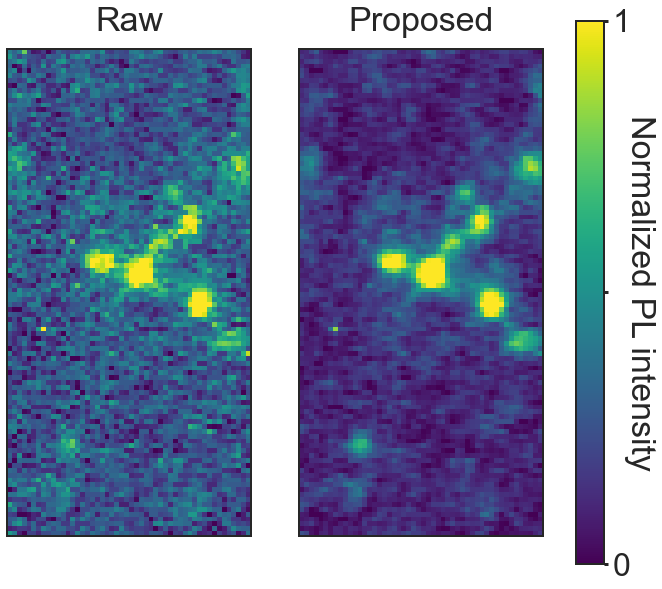

In [10]:
plt.style.use('seaborn-white')
matplotlib.rcParams['axes.linewidth'] = 2
font = {'size': 34}
matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.major.pad']='8'
matplotlib.rcParams['ytick.major.pad']='8'
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, gridspec_kw=dict(width_ratios=[1, 1],hspace=0.075),figsize=(12, 10))
mat = ax0.matshow(ReadH5.normalization(img_raw[25,1000:1100,468:518], dynamic = 0.99, rang=[0,1])[0], cmap='viridis')
ax0.set(xticklabels=[])
ax0.axes.get_yaxis().set_visible(False)
ax0.set_xlabel('Raw', labelpad=10)
ax0.xaxis.set_label_position('top')
mat = ax1.matshow(ReadH5.normalization(img_denoised[25,1000:1100,468:518], dynamic = 0.99, rang=[0,1])[0], cmap='viridis')
ax1.set(xticklabels=[])
ax1.axes.get_yaxis().set_visible(False)
ax1.set_xlabel('Proposed', labelpad=10)
ax1.xaxis.set_label_position('top')
cbar = fig.colorbar(mat, ax=[ax0,ax1])
cbar.ax.tick_params(axis='y', direction='out',length=4,width=3,pad=5,labelsize=32)
cbar.ax.set_ylabel('Normalized PL intensity',labelpad=25, rotation=-90)
cbar.ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=3, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='y',which='minor',direction='out',length=4,width=3,pad=5,labelsize=32)

## Reproducing SI Figure 6c

Expect output: SI Figure 6c

Time cost: 3-5 min

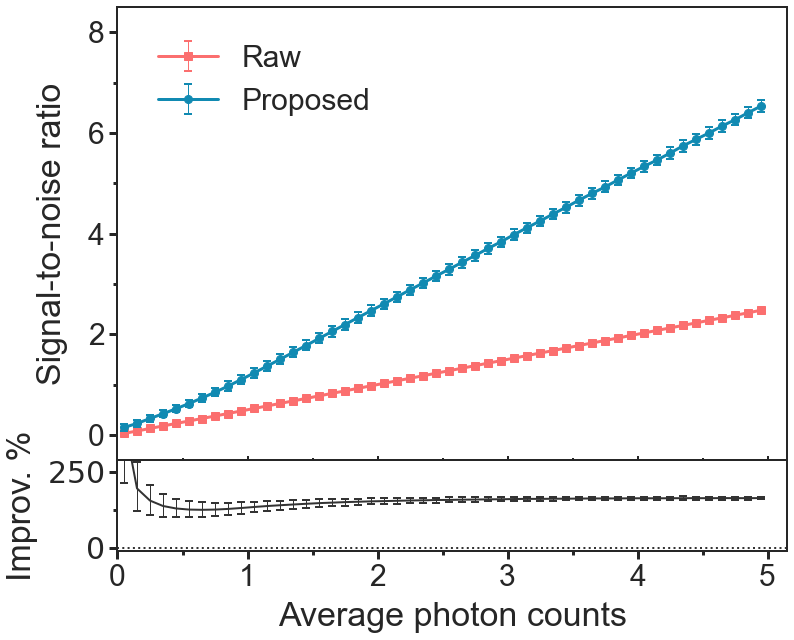

In [11]:
# SNR mapping statistics
from scipy.stats import gaussian_kde, binned_statistic, binned_statistic_2d

def signaltonoise(a, std, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    return m/std

img_int = np.mean(img_raw,axis=0).flatten()
img_raw_snr = signaltonoise(img_raw,np.std(img_raw[:,101:109,710:718]),axis=(0)).flatten()
img_denoised_snr = signaltonoise(img_denoised,np.std(img_denoised[:,101:109,710:718]),axis=(0)).flatten()

# remove pixels of counts<=0
delete_list = []
for i, value in enumerate(img_raw_snr):
    if value <= 0:
        delete_list.append(i)
img_int = np.delete(img_int, delete_list)
img_raw_snr = np.delete(img_raw_snr, delete_list)
img_denoised_snr = np.delete(img_denoised_snr, delete_list)

int_range = [0,5]
int_bin = (int_range[1]-int_range[0])*10

raw_median, bin_edges, _ = binned_statistic(img_int, img_raw_snr, statistic='median', bins=int_bin, range=[int_range])
raw_25, _, _ = binned_statistic(img_int, img_raw_snr, statistic=lambda y: np.percentile(y, 25), bins=int_bin, range=[int_range])
raw_75, _, _ = binned_statistic(img_int, img_raw_snr, statistic=lambda y: np.percentile(y, 75), bins=int_bin, range=[int_range])
raw_count, _, _ = binned_statistic(img_int, img_raw_snr, statistic='count', bins=int_bin, range=[int_range])
de_median, _, _ = binned_statistic(img_int, img_denoised_snr, statistic='median', bins=int_bin, range=[int_range])
de_25, _, _ = binned_statistic(img_int, img_denoised_snr, statistic=lambda y: np.percentile(y, 25), bins=int_bin, range=[int_range])
de_75, _, _ = binned_statistic(img_int, img_denoised_snr, statistic=lambda y: np.percentile(y, 75), bins=int_bin, range=[int_range])

improv = np.array((img_denoised_snr/img_raw_snr-1)*100)

improv_median, _, _ = binned_statistic(img_int, improv, statistic=lambda y: np.median(y), bins=int_bin, range=[int_range])
improv_25, _, _ = binned_statistic(img_int, improv, statistic=lambda y: np.percentile(y, 25), bins=int_bin, range=[int_range])
improv_75, _, _ = binned_statistic(img_int, improv, statistic=lambda y: np.percentile(y, 75), bins=int_bin, range=[int_range])

# plot the analysis
plt.style.use('seaborn-white')
matplotlib.rcParams['axes.linewidth'] = 2
font = {'size': 34}
matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.major.pad'] = '8'
matplotlib.rcParams['ytick.major.pad'] = '8'
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
labelsize=30

fig, (ax0, ax1) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[5, 1]),figsize=(12, 10))

ax0.errorbar(bin_edges[:-1]+0.05, raw_median, yerr=np.array([raw_median-raw_25,raw_75-raw_median]),
             linestyle='-', label='Raw', marker='s', elinewidth=1, capsize=4, capthick=2, color=matplotlib.colors.to_rgba('#fb6f6f')[:-1]+(1,), linewidth=3, markersize=8, zorder=1)
ax0.errorbar(bin_edges[:-1]+0.05, de_median, yerr=np.array([de_median-de_25,de_75-de_median]),
             linestyle='-', label='Proposed', marker='o', elinewidth=1, capsize=4, capthick=2, color=matplotlib.colors.to_rgba('#118ab2')[:-1]+(1,), linewidth=3, markersize=8, zorder=2)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(fontsize=30, loc='lower left', bbox_to_anchor=(0.02, 0.70))
ax0.set_xlim(int_range)
ax0.set_ylim([-0.5, 8.5])
ax0.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax0.set_ylabel('Signal-to-noise ratio', labelpad=20)
ax0.tick_params(axis='y', direction='out', length=8, width=3, pad=5, labelsize=labelsize)
ax0.tick_params(axis='x', direction='inout', length=8, width=2, pad=5, labelsize=labelsize)
ax0.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=6, integer=True, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=5, integer=False, steps=[2, 5]))
ax0.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='y', which='minor', direction='out', length=4, width=3, pad=5)
ax0.tick_params(axis='x', which='minor', direction='inout', length=4, width=2, pad=5)

ax1.errorbar(bin_edges[:-1]+0.05, improv_median, yerr=np.array([improv_median-improv_25,improv_75-improv_median]), 
         elinewidth=1, capsize=4, capthick=2, color=matplotlib.colors.to_rgba('#333333'), linewidth=2)
ax1.hlines(y=0, xmin=0, xmax=10, linestyles='dotted', linewidth=2, color=matplotlib.colors.to_rgba('#333333'))
ax1.yaxis.set_ticklabels([])
ax0.set_xlim([0,5.15])
ax1.set_ylim([-10, 290])
ax1.set_xlabel('Average photon counts', labelpad=10)
ax1.set_ylabel('Improv. %', labelpad=9)
ax1.tick_params(axis='both', direction='out', length=8, width=3, pad=5, labelsize=labelsize)
ax1.tick_params(axis='both', which='minor', direction='out', length=4, width=3, pad=5)
f = matplotlib.ticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%d' % x))
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(g))
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=6, integer=True, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
plt.subplots_adjust(hspace=.0)